Processing data for Goal 0
Processing data for Goal 1
Processing data for Goal 2


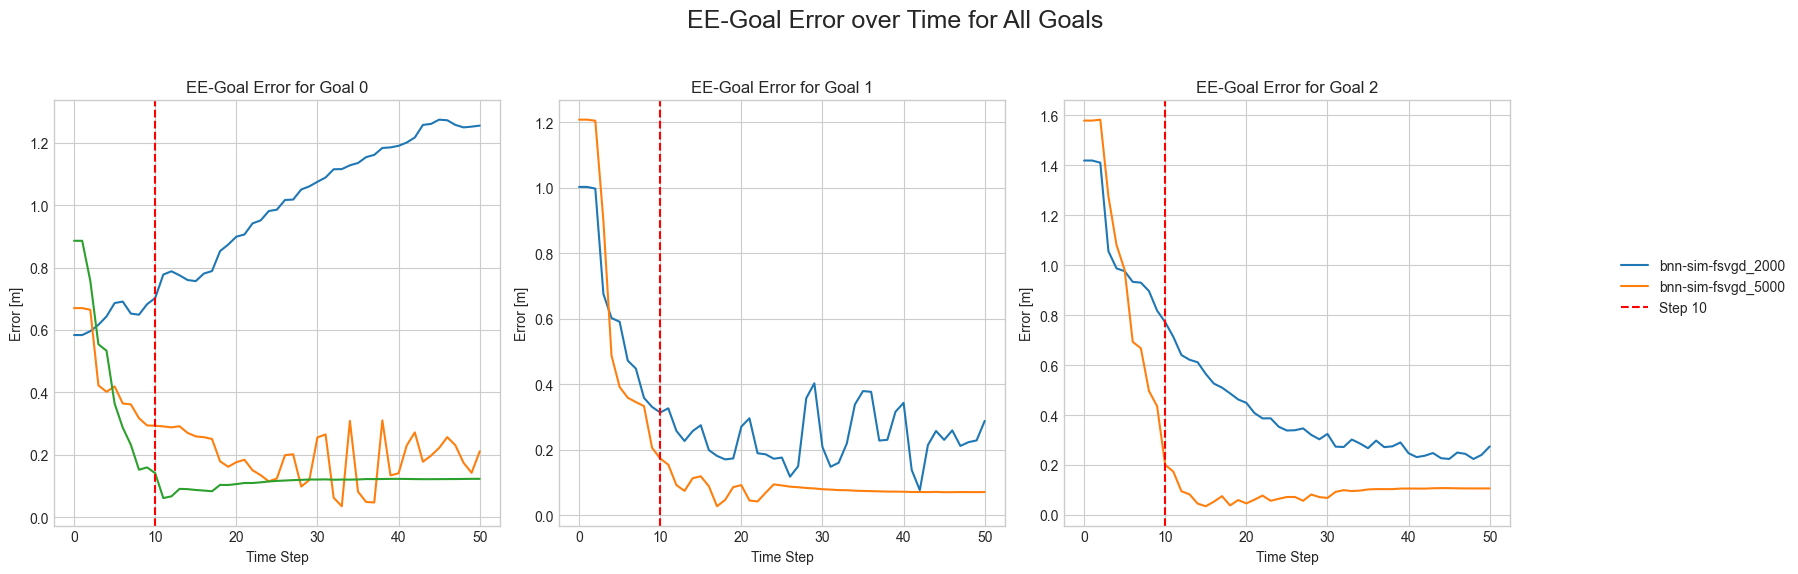

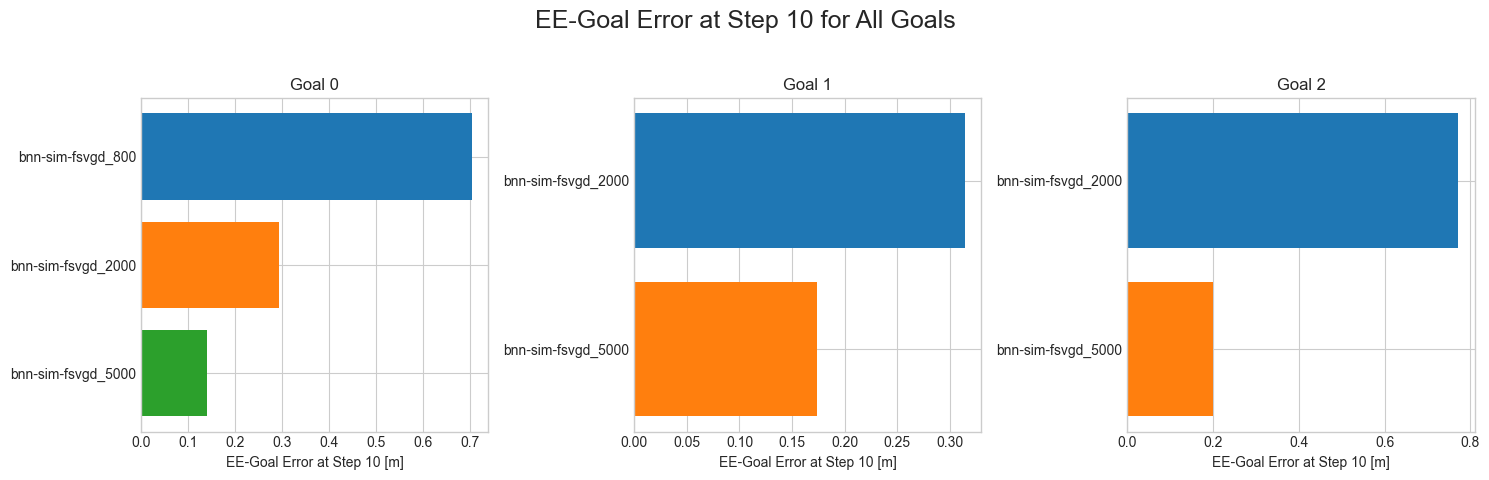

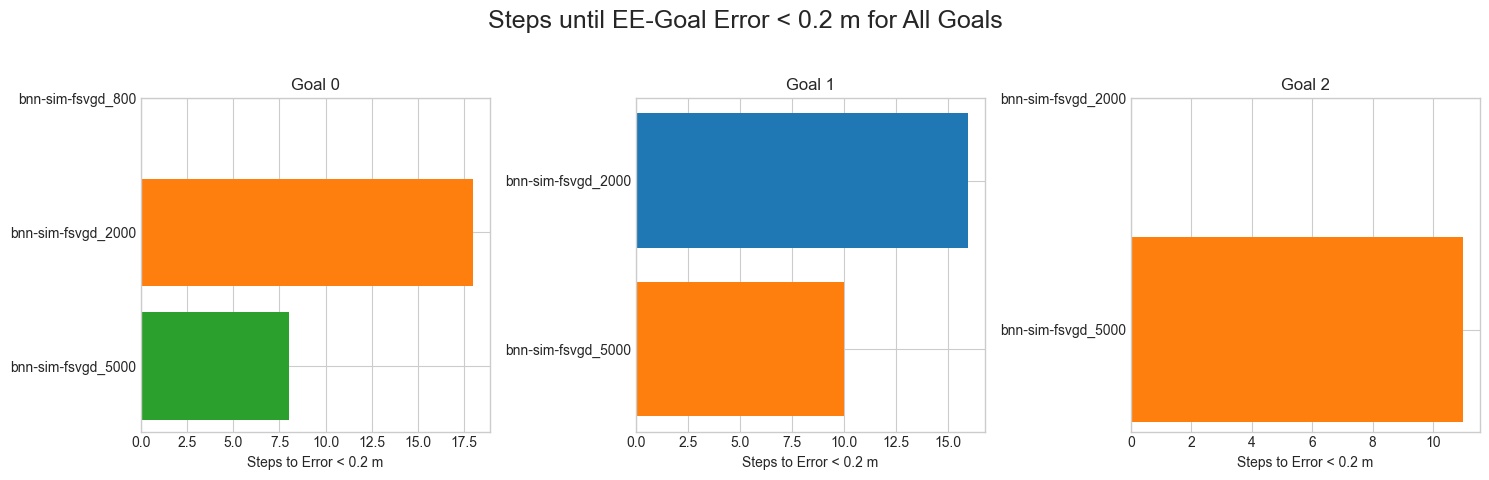

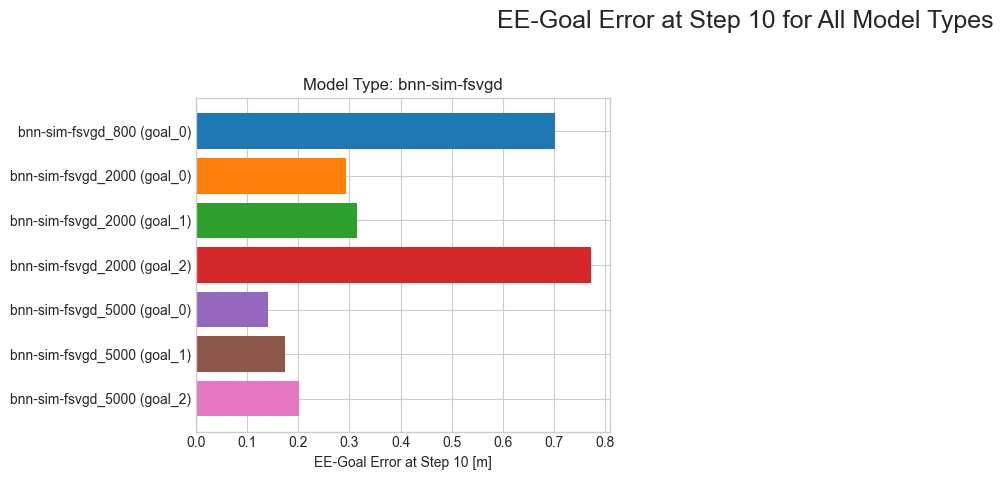

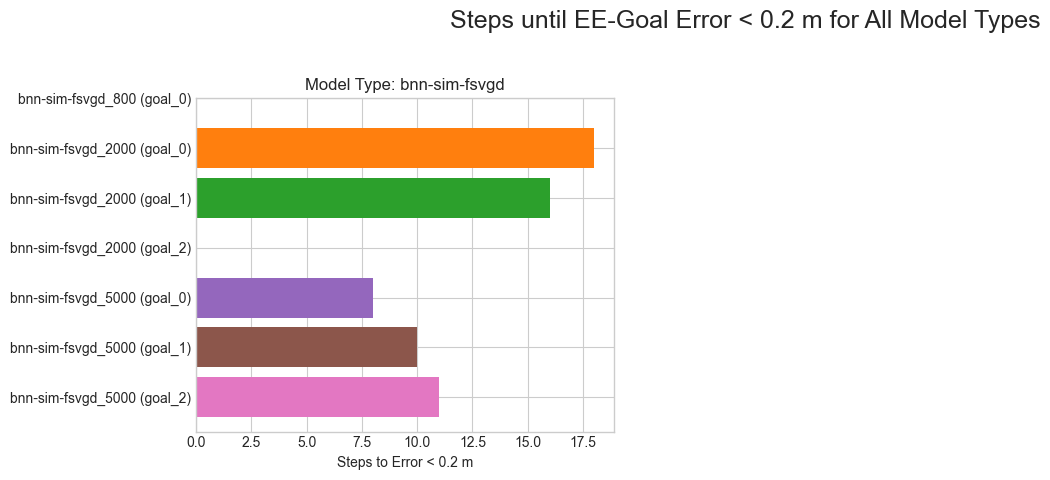

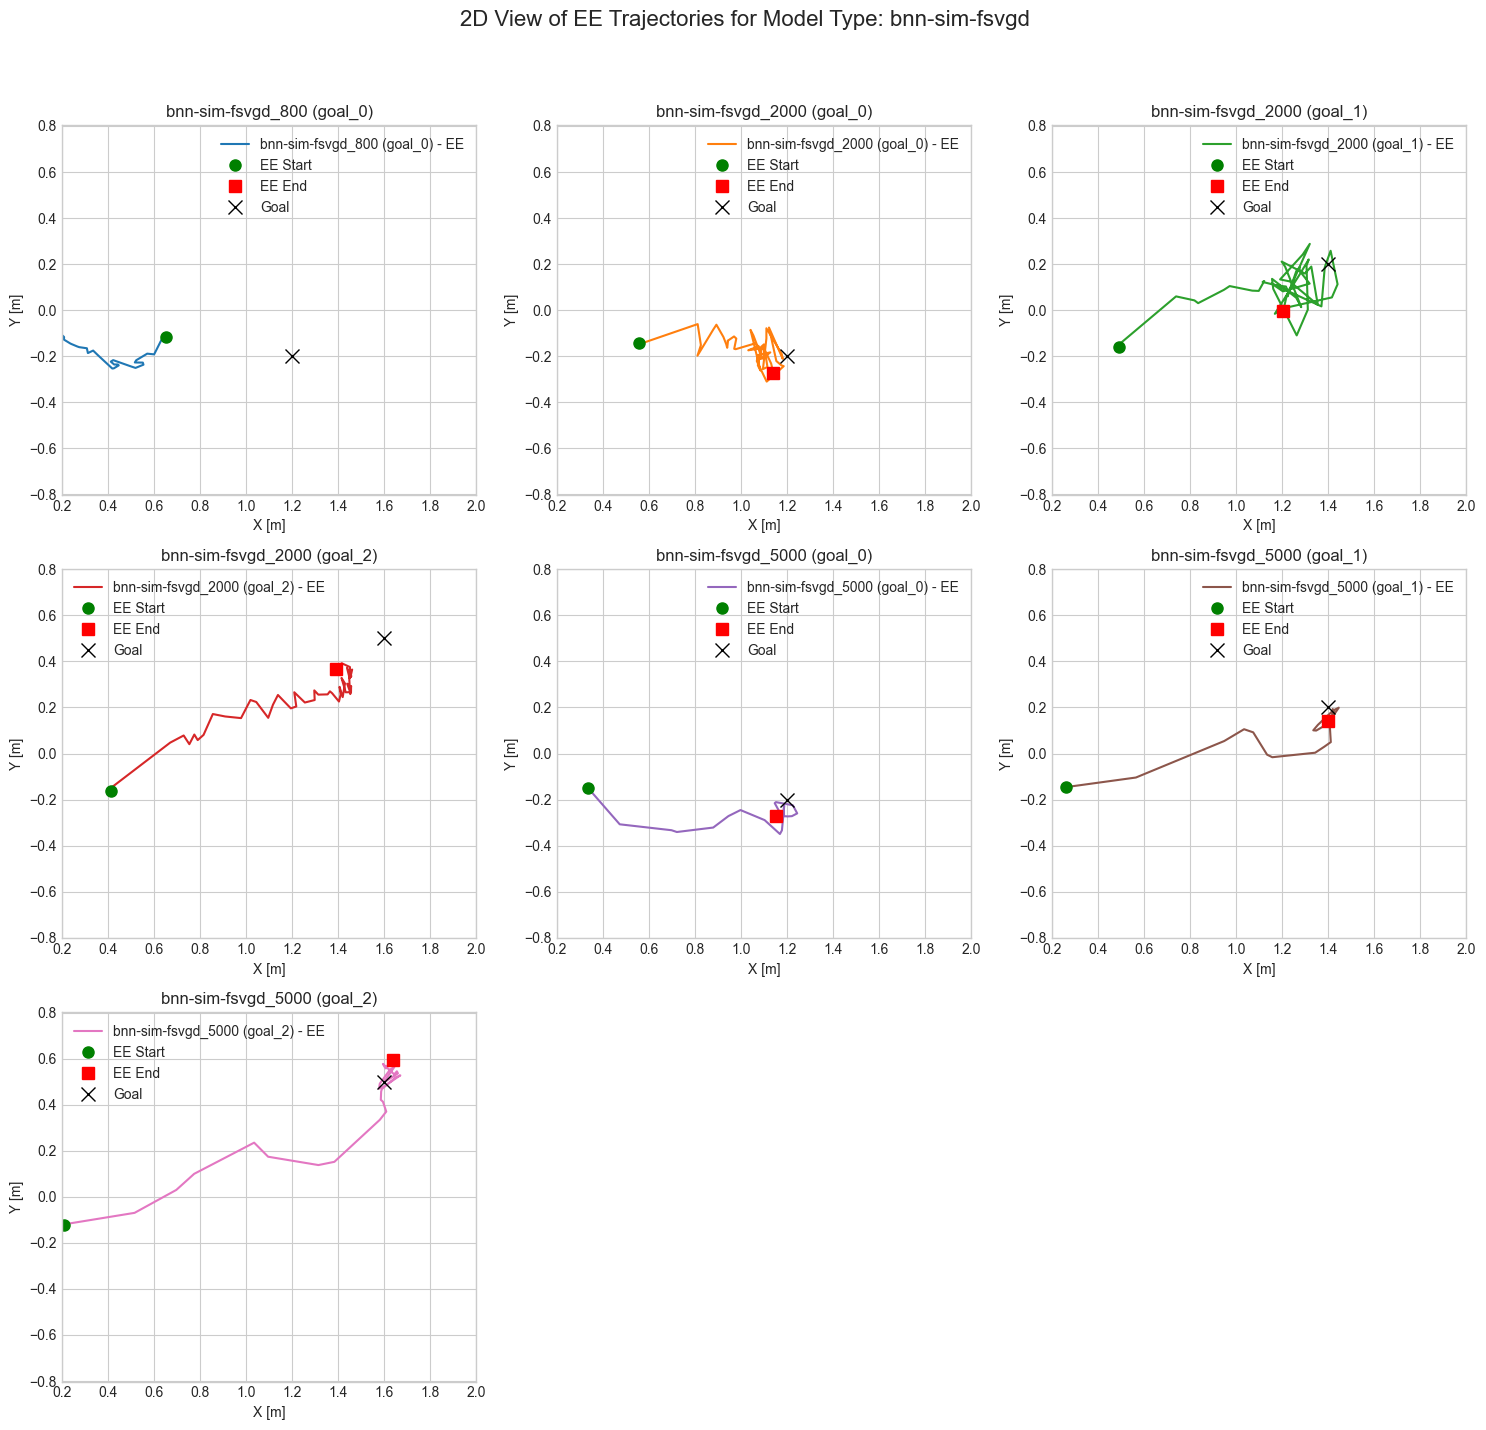

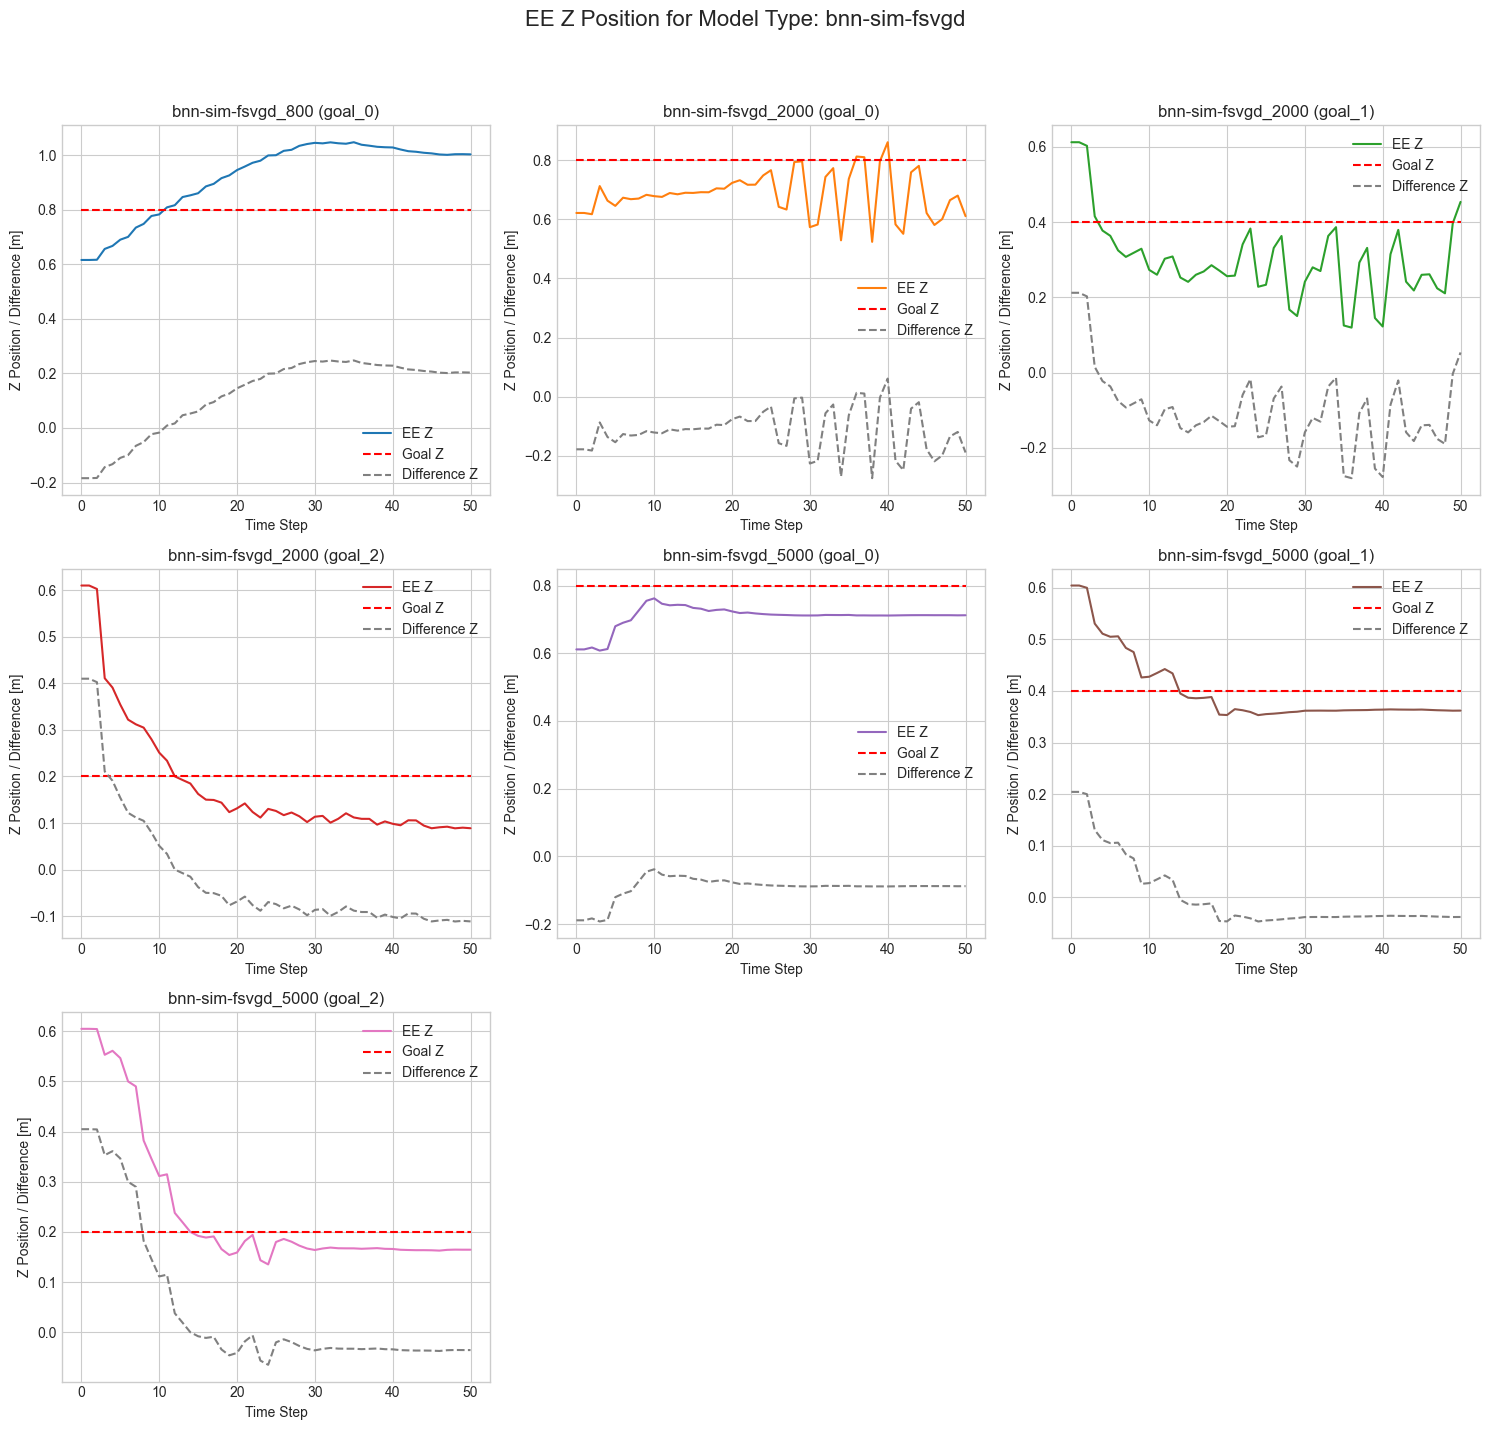

In [11]:
""" Full evaluation of policy performance on real robot """

import pickle
import numpy as np
import matplotlib.pyplot as plt
from sim_transfer.sims.util import decode_angles
from brax.training.types import Transition
import jax.tree_util as jtu
import jax.numpy as jnp
import re
import os

# Use a style for better aesthetics
plt.style.use("seaborn-v0_8-whitegrid")

# Global variables
step_index = 10  # Define the step index for error calculation
error_threshold = 0.2  # Threshold for EE-Goal error
plot_analysis = False  # Set to True to enable 'Analysis for Goal x' plots

# Define the list of trajectory files and their corresponding labels
file_paths = [
    # # uses goal 0
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241014-150458_policy_testing_partial_v4_hck2b2u0_sim-model_800_3_0__0.8/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241014-150610_policy_testing_partial_v4_chn3iu4r_sim-model_2000_3_0__0.8/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241014-150732_policy_testing_partial_v4_yjgeqtmy_sim-model_5000_3_0__0.8/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241014-150840_policy_testing_partial_v4_sq0k6akn_bnn-sim-fsvgd_800_3_0__0.8/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241014-150940_policy_testing_partial_v4_k5kepn4q_bnn-sim-fsvgd_2000_3_0__0.8/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241014-151040_policy_testing_partial_v4_891g63gq_bnn-sim-fsvgd_5000_3_0__0.8/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241014-151158_policy_testing_partial_v4_hjbw63y8_bnn-fsvgd_800_3_0__0.8/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241014-151259_policy_testing_partial_v4_0dslu87b_bnn-fsvgd_2000_3_0__0.8/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241014-151342_policy_testing_partial_v4_hq7f5yzu_bnn-fsvgd_5000_3_0__0.8/brax_transitions.pickle",
    # # uses goal 1
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241014-151922_policy_testing_partial_v4_hck2b2u0_sim-model_800_3_1__0.8/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241014-152030_policy_testing_partial_v4_chn3iu4r_sim-model_2000_3_1__0.8/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241014-152121_policy_testing_partial_v4_yjgeqtmy_sim-model_5000_3_1__0.8/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241014-152233_policy_testing_partial_v4_sq0k6akn_bnn-sim-fsvgd_800_3_1__0.8/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241014-152321_policy_testing_partial_v4_k5kepn4q_bnn-sim-fsvgd_2000_3_1__0.8/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241014-152422_policy_testing_partial_v4_891g63gq_bnn-sim-fsvgd_5000_3_1__0.8/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241014-152521_policy_testing_partial_v4_hjbw63y8_bnn-fsvgd_800_3_1__0.8/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241014-152618_policy_testing_partial_v4_0dslu87b_bnn-fsvgd_2000_3_1__0.8/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241014-152707_policy_testing_partial_v4_hq7f5yzu_bnn-fsvgd_5000_3_1__0.8/brax_transitions.pickle",
    # # uses goal 2
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241014-153401_policy_testing_partial_v4_hck2b2u0_sim-model_800_3_2__0.8/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241014-153511_policy_testing_partial_v4_chn3iu4r_sim-model_2000_3_2__0.8/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241014-153617_policy_testing_partial_v4_yjgeqtmy_sim-model_5000_3_2__0.8/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241014-153718_policy_testing_partial_v4_sq0k6akn_bnn-sim-fsvgd_800_3_2__0.8/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241014-153806_policy_testing_partial_v4_k5kepn4q_bnn-sim-fsvgd_2000_3_2__0.8/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241014-153907_policy_testing_partial_v4_891g63gq_bnn-sim-fsvgd_5000_3_2__0.8/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241014-154010_policy_testing_partial_v4_hjbw63y8_bnn-fsvgd_800_3_2__0.8/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241014-154103_policy_testing_partial_v4_0dslu87b_bnn-fsvgd_2000_3_2__0.8/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241014-154148_policy_testing_partial_v4_hq7f5yzu_bnn-fsvgd_5000_3_2__0.8/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241016-131049_action_stack_testing_xcmnhhfq_bnn-sim-fsvgd_5000_1_2__1.1/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241016-131152_action_stack_testing_xcmnhhfq_bnn-sim-fsvgd_5000_1_1__1.1/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241016-131252_action_stack_testing_xcmnhhfq_bnn-sim-fsvgd_5000_1_0__1.1/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241016-195111_action_stack_testing_v3_dj131cg6_bnn-sim-fsvgd_5000_1_0__1.0/brax_transitions.pickle"
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241017-111043_action_stack_testing_v5_zlbzwr4q_sim-model_5000_1_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241017-110203_action_stack_testing_v5_p7kd475o_bnn-sim-fsvgd_5000_1_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241017-110310_action_stack_testing_v5_lhfwewuf_bnn-sim-fsvgd_5000_1_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241017-110405_action_stack_testing_v5_u9i1vo0n_bnn-sim-fsvgd_5000_1_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241017-110507_action_stack_testing_v5_i37so3f7_bnn-sim-fsvgd_5000_1_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241017-110649_action_stack_testing_v5_biteqxmk_bnn-fsvgd_5000_1_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241017-110745_action_stack_testing_v5_ji4pagqe_bnn-fsvgd_5000_1_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241017-110841_action_stack_testing_v5_btaozmx5_bnn-fsvgd_5000_1_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241017-110936_action_stack_testing_v5_gwvr88cm_bnn-fsvgd_5000_1_0__1.0/brax_transitions.pickle",



    # new policy_testing_full_v9_0.3
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134202_policy_testing_full_v9_0q0aqecs_bnn-sim-fsvgd_800_1_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134300_policy_testing_full_v9_0q0aqecs_bnn-sim-fsvgd_800_1_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134355_policy_testing_full_v9_0q0aqecs_bnn-sim-fsvgd_800_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134447_policy_testing_full_v9_a95frpg8_bnn-sim-fsvgd_2000_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134538_policy_testing_full_v9_a95frpg8_bnn-sim-fsvgd_2000_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134630_policy_testing_full_v9_a95frpg8_bnn-sim-fsvgd_2000_1_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134723_policy_testing_full_v9_qmvdd08w_bnn-sim-fsvgd_5000_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134822_policy_testing_full_v9_qmvdd08w_bnn-sim-fsvgd_5000_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134908_policy_testing_full_v9_qmvdd08w_bnn-sim-fsvgd_5000_1_2__1.0/brax_transitions.pickle",

    ]

# Define your goals
# goal_1 = jnp.array([1.2, -0.2, 0.8])
# goal_1 = jnp.array([1.8, -0.4, 0.4])
# goal_2 = jnp.array([1.4, 0.2, 0.4])
# goal_3 = jnp.array([1.6, 0.0, 0.2])
goal_1 = np.array([1.2, -0.2, 0.8])
goal_2 = np.array([1.4, 0.2, 0.4])
goal_3 = np.array([1.6, 0.5, 0.2])

goals = [goal_1, goal_2, goal_3]

# Set global x and y limits for the 2D plots
x_limits = (0.2, 2.0)
y_limits = (-1.5, 1.5)

# Initialize dictionaries to store data per goal and per model type
goal_data = {}
model_data = {}


def get_model_type(label):
    """Extract model type from label by removing trailing numeric parts."""
    parts = label.split("_")
    # Remove numeric parts at the end
    while parts and parts[-1].isdigit():
        parts = parts[:-1]
    model_type = "_".join(parts)
    return model_type


def extract_label_from_file_path(file_path):
    """Extract model label from the file path."""
    dir_name = os.path.dirname(file_path)
    dir_base_name = os.path.basename(dir_name)
    # Extract the part after the unique ID
    # Assuming the directory name has a format like: '..._<unique_id>_<model_label>_<params>'
    match = re.search(r"_(\w{8})_(.*)__", dir_base_name)
    if match:
        model_label_and_params = match.group(2)
        model_label_parts = model_label_and_params.split("_")
        if len(model_label_parts) >= 3:
            # Assuming the last two parts are goal indices or other parameters
            model_label = "_".join(model_label_parts[:-2])
        else:
            model_label = "_".join(model_label_parts)
        return model_label
    else:
        # If the above pattern doesn't match, try another pattern
        # This pattern assumes the directory name ends with '__<number>'
        match = re.search(r"_(\w{8})_(.*)", dir_base_name)
        if match:
            model_label_and_params = match.group(2)
            model_label_parts = model_label_and_params.split("_")
            if len(model_label_parts) >= 3:
                model_label = "_".join(model_label_parts[:-2])
            else:
                model_label = "_".join(model_label_parts)
            return model_label
        else:
            raise ValueError(f"Could not extract label from file path {file_path}")


# Loop over each trajectory file
for idx, file_path in enumerate(file_paths):
    # Load trajectory from policy simulation
    with open(file_path, "rb") as file:
        traj_raw = pickle.load(file)

    # Extract goal index from file path
    match = re.search(r"_(\d+)__", file_path)
    if match:
        goal_index = int(match.group(1))
    else:
        raise ValueError(f"Could not extract goal index from file path {file_path}")
    if goal_index >= len(goals):
        raise ValueError(f"Goal index {goal_index} is out of bounds")

    goal = goals[goal_index]

    # Extract label from file path
    label = extract_label_from_file_path(file_path)
    if label is None:
        print(f"Could not extract label from file path {file_path}")
        continue
    model_type = get_model_type(label)

    # Initialize data structures for this goal if not already done
    if goal_index not in goal_data:
        goal_data[goal_index] = {
            "file_paths": [],
            "labels": [],
            "observations": [],
            "actions": [],
            "rewards": [],
            "ee_goal_errors_at_step": [],
            "steps_below_threshold": [],
        }

    # Initialize data structures for this model type if not already done
    if model_type not in model_data:
        model_data[model_type] = {
            "labels": [],
            "observations": [],
            "actions": [],
            "rewards": [],
            "ee_goal_errors_at_step": [],
            "steps_below_threshold": [],
            "goals": [],
        }

    # Add goal to observations
    def add_goal_to_obs(obs: jnp.ndarray, goal: jnp.ndarray) -> jnp.ndarray:
        return jnp.concatenate([obs, goal])

    new_traj = []

    # Add goal to each observation in the trajectory
    for i in range(len(traj_raw)):
        obs = traj_raw[i].observation
        next_obs = traj_raw[i].next_observation
        obs = add_goal_to_obs(obs, goal)
        next_obs = add_goal_to_obs(next_obs, goal)
        new_traj.append(
            Transition(
                observation=obs,
                action=traj_raw[i].action,
                reward=jnp.array(0),
                next_observation=next_obs,
                discount=traj_raw[i].discount,
            )
        )

    traj = jtu.tree_map(lambda *xs: jnp.stack(xs, axis=0), *new_traj)

    # Convert transitions to trajectory
    observations = traj.observation
    actions = traj.action
    rewards = traj.reward

    # Decode angles if needed
    if observations.shape[-1] == 16:
        observations = decode_angles(observations, 2)

    # Convert observations to numpy array
    observations_np = np.array(observations)

    # Calculate EE-Goal error over time
    ee_pos = observations_np[:, 6:9]
    goal_pos = observations_np[:, -3:]
    error = np.linalg.norm(ee_pos - goal_pos, axis=1)

    # EE-Goal error at step_index
    if len(error) > step_index:
        ee_goal_error_at_step = error[step_index]
    else:
        ee_goal_error_at_step = np.nan

    # Steps until error drops below threshold
    steps_below_threshold = np.where(error < error_threshold)[0]
    if steps_below_threshold.size > 0:
        steps_to_threshold = steps_below_threshold[0]
    else:
        steps_to_threshold = np.nan  # Did not reach threshold

    # Append data to the corresponding goal
    goal_data[goal_index]["file_paths"].append(file_path)
    goal_data[goal_index]["labels"].append(label)
    goal_data[goal_index]["observations"].append(observations_np)
    goal_data[goal_index]["actions"].append(np.array(actions))
    goal_data[goal_index]["rewards"].append(np.array(rewards))
    goal_data[goal_index]["ee_goal_errors_at_step"].append(ee_goal_error_at_step)
    goal_data[goal_index]["steps_below_threshold"].append(steps_to_threshold)

    # Append data to the corresponding model type
    model_data[model_type]["labels"].append(f"{label} (goal_{goal_index})")
    model_data[model_type]["observations"].append(observations_np)
    model_data[model_type]["actions"].append(np.array(actions))
    model_data[model_type]["rewards"].append(np.array(rewards))
    model_data[model_type]["ee_goal_errors_at_step"].append(ee_goal_error_at_step)
    model_data[model_type]["steps_below_threshold"].append(steps_to_threshold)
    model_data[model_type]["goals"].append(goal_index)

# Plotting functions


def plot_ee_2d_view_per_model(model_data, x_limits, y_limits):
    """Plot EE trajectories per model type with subplots for each version."""
    for model_type, data in model_data.items():
        observations = data["observations"]
        labels = data["labels"]
        num_models = len(observations)
        num_cols = 3
        num_rows = (num_models + num_cols - 1) // num_cols

        fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
        axs = axs.flatten()
        cmap = plt.get_cmap("tab10")

        for idx, obs in enumerate(observations):
            ax = axs[idx]
            color = cmap(idx % 10)
            label = labels[idx]
            # Plot EE trajectory
            ax.plot(obs[:, 6], obs[:, 7], label=f"{label} - EE", color=color)
            # Plot EE start and end points
            ax.plot(
                obs[0, 6], obs[0, 7], "o", color="green", markersize=8, label="EE Start"
            )
            ax.plot(
                obs[-1, 6], obs[-1, 7], "s", color="red", markersize=8, label="EE End"
            )
            # Plot goal position
            ax.plot(
                obs[0, -3], obs[0, -2], "x", color="black", markersize=10, label="Goal"
            )
            ax.set_title(f"{label}")
            ax.set_xlabel("X [m]")
            ax.set_ylabel("Y [m]")
            ax.axis("equal")
            ax.set_xlim(x_limits)
            ax.set_ylim(y_limits)
            ax.legend()
            ax.grid(True)

        # Hide any unused subplots
        for idx in range(len(observations), len(axs)):
            fig.delaxes(axs[idx])

        plt.suptitle(
            f"2D View of EE Trajectories for Model Type: {model_type}", fontsize=16
        )
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


def plot_ee_z_position_per_model(model_data):
    """Plot EE Z position per model type with subplots for each version."""
    for model_type, data in model_data.items():
        observations = data["observations"]
        labels = data["labels"]
        num_models = len(observations)
        num_cols = 3
        num_rows = (num_models + num_cols - 1) // num_cols

        fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
        axs = axs.flatten()
        cmap = plt.get_cmap("tab10")

        for idx, obs in enumerate(observations):
            ax = axs[idx]
            color = cmap(idx % 10)
            label = labels[idx]
            time_steps = np.arange(obs.shape[0])
            ee_z = obs[:, 8]
            goal_z = obs[0, -1]
            ax.plot(time_steps, ee_z, label=f"EE Z", color=color)
            ax.hlines(
                goal_z,
                time_steps[0],
                time_steps[-1],
                colors="r",
                linestyles="--",
                label="Goal Z",
            )
            diff_z = ee_z - goal_z
            ax.plot(
                time_steps, diff_z, linestyle="--", label=f"Difference Z", color="gray"
            )
            ax.set_title(f"{label}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Z Position / Difference [m]")
            ax.legend()
            ax.grid(True)

        # Hide any unused subplots
        for idx in range(len(observations), len(axs)):
            fig.delaxes(axs[idx])

        plt.suptitle(f"EE Z Position for Model Type: {model_type}", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


def plot_ee_goal_error(goal_data):
    """Plot EE-Goal Error over time with subplots for each goal."""
    num_goals = len(goal_data)
    num_cols = 3
    num_rows = (num_goals + num_cols - 1) // num_cols

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 6 * num_rows))
    axs = axs.flatten()
    cmap = plt.get_cmap("tab10")

    for idx, (goal_index, data) in enumerate(goal_data.items()):
        ax = axs[idx]
        observations = data["observations"]
        labels = data["labels"]
        for i, obs in enumerate(observations):
            color = cmap(i % 10)
            ee_pos = obs[:, 6:9]
            goal_pos = obs[:, -3:]
            error = np.linalg.norm(ee_pos - goal_pos, axis=1)
            time_steps = np.arange(len(error))
            ax.plot(time_steps, error, label=f"{labels[i]}", color=color)
        ax.axvline(step_index, color="r", linestyle="--", label=f"Step {step_index}")
        ax.set_title(f"EE-Goal Error for Goal {goal_index}")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Error [m]")
        ax.grid(True)
        if (idx + 1) % num_cols == 0 or idx == len(goal_data) - 1:
            # Add legend to the right of the last subplot in the row
            handles, labels_leg = ax.get_legend_handles_labels()
            fig.legend(handles, labels_leg, loc="center right")

    # Hide any unused subplots
    for idx in range(len(goal_data), len(axs)):
        fig.delaxes(axs[idx])

    plt.suptitle("EE-Goal Error over Time for All Goals", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 0.85, 0.95])  # Adjusted to make room for legend
    plt.show()


def plot_ee_goal_error_at_step(errors_per_goal, step_index):
    """Plot EE-Goal Error at a specific step with subplots per goal."""
    num_goals = len(errors_per_goal)
    num_cols = 3
    num_rows = (num_goals + num_cols - 1) // num_cols

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axs = axs.flatten()
    cmap = plt.get_cmap("tab10")

    for idx, (goal_index, data) in enumerate(errors_per_goal.items()):
        errors = data["ee_goal_errors_at_step"]
        labels_goal = data["labels"]
        y_positions = np.arange(len(labels_goal))
        colors = [cmap(i % 10) for i in range(len(labels_goal))]
        ax = axs[idx]
        ax.barh(y_positions, errors, align="center", color=colors)
        ax.set_yticks(y_positions)
        ax.set_yticklabels(labels_goal)
        ax.set_xlabel(f"EE-Goal Error at Step {step_index} [m]")
        ax.set_title(f"Goal {goal_index}")
        ax.invert_yaxis()
        ax.grid(True, axis="x")

    # Hide any unused subplots
    for idx in range(len(errors_per_goal), len(axs)):
        fig.delaxes(axs[idx])

    plt.suptitle(f"EE-Goal Error at Step {step_index} for All Goals", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def plot_steps_below_threshold(errors_per_goal, threshold):
    """Plot number of steps until EE-Goal error drops below threshold, with subplots per goal."""
    num_goals = len(errors_per_goal)
    num_cols = 3
    num_rows = (num_goals + num_cols - 1) // num_cols

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axs = axs.flatten()
    cmap = plt.get_cmap("tab10")

    for idx, (goal_index, data) in enumerate(errors_per_goal.items()):
        steps = data["steps_below_threshold"]
        labels_goal = data["labels"]
        y_positions = np.arange(len(labels_goal))
        colors = [cmap(i % 10) for i in range(len(labels_goal))]
        ax = axs[idx]
        ax.barh(y_positions, steps, align="center", color=colors)
        ax.set_yticks(y_positions)
        ax.set_yticklabels(labels_goal)
        ax.set_xlabel(f"Steps to Error < {threshold} m")
        ax.set_title(f"Goal {goal_index}")
        ax.invert_yaxis()
        ax.grid(True, axis="x")

    # Hide any unused subplots
    for idx in range(len(errors_per_goal), len(axs)):
        fig.delaxes(axs[idx])

    plt.suptitle(
        f"Steps until EE-Goal Error < {threshold} m for All Goals", fontsize=18
    )
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def plot_ee_goal_error_at_step_per_model(errors_per_model, step_index):
    """Plot EE-Goal Error at a specific step with subplots per model type."""
    num_models = len(errors_per_model)
    num_cols = 3
    num_rows = (num_models + num_cols - 1) // num_cols

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axs = axs.flatten()
    cmap = plt.get_cmap("tab10")

    for idx, (model_type, data) in enumerate(errors_per_model.items()):
        errors = data["ee_goal_errors_at_step"]
        labels_model = data["labels"]
        y_positions = np.arange(len(labels_model))
        colors = [cmap(i % 10) for i in range(len(labels_model))]
        ax = axs[idx]
        ax.barh(y_positions, errors, align="center", color=colors)
        ax.set_yticks(y_positions)
        ax.set_yticklabels(labels_model)
        ax.set_xlabel(f"EE-Goal Error at Step {step_index} [m]")
        ax.set_title(f"Model Type: {model_type}")
        ax.invert_yaxis()
        ax.grid(True, axis="x")

    # Hide any unused subplots
    for idx in range(len(errors_per_model), len(axs)):
        fig.delaxes(axs[idx])

    plt.suptitle(f"EE-Goal Error at Step {step_index} for All Model Types", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def plot_steps_below_threshold_per_model(errors_per_model, threshold):
    """Plot steps until EE-Goal error drops below threshold, with subplots per model type."""
    num_models = len(errors_per_model)
    num_cols = 3
    num_rows = (num_models + num_cols - 1) // num_cols

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axs = axs.flatten()
    cmap = plt.get_cmap("tab10")

    for idx, (model_type, data) in enumerate(errors_per_model.items()):
        steps = data["steps_below_threshold"]
        labels_model = data["labels"]
        y_positions = np.arange(len(labels_model))
        colors = [cmap(i % 10) for i in range(len(labels_model))]
        ax = axs[idx]
        ax.barh(y_positions, steps, align="center", color=colors)
        ax.set_yticks(y_positions)
        ax.set_yticklabels(labels_model)
        ax.set_xlabel(f"Steps to Error < {threshold} m")
        ax.set_title(f"Model Type: {model_type}")
        ax.invert_yaxis()
        ax.grid(True, axis="x")

    # Hide any unused subplots
    for idx in range(len(errors_per_model), len(axs)):
        fig.delaxes(axs[idx])

    plt.suptitle(
        f"Steps until EE-Goal Error < {threshold} m for All Model Types", fontsize=18
    )
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Now, perform the analysis per goal
# Collect ee_goal_errors_at_step per goal and per model type for plotting
errors_per_goal = {}
errors_per_model = {}

for goal_index, data in goal_data.items():
    print(f"Processing data for Goal {goal_index}")
    observations = data["observations"]
    actions = data["actions"]
    labels = data["labels"]
    ee_goal_errors_at_step = data["ee_goal_errors_at_step"]
    steps_below_threshold = data["steps_below_threshold"]
    rewards = data["rewards"]

    errors_per_goal[goal_index] = {
        "ee_goal_errors_at_step": ee_goal_errors_at_step,
        "steps_below_threshold": steps_below_threshold,
        "labels": labels,
    }

# Collect errors per model type
for model_type, data in model_data.items():
    errors_per_model[model_type] = {
        "ee_goal_errors_at_step": data["ee_goal_errors_at_step"],
        "steps_below_threshold": data["steps_below_threshold"],
        "labels": data["labels"],
        "goals": data["goals"],
    }

# Plot EE-Goal Error over time for all goals once
plot_ee_goal_error(goal_data)

# Plot EE-Goal Error at Step x using subplots for each goal
plot_ee_goal_error_at_step(errors_per_goal, step_index)

# Plot Steps until EE-Goal Error drops below threshold per goal
plot_steps_below_threshold(errors_per_goal, error_threshold)

# Plot EE-Goal Error at Step x grouping by model type
plot_ee_goal_error_at_step_per_model(errors_per_model, step_index)

# Plot Steps until EE-Goal Error drops below threshold per model type
plot_steps_below_threshold_per_model(errors_per_model, error_threshold)

# Plot EE 2D Trajectories per model type
plot_ee_2d_view_per_model(model_data, x_limits, y_limits)

# Plot EE Z Position per model type
plot_ee_z_position_per_model(model_data)

2024-10-20 13:49:15.955479: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Processing data for Goal 0
Processing data for Goal 1
Processing data for Goal 2


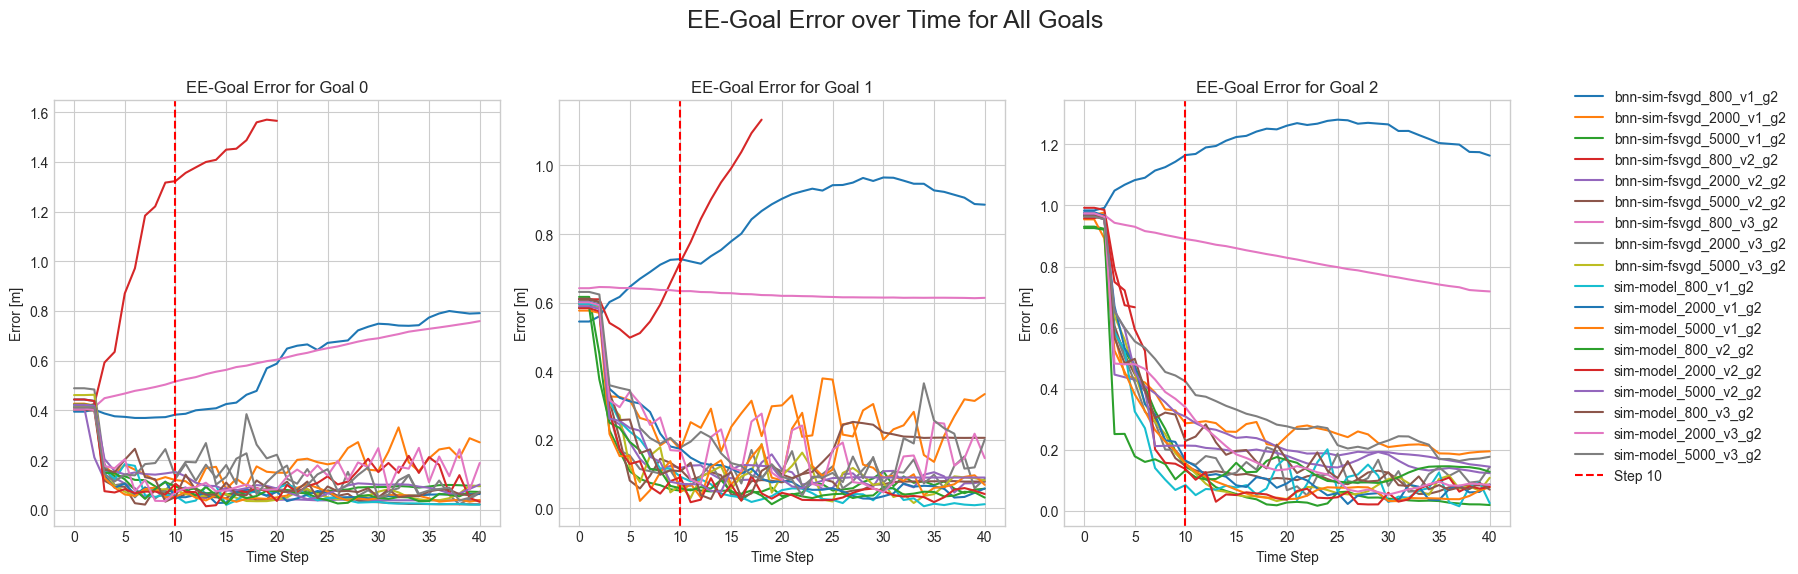

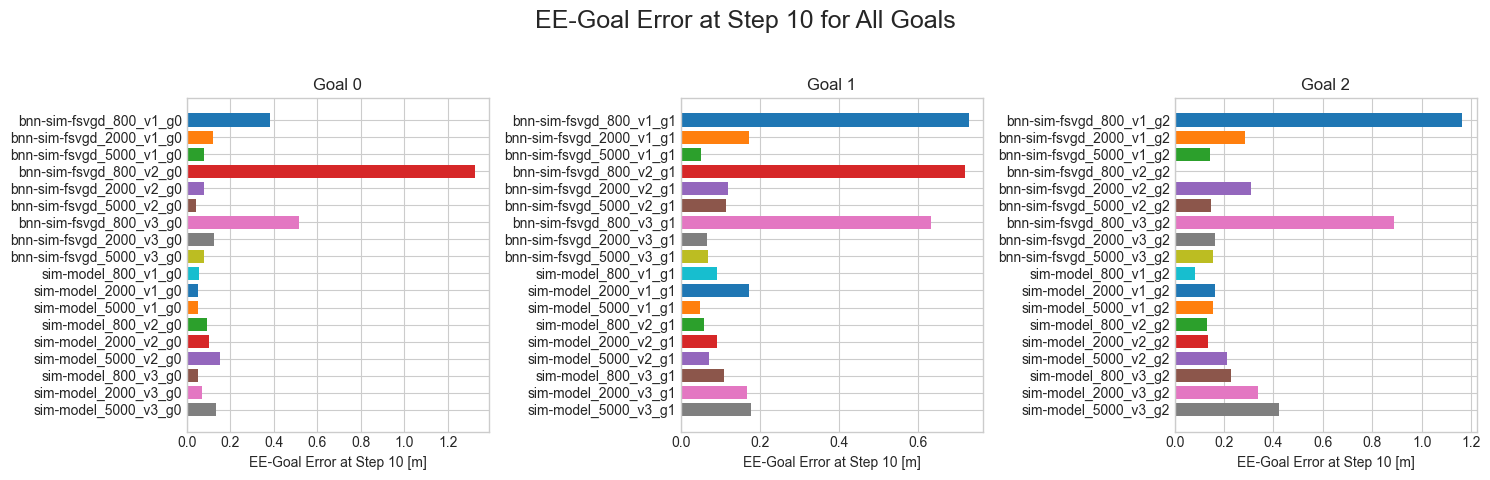

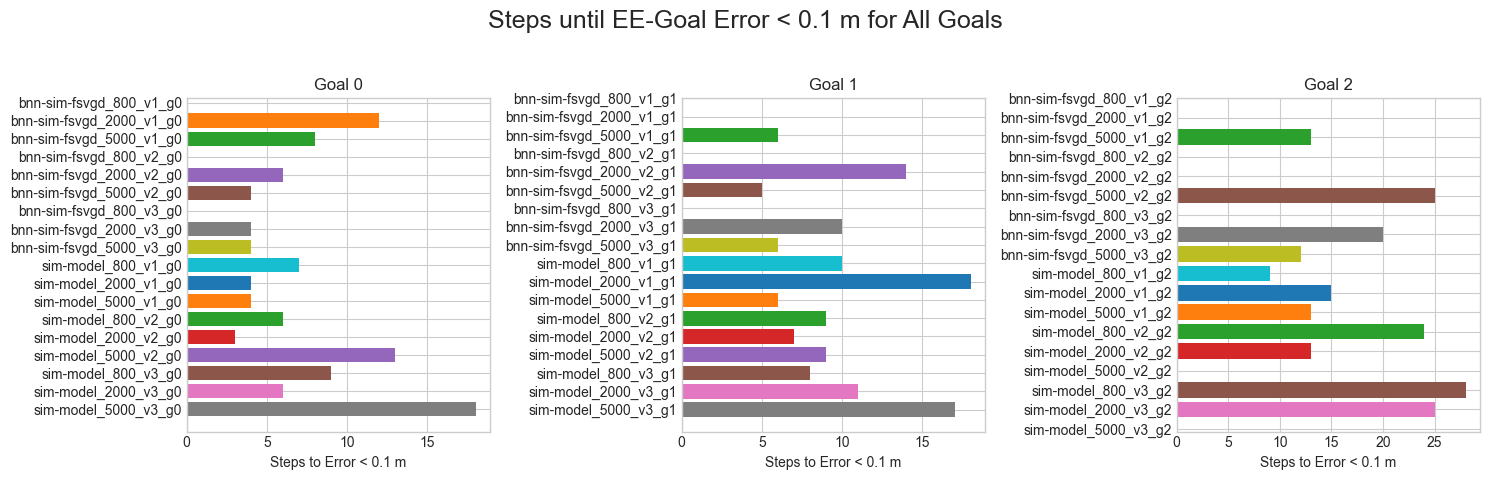

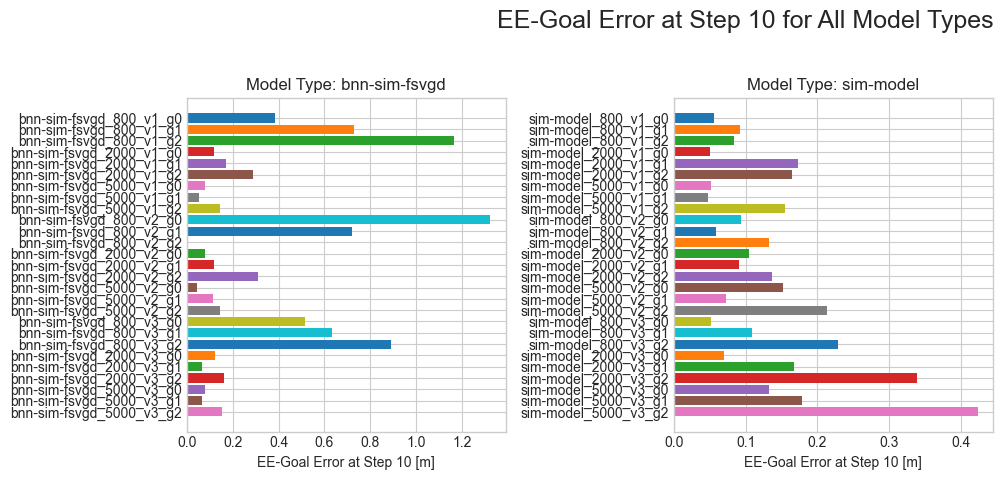

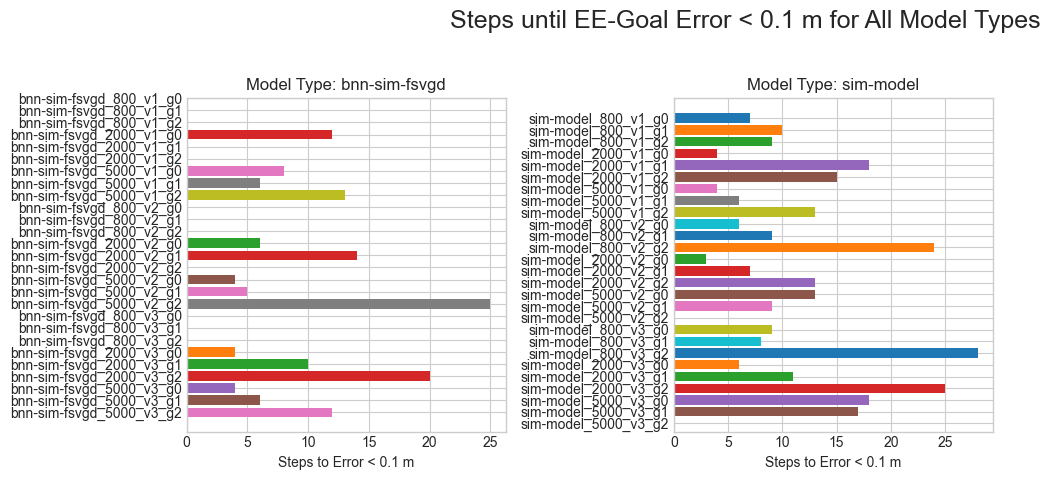

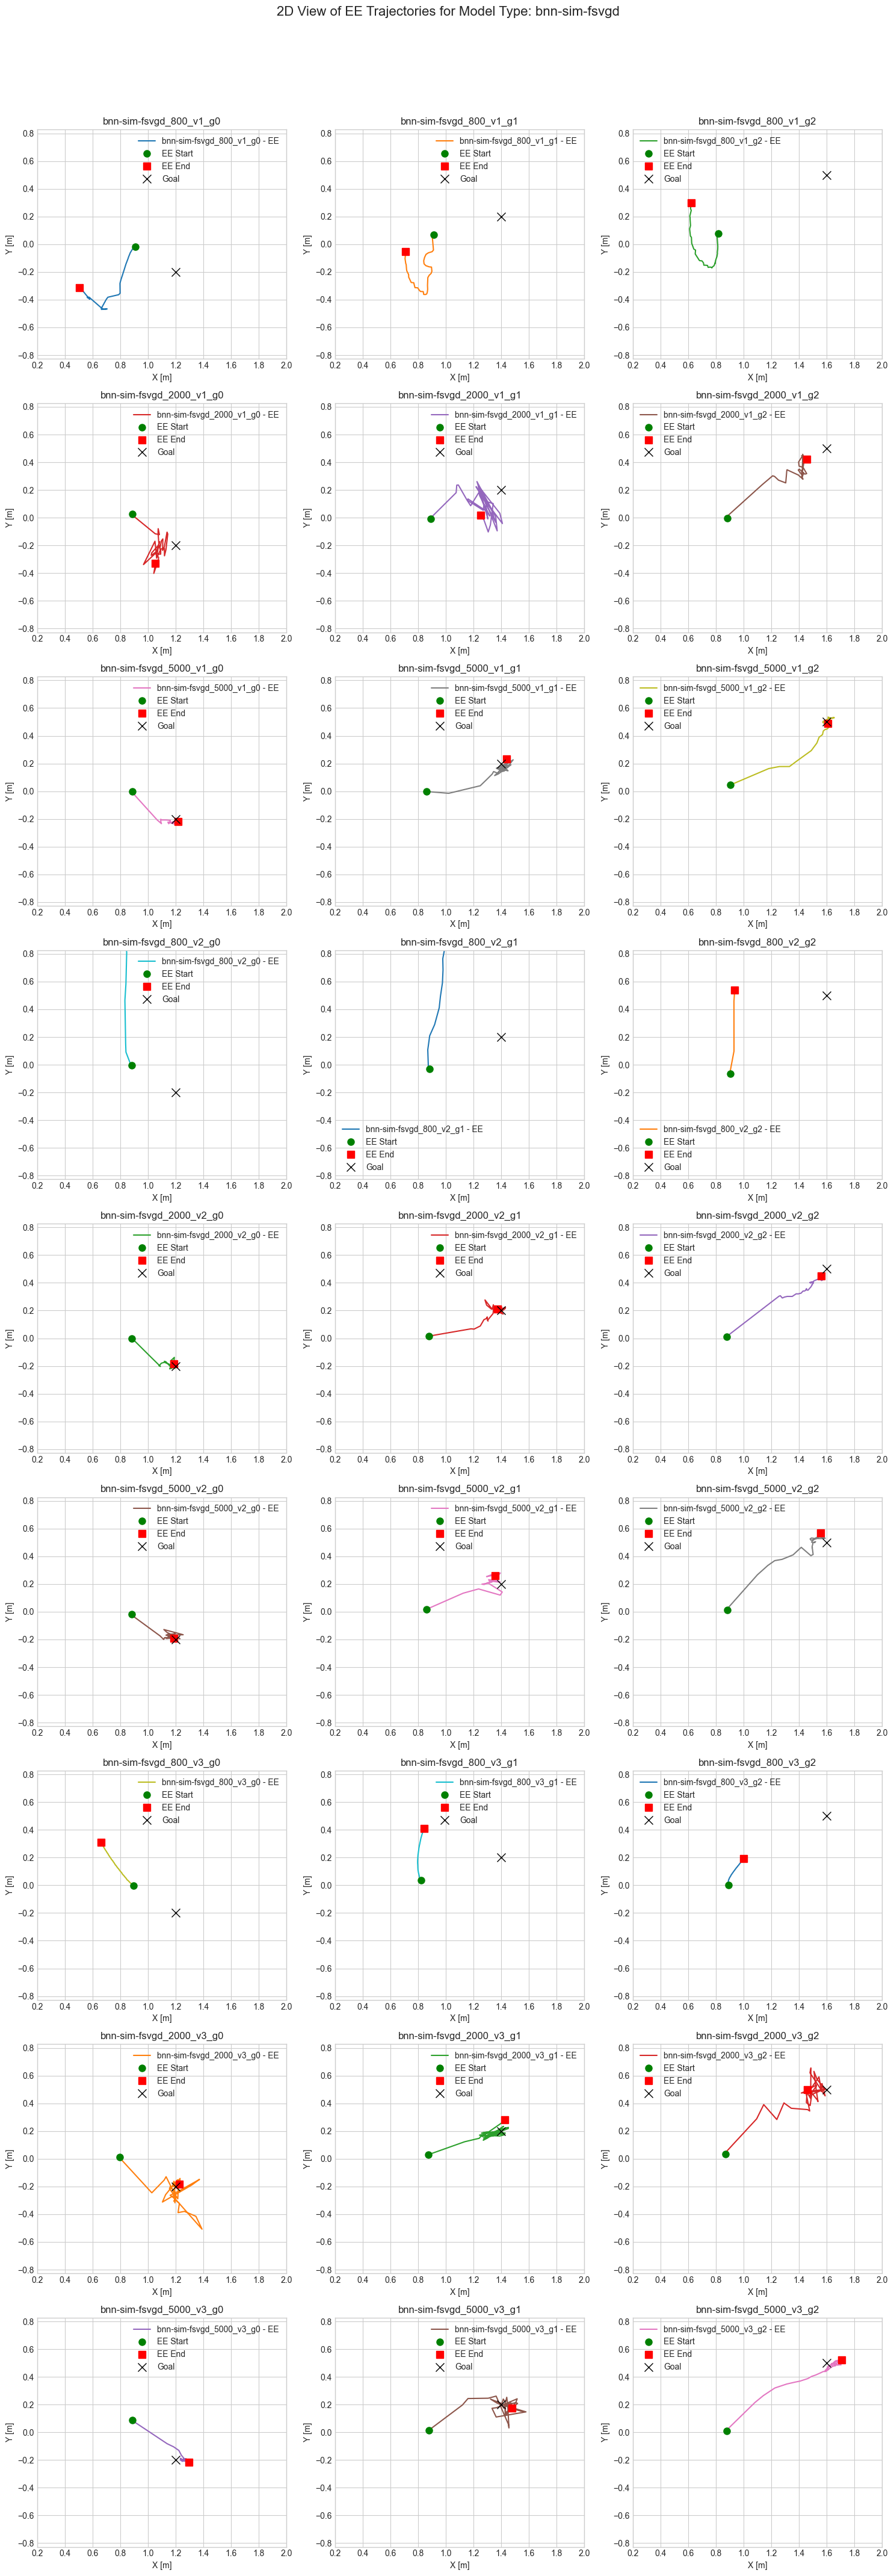

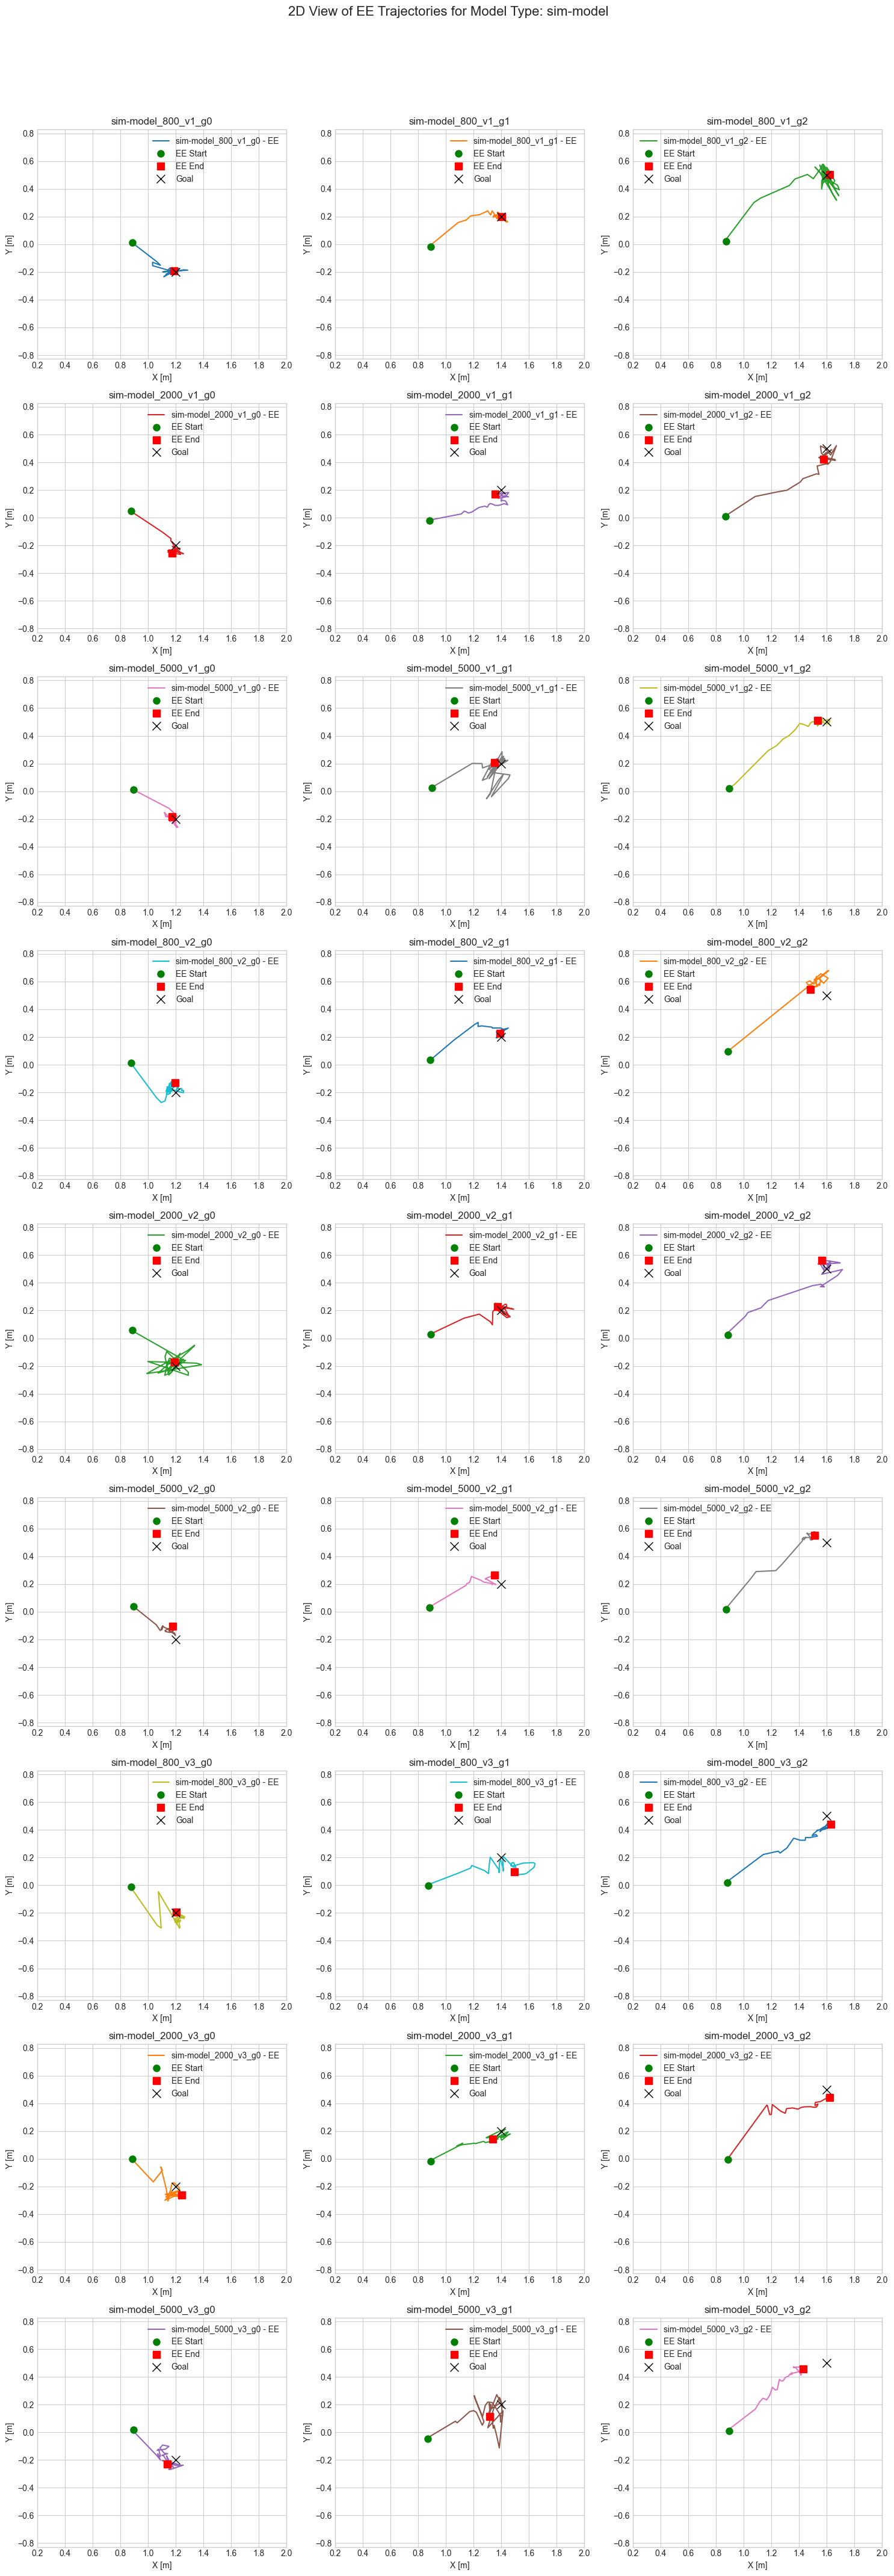

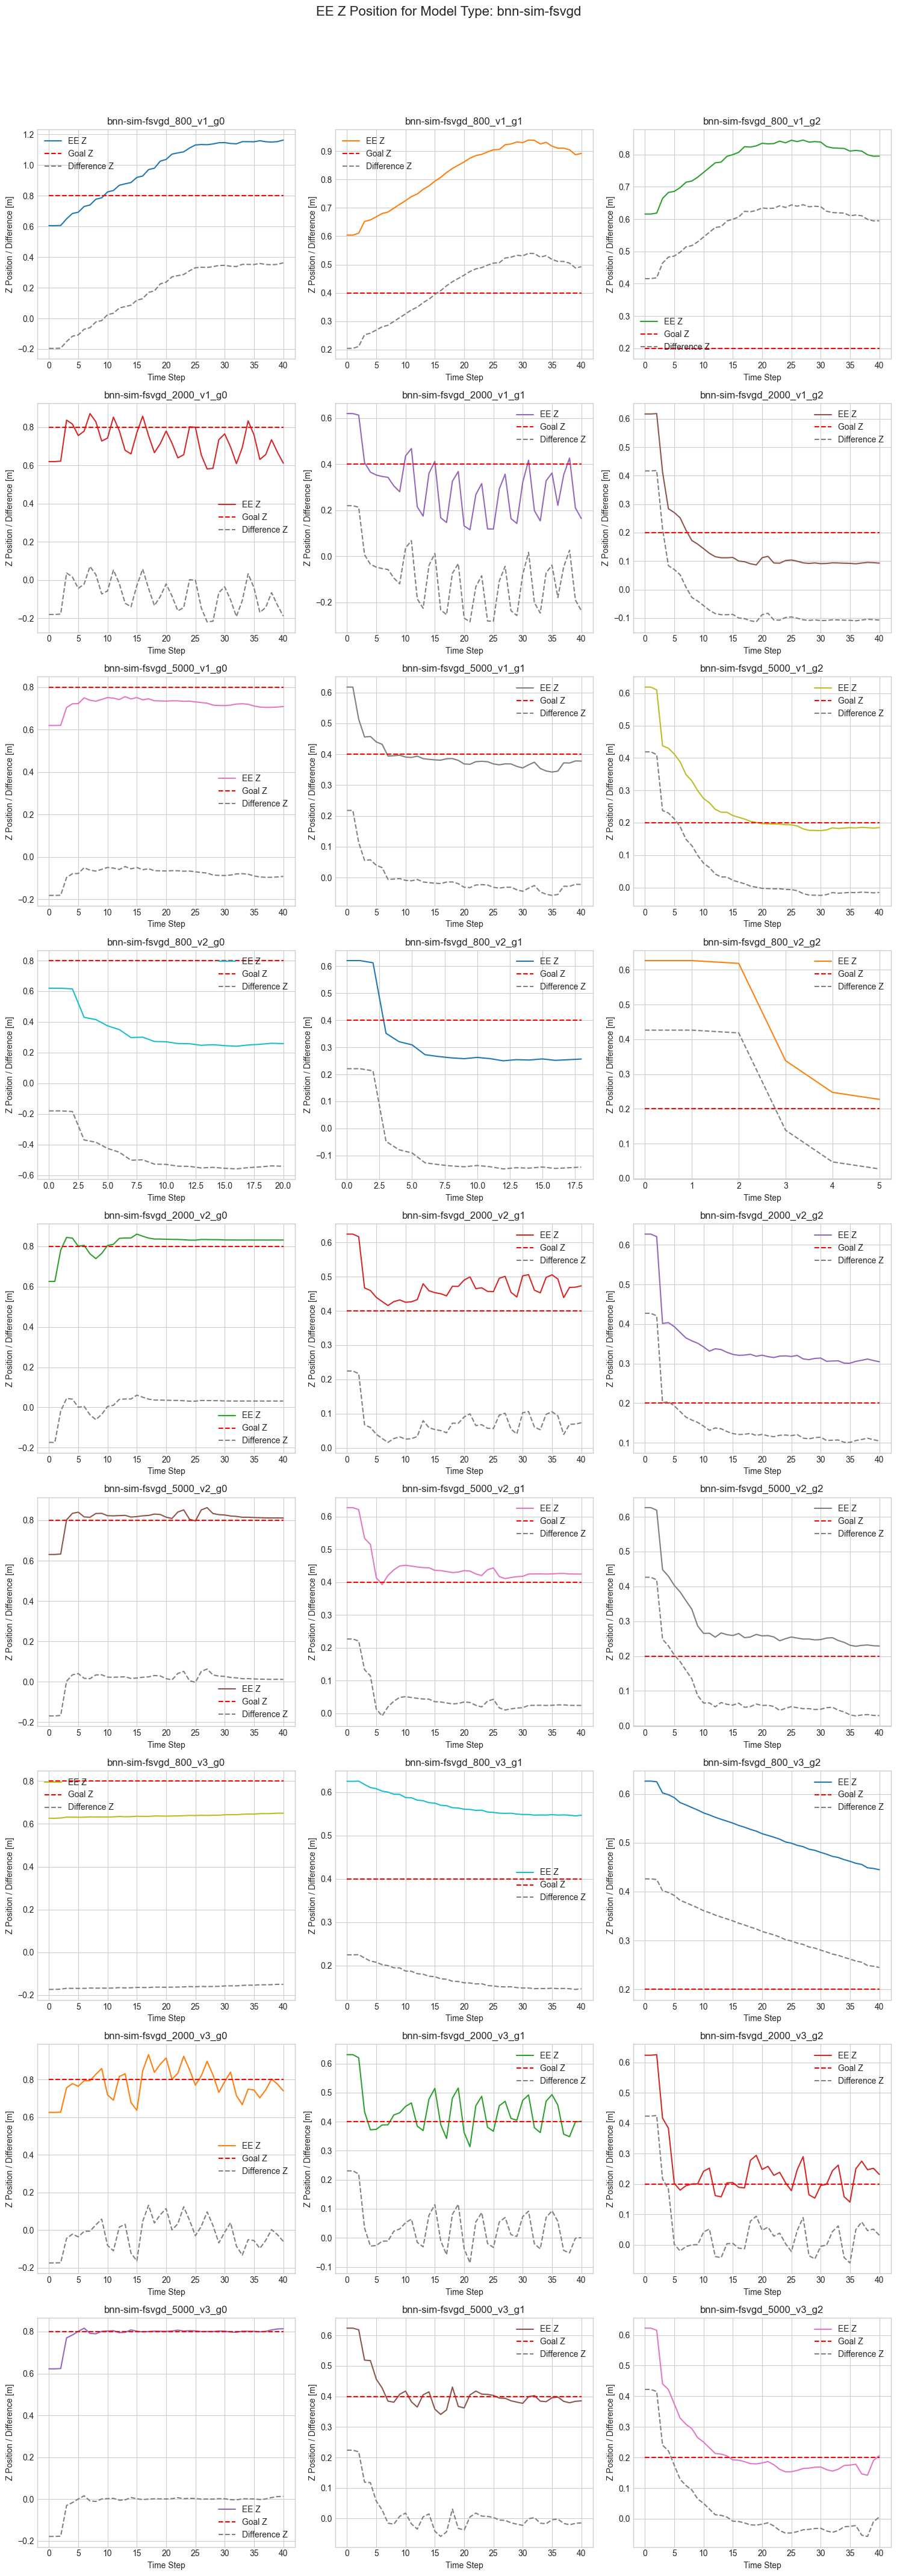

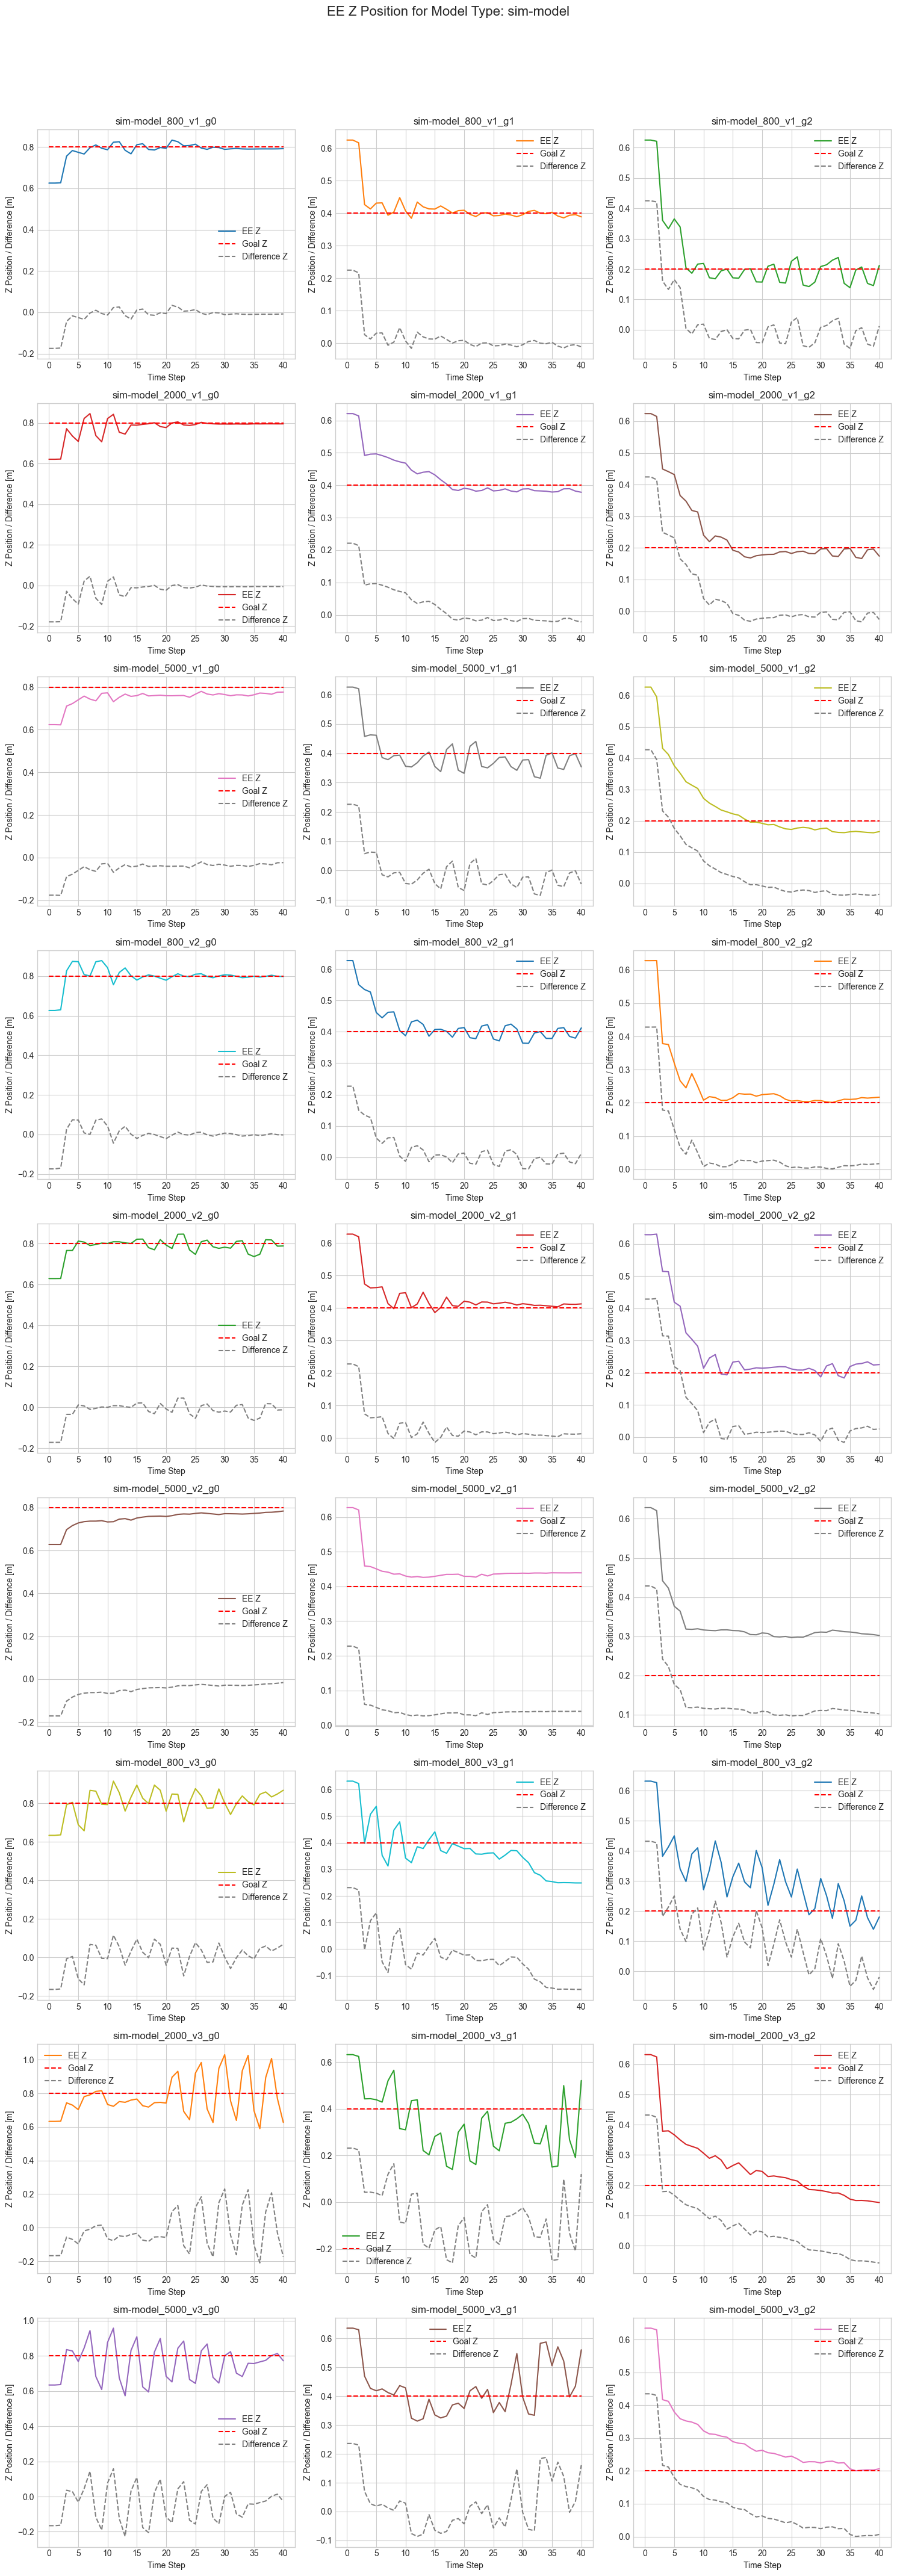

In [1]:
""" Full evaluation of policy performance on real robot """

import pickle
import numpy as np
import matplotlib.pyplot as plt
from sim_transfer.sims.util import decode_angles
from brax.training.types import Transition
import jax.tree_util as jtu
import jax.numpy as jnp
import re
import os

# Use a style for better aesthetics
plt.style.use("seaborn-v0_8-whitegrid")

# Global variables
step_index = 10  # Define the step index for error calculation
error_threshold = 0.1  # Threshold for EE-Goal error
plot_analysis = False  # Set to True to enable 'Analysis for Goal x' plots

# Define the list of trajectory files
file_paths = [
    # new policy_testing_full_v9_0.3
    # bnn_sim_fsvgd
    # seed 1
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134202_policy_testing_full_v9_0q0aqecs_bnn-sim-fsvgd_800_1_0__1.0/brax_transitions.pickle",
    # # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134300_policy_testing_full_v9_0q0aqecs_bnn-sim-fsvgd_800_1_2__1.0/brax_transitions.pickle",
    # # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134355_policy_testing_full_v9_0q0aqecs_bnn-sim-fsvgd_800_1_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134447_policy_testing_full_v9_a95frpg8_bnn-sim-fsvgd_2000_1_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134538_policy_testing_full_v9_a95frpg8_bnn-sim-fsvgd_2000_1_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134630_policy_testing_full_v9_a95frpg8_bnn-sim-fsvgd_2000_1_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134723_policy_testing_full_v9_qmvdd08w_bnn-sim-fsvgd_5000_1_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134822_policy_testing_full_v9_qmvdd08w_bnn-sim-fsvgd_5000_1_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134908_policy_testing_full_v9_qmvdd08w_bnn-sim-fsvgd_5000_1_2__1.0/brax_transitions.pickle",
    # # seed 2
    # # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-135020_policy_testing_full_v9_b1lrv5tz_bnn-sim-fsvgd_800_2_0__1.0/brax_transitions.pickle",
    # # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-135058_policy_testing_full_v9_b1lrv5tz_bnn-sim-fsvgd_800_2_1__1.0/brax_transitions.pickle",
    # # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-135138_policy_testing_full_v9_b1lrv5tz_bnn-sim-fsvgd_800_2_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-135423_policy_testing_full_v9_4bmmv080_bnn-sim-fsvgd_2000_2_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-135509_policy_testing_full_v9_4bmmv080_bnn-sim-fsvgd_2000_2_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-135648_policy_testing_full_v9_4bmmv080_bnn-sim-fsvgd_2000_2_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-135750_policy_testing_full_v9_tr3lhgrh_bnn-sim-fsvgd_5000_2_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-135848_policy_testing_full_v9_tr3lhgrh_bnn-sim-fsvgd_5000_2_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-135945_policy_testing_full_v9_tr3lhgrh_bnn-sim-fsvgd_5000_2_2__1.0/brax_transitions.pickle",
    # # seed 3
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-142040_policy_testing_full_v9_98lebqap_bnn-sim-fsvgd_800_3_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-142126_policy_testing_full_v9_98lebqap_bnn-sim-fsvgd_800_3_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-142210_policy_testing_full_v9_98lebqap_bnn-sim-fsvgd_800_3_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-142327_policy_testing_full_v9_rp7t77og_bnn-sim-fsvgd_2000_3_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-142423_policy_testing_full_v9_rp7t77og_bnn-sim-fsvgd_2000_3_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-142533_policy_testing_full_v9_rp7t77og_bnn-sim-fsvgd_2000_3_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-142627_policy_testing_full_v9_8z265p8u_bnn-sim-fsvgd_5000_3_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-142719_policy_testing_full_v9_8z265p8u_bnn-sim-fsvgd_5000_3_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-142805_policy_testing_full_v9_8z265p8u_bnn-sim-fsvgd_5000_3_2__1.0/brax_transitions.pickle",

    # # sim_model
    # # seed 1
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-143536_policy_testing_full_v9_7539krvw_sim-model_800_1_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-143644_policy_testing_full_v9_7539krvw_sim-model_800_1_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-143736_policy_testing_full_v9_7539krvw_sim-model_800_1_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-143829_policy_testing_full_v9_9ojnkqii_sim-model_2000_1_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-143926_policy_testing_full_v9_9ojnkqii_sim-model_2000_1_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-144021_policy_testing_full_v9_9ojnkqii_sim-model_2000_1_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-144111_policy_testing_full_v9_pnqivxba_sim-model_5000_1_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-144201_policy_testing_full_v9_pnqivxba_sim-model_5000_1_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145002_policy_testing_full_v9_pnqivxba_sim-model_5000_1_2__1.0/brax_transitions.pickle",

    # # seed 2
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145111_policy_testing_full_v9_dwb45l5k_sim-model_800_2_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145155_policy_testing_full_v9_dwb45l5k_sim-model_800_2_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145248_policy_testing_full_v9_dwb45l5k_sim-model_800_2_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145340_policy_testing_full_v9_7c7ai1vy_sim-model_2000_2_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145428_policy_testing_full_v9_7c7ai1vy_sim-model_2000_2_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145531_policy_testing_full_v9_7c7ai1vy_sim-model_2000_2_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145630_policy_testing_full_v9_p50dxhru_sim-model_5000_2_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145722_policy_testing_full_v9_p50dxhru_sim-model_5000_2_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145811_policy_testing_full_v9_p50dxhru_sim-model_5000_2_2__1.0/brax_transitions.pickle",

    # # seed 3
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145910_policy_testing_full_v9_tcq7z9kw_sim-model_800_3_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145958_policy_testing_full_v9_tcq7z9kw_sim-model_800_3_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-150049_policy_testing_full_v9_tcq7z9kw_sim-model_800_3_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-150135_policy_testing_full_v9_7w0tt85r_sim-model_2000_3_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-150223_policy_testing_full_v9_7w0tt85r_sim-model_2000_3_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-150311_policy_testing_full_v9_7w0tt85r_sim-model_2000_3_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-150400_policy_testing_full_v9_fac8woya_sim-model_5000_3_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-150453_policy_testing_full_v9_fac8woya_sim-model_5000_3_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-150542_policy_testing_full_v9_fac8woya_sim-model_5000_3_2__1.0/brax_transitions.pickle",


    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-114808_policy_testing_full_v9_0q0aqecs_bnn-sim-fsvgd_800_1_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-115812_policy_testing_full_v9_qmvdd08w_bnn-sim-fsvgd_5000_1_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-115717_policy_testing_full_v9_qmvdd08w_bnn-sim-fsvgd_5000_1_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-115628_policy_testing_full_v9_qmvdd08w_bnn-sim-fsvgd_5000_1_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-115530_policy_testing_full_v9_a95frpg8_bnn-sim-fsvgd_2000_1_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-115440_policy_testing_full_v9_a95frpg8_bnn-sim-fsvgd_2000_1_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-115345_policy_testing_full_v9_a95frpg8_bnn-sim-fsvgd_2000_1_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-115213_policy_testing_full_v9_0q0aqecs_bnn-sim-fsvgd_800_1_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-114918_policy_testing_full_v9_0q0aqecs_bnn-sim-fsvgd_800_1_1__1.0/brax_transitions.pickle"

    # policy_testing_full_v9_new
    # bnn_sim_fsvgd
    # seed 1
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-122915_policy_testing_full_v9_0q0aqecs_bnn-sim-fsvgd_800_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123002_policy_testing_full_v9_0q0aqecs_bnn-sim-fsvgd_800_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123059_policy_testing_full_v9_0q0aqecs_bnn-sim-fsvgd_800_1_2__1.0/brax_transitions.pickle",

    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123128_policy_testing_full_v9_a95frpg8_bnn-sim-fsvgd_2000_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123214_policy_testing_full_v9_a95frpg8_bnn-sim-fsvgd_2000_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123304_policy_testing_full_v9_a95frpg8_bnn-sim-fsvgd_2000_1_2__1.0/brax_transitions.pickle",

    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123401_policy_testing_full_v9_qmvdd08w_bnn-sim-fsvgd_5000_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123441_policy_testing_full_v9_qmvdd08w_bnn-sim-fsvgd_5000_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123526_policy_testing_full_v9_qmvdd08w_bnn-sim-fsvgd_5000_1_2__1.0/brax_transitions.pickle",

    # seed 2
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123652_policy_testing_full_v9_b1lrv5tz_bnn-sim-fsvgd_800_2_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123736_policy_testing_full_v9_b1lrv5tz_bnn-sim-fsvgd_800_2_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123812_policy_testing_full_v9_b1lrv5tz_bnn-sim-fsvgd_800_2_2__1.0/brax_transitions.pickle",
    
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123851_policy_testing_full_v9_4bmmv080_bnn-sim-fsvgd_2000_2_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123942_policy_testing_full_v9_4bmmv080_bnn-sim-fsvgd_2000_2_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124028_policy_testing_full_v9_4bmmv080_bnn-sim-fsvgd_2000_2_2__1.0/brax_transitions.pickle",

    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124113_policy_testing_full_v9_tr3lhgrh_bnn-sim-fsvgd_5000_2_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124157_policy_testing_full_v9_tr3lhgrh_bnn-sim-fsvgd_5000_2_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124301_policy_testing_full_v9_tr3lhgrh_bnn-sim-fsvgd_5000_2_2__1.0/brax_transitions.pickle",

    # seed 3
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124434_policy_testing_full_v9_98lebqap_bnn-sim-fsvgd_800_3_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124513_policy_testing_full_v9_98lebqap_bnn-sim-fsvgd_800_3_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124601_policy_testing_full_v9_98lebqap_bnn-sim-fsvgd_800_3_2__1.0/brax_transitions.pickle",

    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124655_policy_testing_full_v9_rp7t77og_bnn-sim-fsvgd_2000_3_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124742_policy_testing_full_v9_rp7t77og_bnn-sim-fsvgd_2000_3_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124838_policy_testing_full_v9_rp7t77og_bnn-sim-fsvgd_2000_3_2__1.0/brax_transitions.pickle",

    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124929_policy_testing_full_v9_8z265p8u_bnn-sim-fsvgd_5000_3_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125016_policy_testing_full_v9_8z265p8u_bnn-sim-fsvgd_5000_3_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125105_policy_testing_full_v9_8z265p8u_bnn-sim-fsvgd_5000_3_2__1.0/brax_transitions.pickle",

    # sim_model
    # seed 1
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125223_policy_testing_full_v9_7539krvw_sim-model_800_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125308_policy_testing_full_v9_7539krvw_sim-model_800_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125348_policy_testing_full_v9_7539krvw_sim-model_800_1_2__1.0/brax_transitions.pickle",

    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125446_policy_testing_full_v9_9ojnkqii_sim-model_2000_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125533_policy_testing_full_v9_9ojnkqii_sim-model_2000_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125617_policy_testing_full_v9_9ojnkqii_sim-model_2000_1_2__1.0/brax_transitions.pickle",

    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125702_policy_testing_full_v9_pnqivxba_sim-model_5000_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125747_policy_testing_full_v9_pnqivxba_sim-model_5000_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125832_policy_testing_full_v9_pnqivxba_sim-model_5000_1_2__1.0/brax_transitions.pickle",

    # seed 2
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130234_policy_testing_full_v9_dwb45l5k_sim-model_800_2_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130315_policy_testing_full_v9_dwb45l5k_sim-model_800_2_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130359_policy_testing_full_v9_dwb45l5k_sim-model_800_2_2__1.0/brax_transitions.pickle",

    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130445_policy_testing_full_v9_7c7ai1vy_sim-model_2000_2_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130534_policy_testing_full_v9_7c7ai1vy_sim-model_2000_2_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130616_policy_testing_full_v9_7c7ai1vy_sim-model_2000_2_2__1.0/brax_transitions.pickle",

    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130704_policy_testing_full_v9_p50dxhru_sim-model_5000_2_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130744_policy_testing_full_v9_p50dxhru_sim-model_5000_2_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130828_policy_testing_full_v9_p50dxhru_sim-model_5000_2_2__1.0/brax_transitions.pickle",

    # seed 3
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131057_policy_testing_full_v9_tcq7z9kw_sim-model_800_3_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131139_policy_testing_full_v9_tcq7z9kw_sim-model_800_3_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131233_policy_testing_full_v9_tcq7z9kw_sim-model_800_3_2__1.0/brax_transitions.pickle",

    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131317_policy_testing_full_v9_7w0tt85r_sim-model_2000_3_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131411_policy_testing_full_v9_7w0tt85r_sim-model_2000_3_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131453_policy_testing_full_v9_7w0tt85r_sim-model_2000_3_2__1.0/brax_transitions.pickle",

    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131540_policy_testing_full_v9_fac8woya_sim-model_5000_3_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131622_policy_testing_full_v9_fac8woya_sim-model_5000_3_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131709_policy_testing_full_v9_fac8woya_sim-model_5000_3_2__1.0/brax_transitions.pickle",

    # bnn_fsvgd
    # seed 1


    
]

# Define your goals
goal_1 = np.array([1.2, -0.2, 0.8])
goal_2 = np.array([1.4, 0.2, 0.4])
goal_3 = np.array([1.6, 0.5, 0.2])

goals = [goal_1, goal_2, goal_3]

# Set global x and y limits for the 2D plots
x_limits = (0.2, 2.0)
y_limits = (-1.5, 1.5)

# Initialize dictionaries to store data per goal and per model type
goal_data = {}
model_data = {}


def extract_info_from_file_path(file_path):
    """Extract model info from file path."""
    dir_name = os.path.dirname(file_path)
    dir_base_name = os.path.basename(dir_name)
    parts = dir_base_name.split('_')

    # Find index of 8-character unique id
    for i in range(len(parts)):
        if re.match(r'^\w{8}$', parts[i]):
            uniqueid_parts = parts[:i+1]
            uniqueid = '_'.join(uniqueid_parts)
            rest_parts = parts[i+1:]
            break
    else:
        raise ValueError(f"Could not find unique id in file path {file_path}")

    if len(rest_parts) < 4:
        raise ValueError(f"Not enough parts in file path {file_path}")

    modeltype = rest_parts[0]
    samplesize = rest_parts[1]
    variant = rest_parts[2]
    goalindex = rest_parts[3]

    # Handle the double underscore
    params_and_rest = '_'.join(rest_parts[4:])
    params_split = params_and_rest.split('__')
    if len(params_split) == 2:
        params = params_split[1]
    else:
        # Try splitting by '_'
        params_split = params_and_rest.split('_')
        if len(params_split) >= 1:
            params = params_split[-1]
        else:
            params = ''

    return {
        'uniqueid': uniqueid,
        'modeltype': modeltype,
        'samplesize': samplesize,
        'variant': variant,
        'goalindex': goalindex,
        'params': params
    }


# Loop over each trajectory file
for idx, file_path in enumerate(file_paths):
    # Load trajectory from policy simulation
    with open(file_path, "rb") as file:
        traj_raw = pickle.load(file)

    # Extract info from file path
    info = extract_info_from_file_path(file_path)
    label = f"{info['modeltype']}_{info['samplesize']}_v{info['variant']}_g{info['goalindex']}"
    model_type = info['modeltype']

    # Extract goal index
    goal_index = int(info['goalindex'])
    if goal_index >= len(goals):
        raise ValueError(f"Goal index {goal_index} is out of bounds")

    goal = goals[goal_index]

    # Initialize data structures for this goal if not already done
    if goal_index not in goal_data:
        goal_data[goal_index] = {
            "file_paths": [],
            "labels": [],
            "observations": [],
            "actions": [],
            "rewards": [],
            "ee_goal_errors_at_step": [],
            "steps_below_threshold": [],
        }

    # Initialize data structures for this model type if not already done
    if model_type not in model_data:
        model_data[model_type] = {
            "labels": [],
            "observations": [],
            "actions": [],
            "rewards": [],
            "ee_goal_errors_at_step": [],
            "steps_below_threshold": [],
            "goals": [],
        }

    # Add goal to observations
    def add_goal_to_obs(obs: jnp.ndarray, goal: jnp.ndarray) -> jnp.ndarray:
        return jnp.concatenate([obs, goal])

    new_traj = []

    # Add goal to each observation in the trajectory
    for i in range(len(traj_raw)):
        obs = traj_raw[i].observation
        next_obs = traj_raw[i].next_observation
        obs = add_goal_to_obs(obs, goal)
        next_obs = add_goal_to_obs(next_obs, goal)
        new_traj.append(
            Transition(
                observation=obs,
                action=traj_raw[i].action,
                reward=jnp.array(0),
                next_observation=next_obs,
                discount=traj_raw[i].discount,
            )
        )

    traj = jtu.tree_map(lambda *xs: jnp.stack(xs, axis=0), *new_traj)

    # Convert transitions to trajectory
    observations = traj.observation
    actions = traj.action
    rewards = traj.reward

    # Decode angles if needed
    if observations.shape[-1] == 16:
        observations = decode_angles(observations, 2)

    # Convert observations to numpy array
    observations_np = np.array(observations)

    # Calculate EE-Goal error over time
    ee_pos = observations_np[:, 6:9]
    goal_pos = observations_np[:, -3:]
    error = np.linalg.norm(ee_pos - goal_pos, axis=1)

    # EE-Goal error at step_index
    if len(error) > step_index:
        ee_goal_error_at_step = error[step_index]
    else:
        ee_goal_error_at_step = np.nan

    # Steps until error drops below threshold
    steps_below_threshold = np.where(error < error_threshold)[0]
    if steps_below_threshold.size > 0:
        steps_to_threshold = steps_below_threshold[0]
    else:
        steps_to_threshold = np.nan  # Did not reach threshold

    # Append data to the corresponding goal
    goal_data[goal_index]["file_paths"].append(file_path)
    goal_data[goal_index]["labels"].append(label)
    goal_data[goal_index]["observations"].append(observations_np)
    goal_data[goal_index]["actions"].append(np.array(actions))
    goal_data[goal_index]["rewards"].append(np.array(rewards))
    goal_data[goal_index]["ee_goal_errors_at_step"].append(ee_goal_error_at_step)
    goal_data[goal_index]["steps_below_threshold"].append(steps_to_threshold)

    # Append data to the corresponding model type
    model_data[model_type]["labels"].append(f"{label}")
    model_data[model_type]["observations"].append(observations_np)
    model_data[model_type]["actions"].append(np.array(actions))
    model_data[model_type]["rewards"].append(np.array(rewards))
    model_data[model_type]["ee_goal_errors_at_step"].append(ee_goal_error_at_step)
    model_data[model_type]["steps_below_threshold"].append(steps_to_threshold)
    model_data[model_type]["goals"].append(goal_index)


# Plotting functions

def plot_ee_2d_view_per_model(model_data, x_limits, y_limits):
    """Plot EE trajectories per model type with subplots for each version."""
    for model_type, data in model_data.items():
        observations = data["observations"]
        labels = data["labels"]
        num_models = len(observations)
        num_cols = 3
        num_rows = (num_models + num_cols - 1) // num_cols

        fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
        axs = axs.flatten()
        cmap = plt.get_cmap("tab10")

        for idx, obs in enumerate(observations):
            ax = axs[idx]
            color = cmap(idx % 10)
            label = labels[idx]
            # Plot EE trajectory
            ax.plot(obs[:, 6], obs[:, 7], label=f"{label} - EE", color=color)
            # Plot EE start and end points
            ax.plot(
                obs[0, 6], obs[0, 7], "o", color="green", markersize=8, label="EE Start"
            )
            ax.plot(
                obs[-1, 6], obs[-1, 7], "s", color="red", markersize=8, label="EE End"
            )
            # Plot goal position
            ax.plot(
                obs[0, -3], obs[0, -2], "x", color="black", markersize=10, label="Goal"
            )
            ax.set_title(f"{label}")
            ax.set_xlabel("X [m]")
            ax.set_ylabel("Y [m]")
            ax.axis("equal")
            ax.set_xlim(x_limits)
            ax.set_ylim(y_limits)
            ax.legend()
            ax.grid(True)

        # Hide any unused subplots
        for idx in range(len(observations), len(axs)):
            fig.delaxes(axs[idx])

        plt.suptitle(
            f"2D View of EE Trajectories for Model Type: {model_type}", fontsize=16
        )
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


def plot_ee_z_position_per_model(model_data):
    """Plot EE Z position per model type with subplots for each version."""
    for model_type, data in model_data.items():
        observations = data["observations"]
        labels = data["labels"]
        num_models = len(observations)
        num_cols = 3
        num_rows = (num_models + num_cols - 1) // num_cols

        fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
        axs = axs.flatten()
        cmap = plt.get_cmap("tab10")

        for idx, obs in enumerate(observations):
            ax = axs[idx]
            color = cmap(idx % 10)
            label = labels[idx]
            time_steps = np.arange(obs.shape[0])
            ee_z = obs[:, 8]
            goal_z = obs[0, -1]
            ax.plot(time_steps, ee_z, label=f"EE Z", color=color)
            ax.hlines(
                goal_z,
                time_steps[0],
                time_steps[-1],
                colors="r",
                linestyles="--",
                label="Goal Z",
            )
            diff_z = ee_z - goal_z
            ax.plot(
                time_steps, diff_z, linestyle="--", label=f"Difference Z", color="gray"
            )
            ax.set_title(f"{label}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Z Position / Difference [m]")
            ax.legend()
            ax.grid(True)

        # Hide any unused subplots
        for idx in range(len(observations), len(axs)):
            fig.delaxes(axs[idx])

        plt.suptitle(f"EE Z Position for Model Type: {model_type}", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


def plot_ee_goal_error(goal_data):
    """Plot EE-Goal Error over time with subplots for each goal."""
    num_goals = len(goal_data)
    num_cols = 3
    num_rows = (num_goals + num_cols - 1) // num_cols

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 6 * num_rows))
    axs = axs.flatten()
    cmap = plt.get_cmap("tab10")

    for idx, (goal_index, data) in enumerate(goal_data.items()):
        ax = axs[idx]
        observations = data["observations"]
        labels = data["labels"]
        for i, obs in enumerate(observations):
            color = cmap(i % 10)
            ee_pos = obs[:, 6:9]
            goal_pos = obs[:, -3:]
            error = np.linalg.norm(ee_pos - goal_pos, axis=1)
            time_steps = np.arange(len(error))
            ax.plot(time_steps, error, label=f"{labels[i]}", color=color)
        ax.axvline(step_index, color="r", linestyle="--", label=f"Step {step_index}")
        ax.set_title(f"EE-Goal Error for Goal {goal_index}")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Error [m]")
        ax.grid(True)
        if (idx + 1) % num_cols == 0 or idx == len(goal_data) - 1:
            # Add legend to the right of the last subplot in the row
            handles, labels_leg = ax.get_legend_handles_labels()
            fig.legend(handles, labels_leg, loc="center right")

    # Hide any unused subplots
    for idx in range(len(goal_data), len(axs)):
        fig.delaxes(axs[idx])

    plt.suptitle("EE-Goal Error over Time for All Goals", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 0.85, 0.95])  # Adjusted to make room for legend
    plt.show()


def plot_ee_goal_error_at_step(errors_per_goal, step_index):
    """Plot EE-Goal Error at a specific step with subplots per goal."""
    num_goals = len(errors_per_goal)
    num_cols = 3
    num_rows = (num_goals + num_cols - 1) // num_cols

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axs = axs.flatten()
    cmap = plt.get_cmap("tab10")

    for idx, (goal_index, data) in enumerate(errors_per_goal.items()):
        errors = data["ee_goal_errors_at_step"]
        labels_goal = data["labels"]
        y_positions = np.arange(len(labels_goal))
        colors = [cmap(i % 10) for i in range(len(labels_goal))]
        ax = axs[idx]
        ax.barh(y_positions, errors, align="center", color=colors)
        ax.set_yticks(y_positions)
        ax.set_yticklabels(labels_goal)
        ax.set_xlabel(f"EE-Goal Error at Step {step_index} [m]")
        ax.set_title(f"Goal {goal_index}")
        ax.invert_yaxis()
        ax.grid(True, axis="x")

    # Hide any unused subplots
    for idx in range(len(errors_per_goal), len(axs)):
        fig.delaxes(axs[idx])

    plt.suptitle(f"EE-Goal Error at Step {step_index} for All Goals", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def plot_steps_below_threshold(errors_per_goal, threshold):
    """Plot number of steps until EE-Goal error drops below threshold, with subplots per goal."""
    num_goals = len(errors_per_goal)
    num_cols = 3
    num_rows = (num_goals + num_cols - 1) // num_cols

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axs = axs.flatten()
    cmap = plt.get_cmap("tab10")

    for idx, (goal_index, data) in enumerate(errors_per_goal.items()):
        steps = data["steps_below_threshold"]
        labels_goal = data["labels"]
        y_positions = np.arange(len(labels_goal))
        colors = [cmap(i % 10) for i in range(len(labels_goal))]
        ax = axs[idx]
        ax.barh(y_positions, steps, align="center", color=colors)
        ax.set_yticks(y_positions)
        ax.set_yticklabels(labels_goal)
        ax.set_xlabel(f"Steps to Error < {threshold} m")
        ax.set_title(f"Goal {goal_index}")
        ax.invert_yaxis()
        ax.grid(True, axis="x")

    # Hide any unused subplots
    for idx in range(len(errors_per_goal), len(axs)):
        fig.delaxes(axs[idx])

    plt.suptitle(
        f"Steps until EE-Goal Error < {threshold} m for All Goals", fontsize=18
    )
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def plot_ee_goal_error_at_step_per_model(errors_per_model, step_index):
    """Plot EE-Goal Error at a specific step with subplots per model type."""
    num_models = len(errors_per_model)
    num_cols = 3
    num_rows = (num_models + num_cols - 1) // num_cols

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axs = axs.flatten()
    cmap = plt.get_cmap("tab10")

    for idx, (model_type, data) in enumerate(errors_per_model.items()):
        errors = data["ee_goal_errors_at_step"]
        labels_model = data["labels"]
        y_positions = np.arange(len(labels_model))
        colors = [cmap(i % 10) for i in range(len(labels_model))]
        ax = axs[idx]
        ax.barh(y_positions, errors, align="center", color=colors)
        ax.set_yticks(y_positions)
        ax.set_yticklabels(labels_model)
        ax.set_xlabel(f"EE-Goal Error at Step {step_index} [m]")
        ax.set_title(f"Model Type: {model_type}")
        ax.invert_yaxis()
        ax.grid(True, axis="x")

    # Hide any unused subplots
    for idx in range(len(errors_per_model), len(axs)):
        fig.delaxes(axs[idx])

    plt.suptitle(f"EE-Goal Error at Step {step_index} for All Model Types", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def plot_steps_below_threshold_per_model(errors_per_model, threshold):
    """Plot steps until EE-Goal error drops below threshold, with subplots per model type."""
    num_models = len(errors_per_model)
    num_cols = 3
    num_rows = (num_models + num_cols - 1) // num_cols

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axs = axs.flatten()
    cmap = plt.get_cmap("tab10")

    for idx, (model_type, data) in enumerate(errors_per_model.items()):
        steps = data["steps_below_threshold"]
        labels_model = data["labels"]
        y_positions = np.arange(len(labels_model))
        colors = [cmap(i % 10) for i in range(len(labels_model))]
        ax = axs[idx]
        ax.barh(y_positions, steps, align="center", color=colors)
        ax.set_yticks(y_positions)
        ax.set_yticklabels(labels_model)
        ax.set_xlabel(f"Steps to Error < {threshold} m")
        ax.set_title(f"Model Type: {model_type}")
        ax.invert_yaxis()
        ax.grid(True, axis="x")

    # Hide any unused subplots
    for idx in range(len(errors_per_model), len(axs)):
        fig.delaxes(axs[idx])

    plt.suptitle(
        f"Steps until EE-Goal Error < {threshold} m for All Model Types", fontsize=18
    )
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Now, perform the analysis per goal
# Collect ee_goal_errors_at_step per goal and per model type for plotting
errors_per_goal = {}
errors_per_model = {}

for goal_index, data in goal_data.items():
    print(f"Processing data for Goal {goal_index}")
    observations = data["observations"]
    actions = data["actions"]
    labels = data["labels"]
    ee_goal_errors_at_step = data["ee_goal_errors_at_step"]
    steps_below_threshold = data["steps_below_threshold"]
    rewards = data["rewards"]

    errors_per_goal[goal_index] = {
        "ee_goal_errors_at_step": ee_goal_errors_at_step,
        "steps_below_threshold": steps_below_threshold,
        "labels": labels,
    }

# Collect errors per model type
for model_type, data in model_data.items():
    errors_per_model[model_type] = {
        "ee_goal_errors_at_step": data["ee_goal_errors_at_step"],
        "steps_below_threshold": data["steps_below_threshold"],
        "labels": data["labels"],
        "goals": data["goals"],
    }

# Plot EE-Goal Error over time for all goals once
plot_ee_goal_error(goal_data)

# Plot EE-Goal Error at Step x using subplots for each goal
plot_ee_goal_error_at_step(errors_per_goal, step_index)

# Plot Steps until EE-Goal Error drops below threshold per goal
plot_steps_below_threshold(errors_per_goal, error_threshold)

# Plot EE-Goal Error at Step x grouping by model type
plot_ee_goal_error_at_step_per_model(errors_per_model, step_index)

# Plot Steps until EE-Goal Error drops below threshold per model type
plot_steps_below_threshold_per_model(errors_per_model, error_threshold)

# Plot EE 2D Trajectories per model type
plot_ee_2d_view_per_model(model_data, x_limits, y_limits)

# Plot EE Z Position per model type
plot_ee_z_position_per_model(model_data)


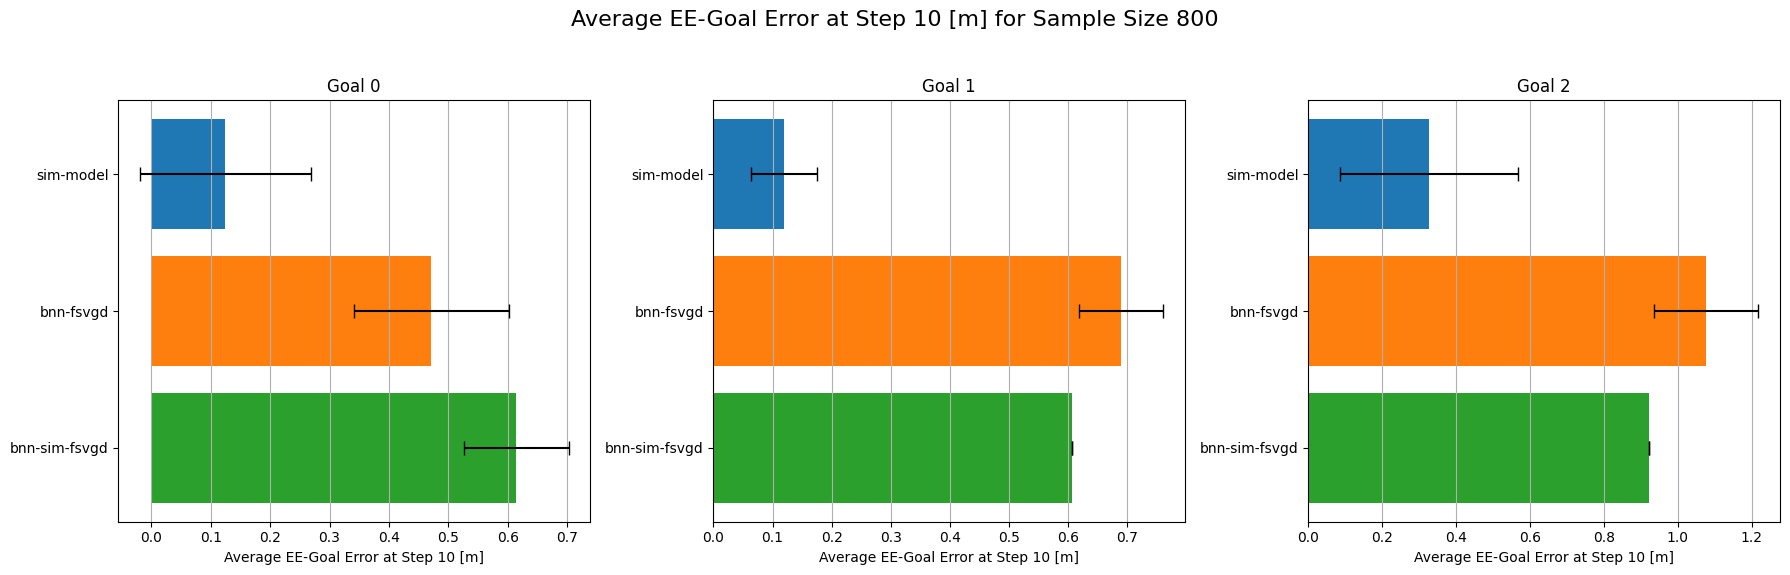

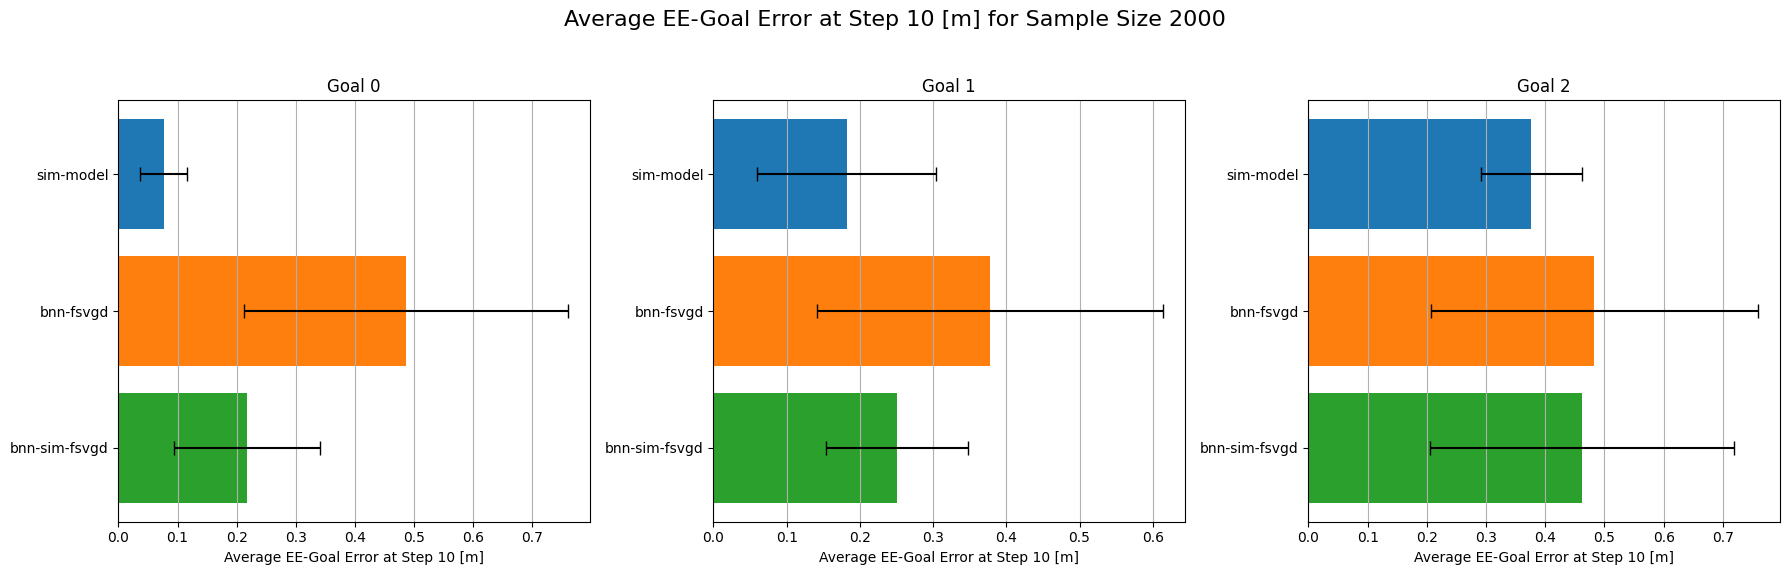

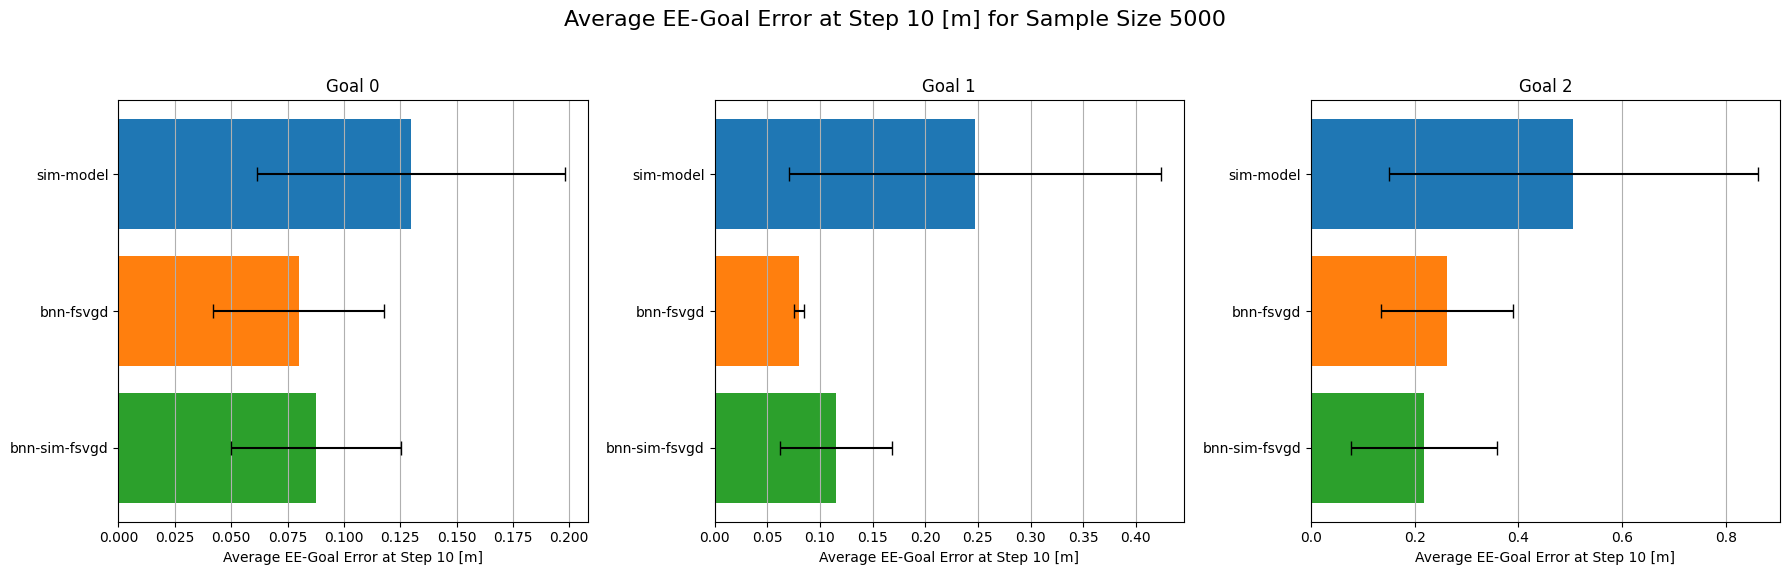

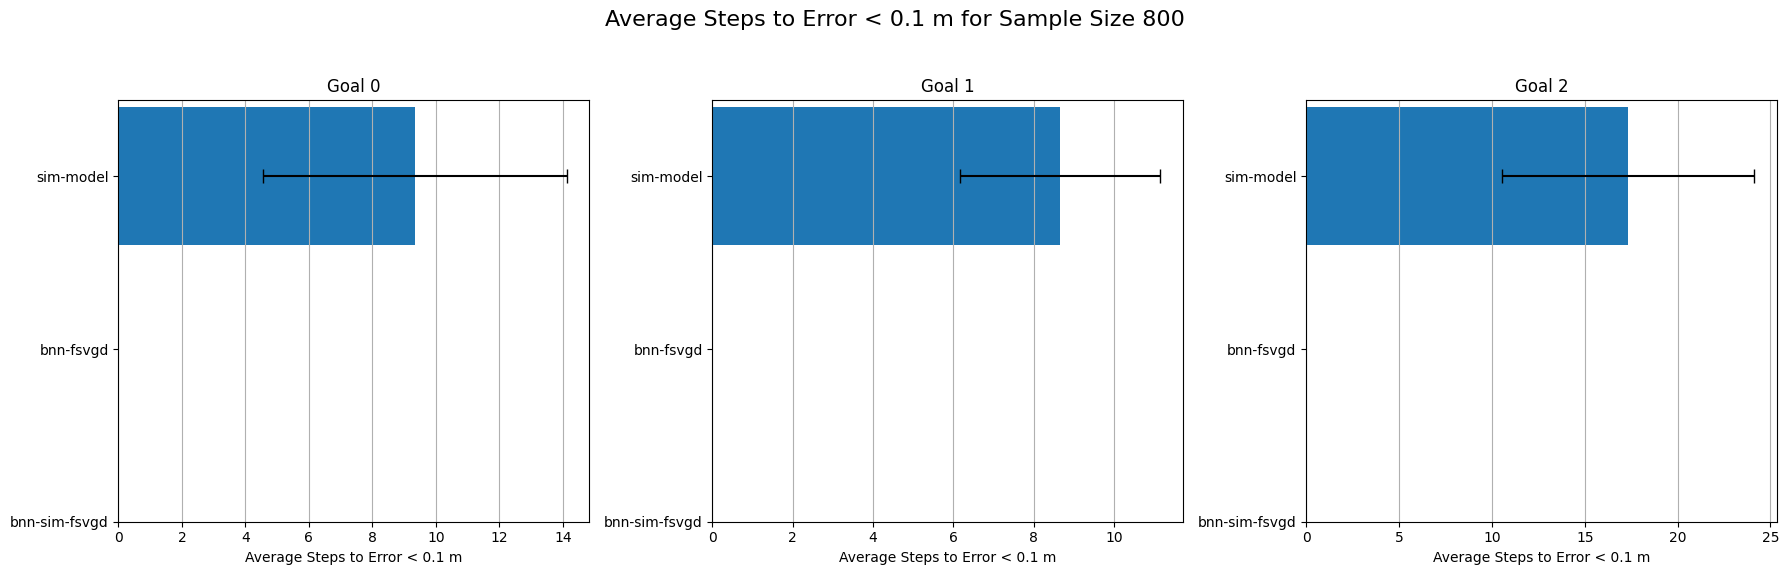

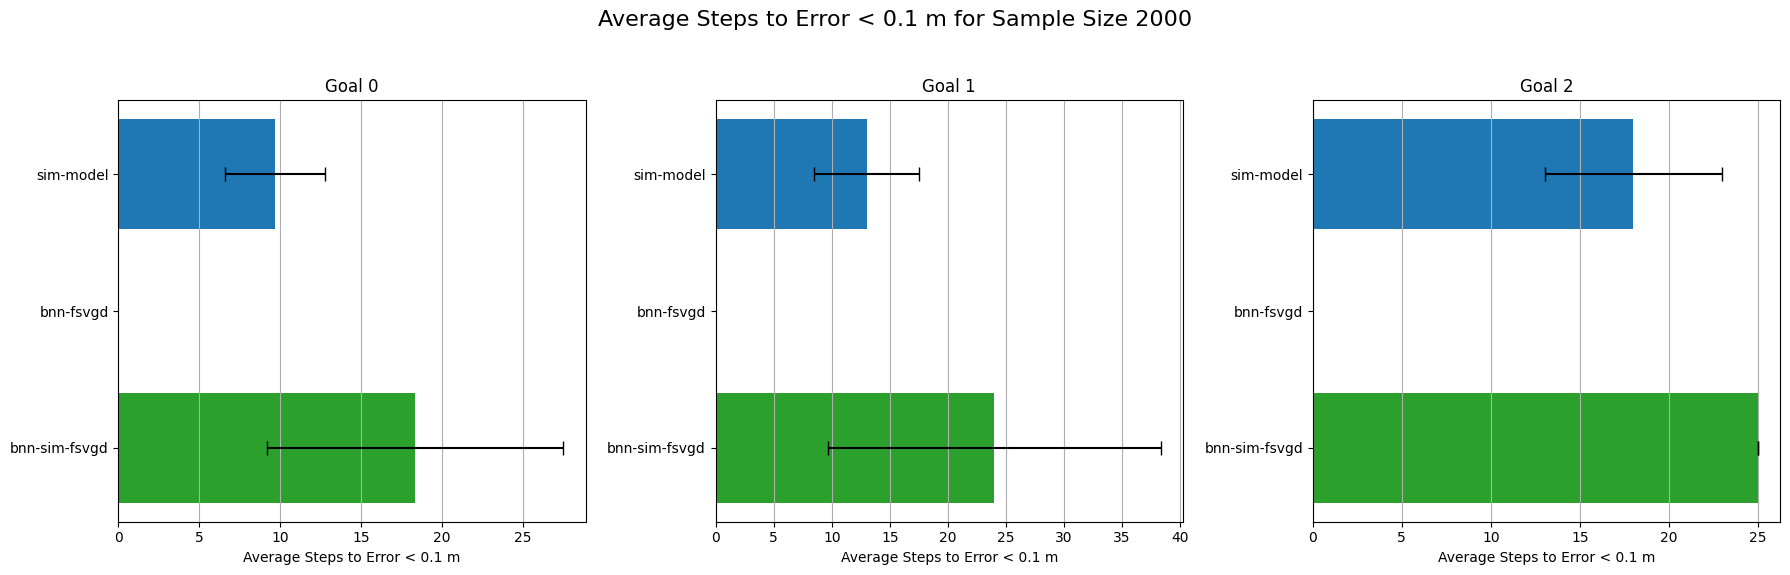

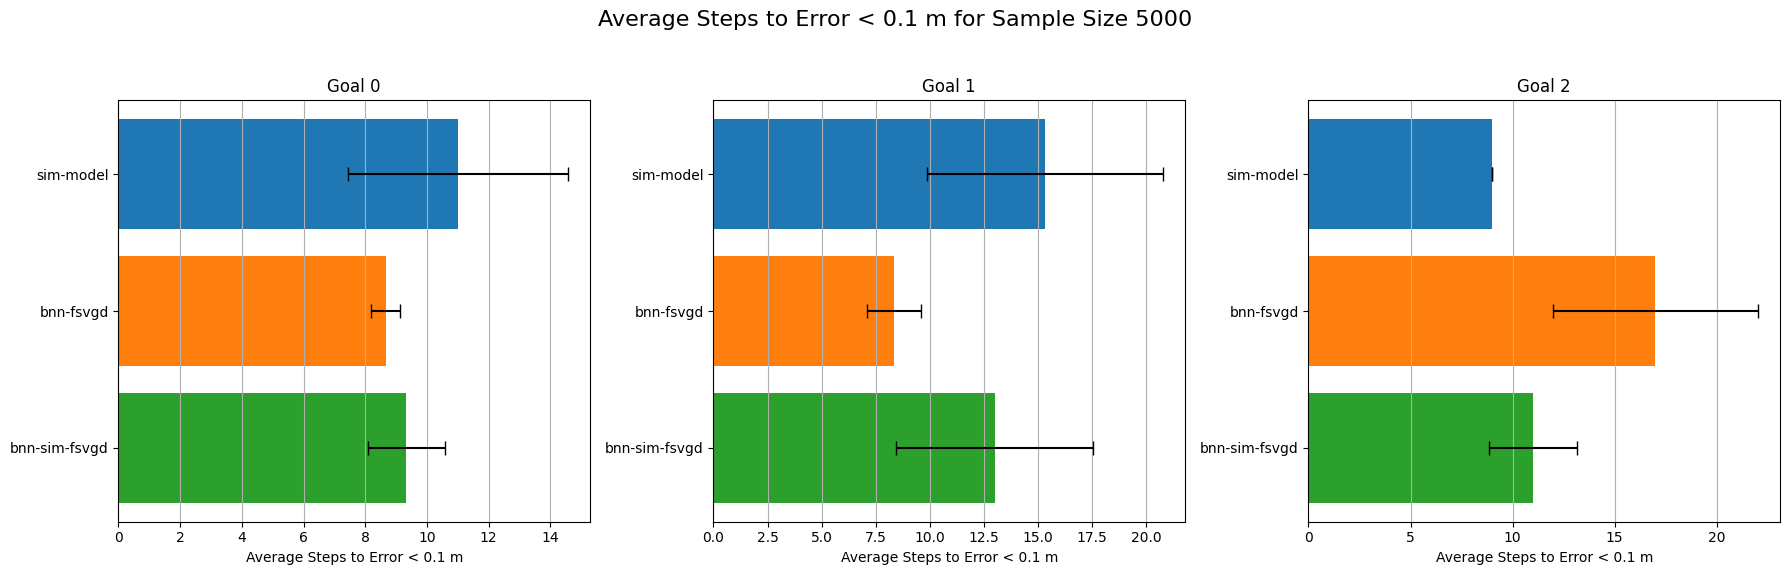

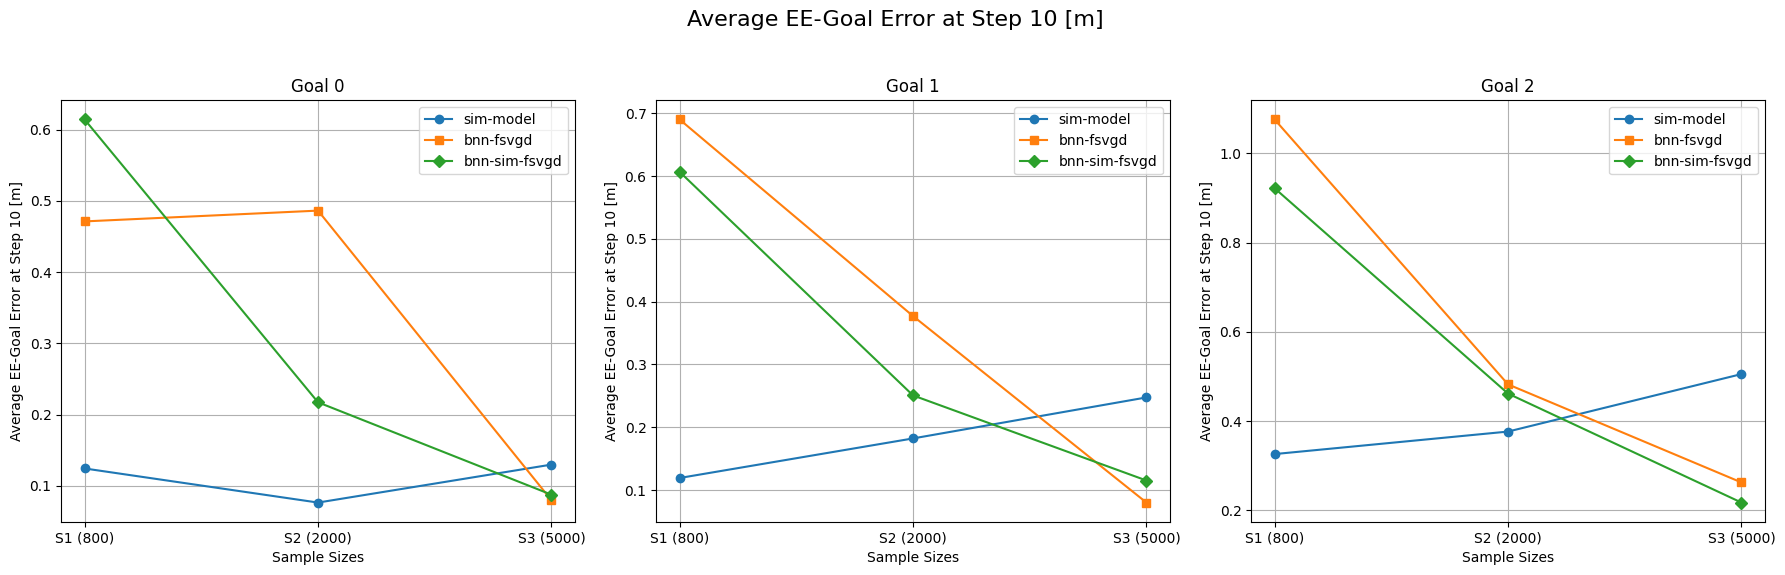

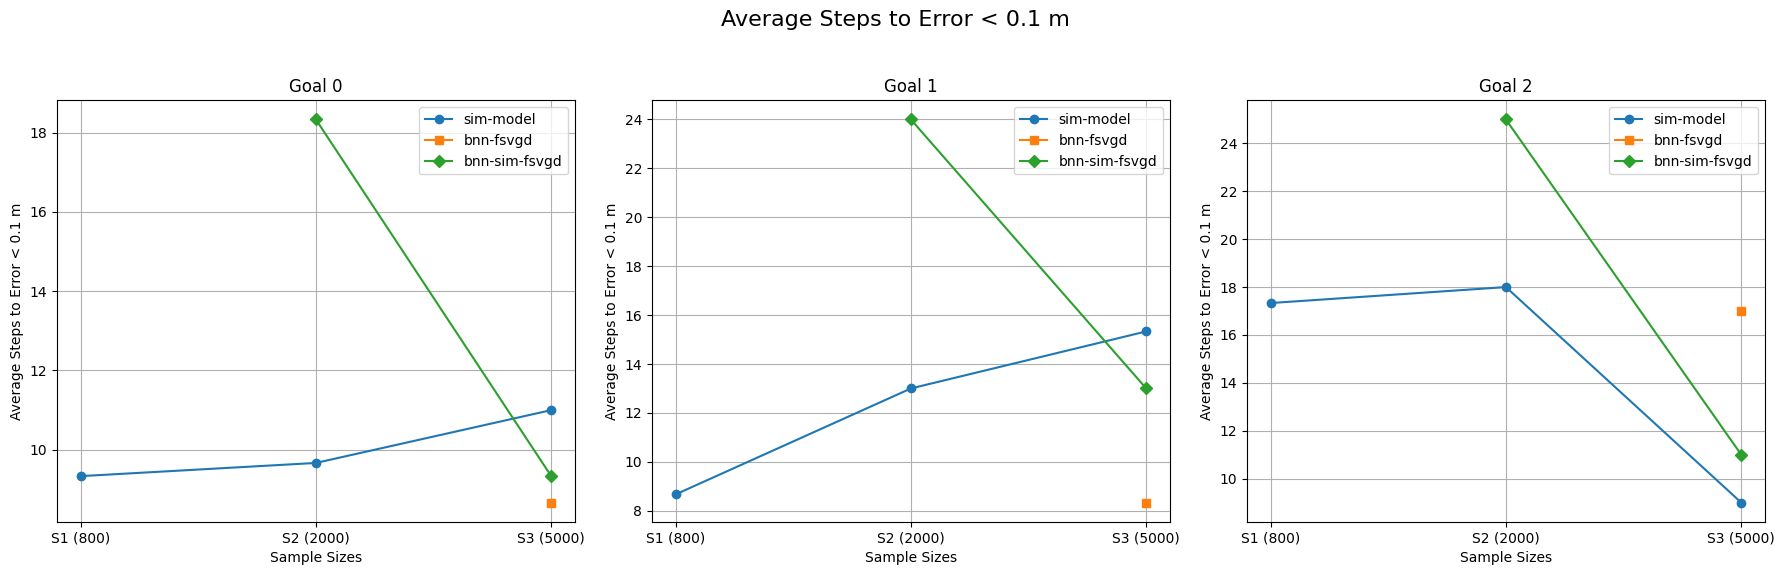

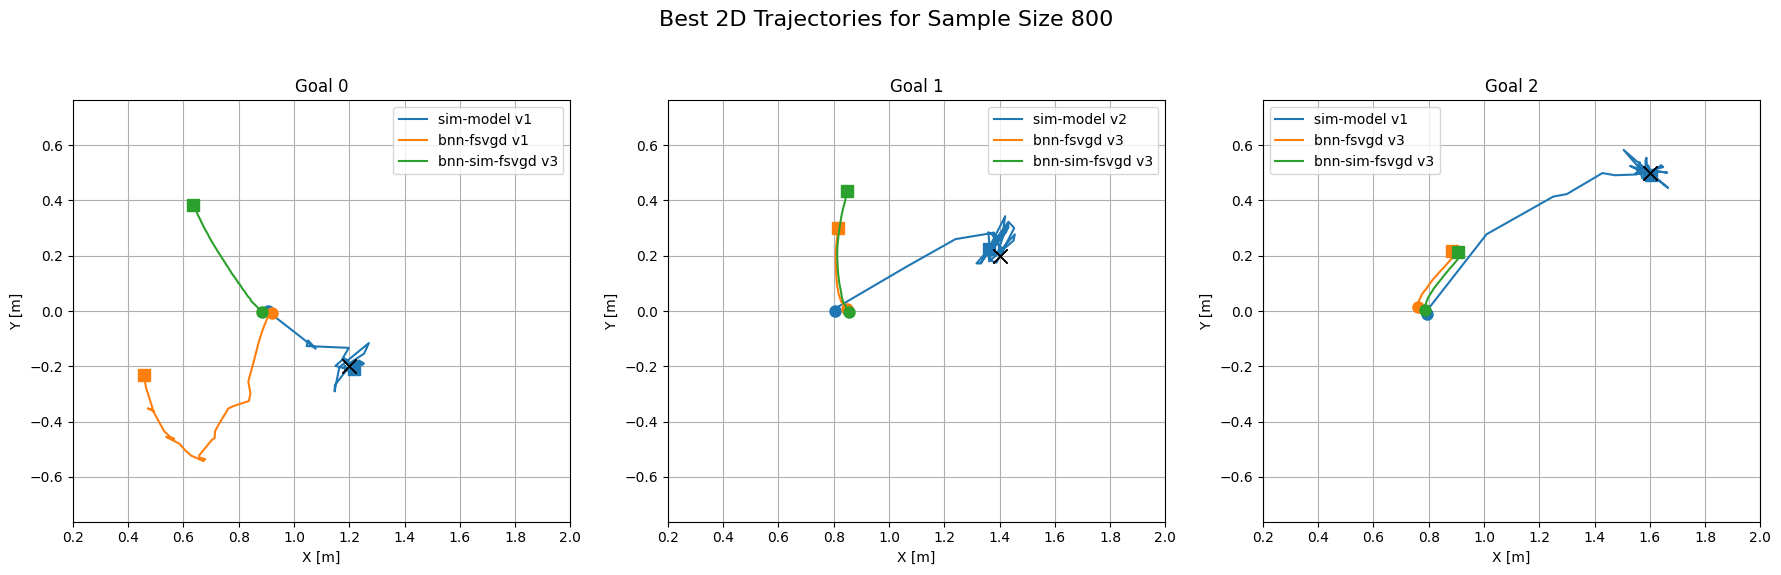

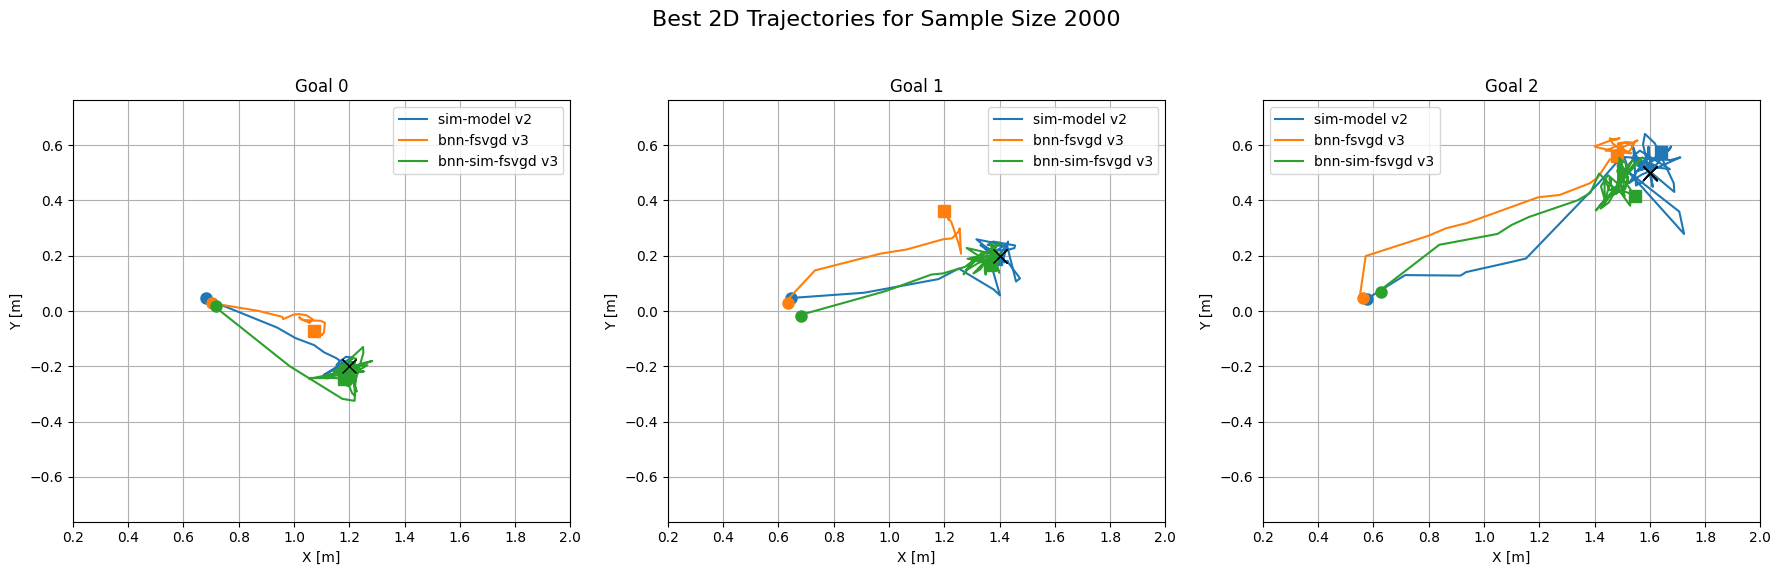

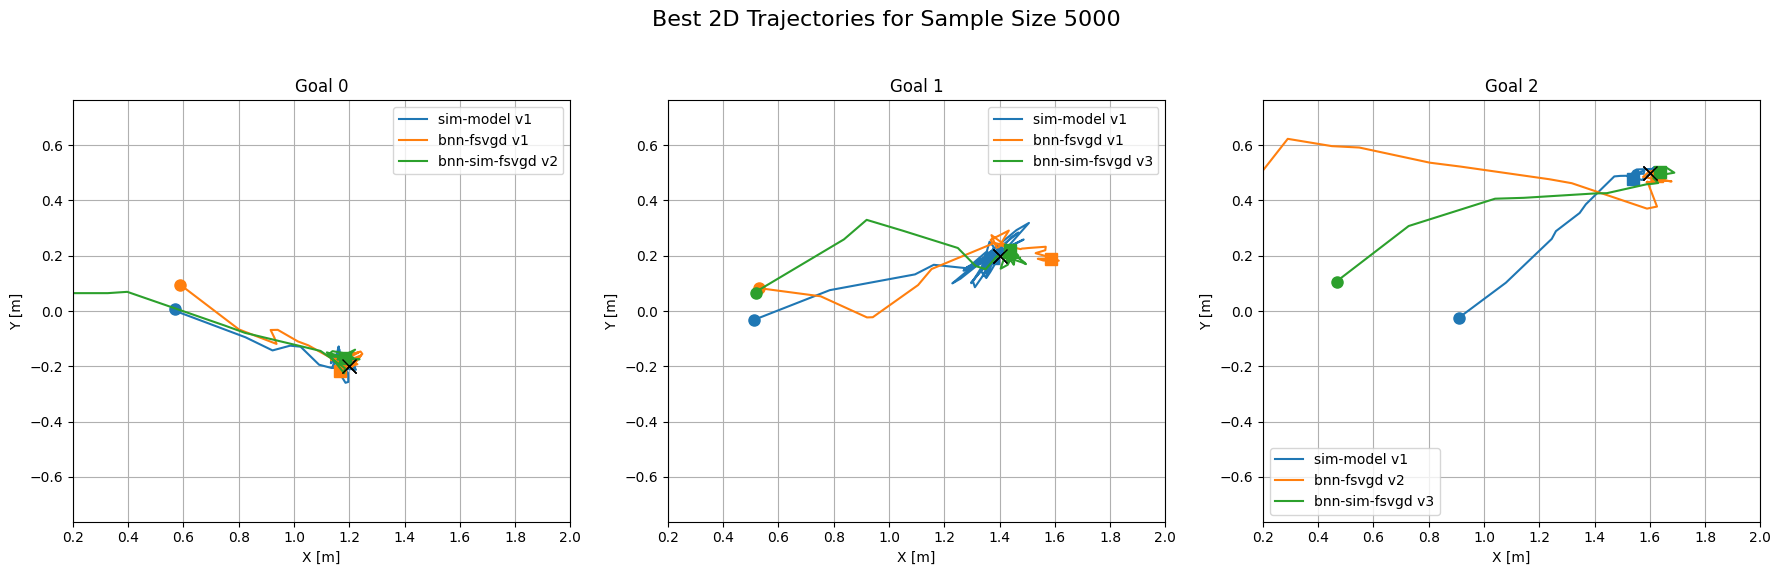

In [3]:
""" Full evaluation of policy performance on real robot """

import pickle
import numpy as np
import matplotlib.pyplot as plt
from sim_transfer.sims.util import decode_angles
from brax.training.types import Transition
import jax.tree_util as jtu
import jax.numpy as jnp
import re
import os

# Use a style for better aesthetics
# plt.style.use("seaborn-v0_8-whitegrid")
plt.style.use("seaborn-v0_8-colorblind")


# Global variables
step_index = 10  # Define the step index for error calculation
error_threshold = 0.1  # Threshold for EE-Goal error
plot_analysis = False  # Set to True to enable 'Analysis for Goal x' plots

# Define the list of trajectory files
file_paths = [
    # bnn_sim_fsvgd
    # Seed 1
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134202_policy_testing_full_v9_0q0aqecs_bnn-sim-fsvgd_800_1_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134300_policy_testing_full_v9_0q0aqecs_bnn-sim-fsvgd_800_1_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134355_policy_testing_full_v9_0q0aqecs_bnn-sim-fsvgd_800_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134447_policy_testing_full_v9_a95frpg8_bnn-sim-fsvgd_2000_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134538_policy_testing_full_v9_a95frpg8_bnn-sim-fsvgd_2000_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134630_policy_testing_full_v9_a95frpg8_bnn-sim-fsvgd_2000_1_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134723_policy_testing_full_v9_qmvdd08w_bnn-sim-fsvgd_5000_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134822_policy_testing_full_v9_qmvdd08w_bnn-sim-fsvgd_5000_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134908_policy_testing_full_v9_qmvdd08w_bnn-sim-fsvgd_5000_1_2__1.0/brax_transitions.pickle",
    # Seed 2
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-135020_policy_testing_full_v9_b1lrv5tz_bnn-sim-fsvgd_800_2_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-135058_policy_testing_full_v9_b1lrv5tz_bnn-sim-fsvgd_800_2_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-135138_policy_testing_full_v9_b1lrv5tz_bnn-sim-fsvgd_800_2_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-135423_policy_testing_full_v9_4bmmv080_bnn-sim-fsvgd_2000_2_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-135509_policy_testing_full_v9_4bmmv080_bnn-sim-fsvgd_2000_2_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-135648_policy_testing_full_v9_4bmmv080_bnn-sim-fsvgd_2000_2_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-135750_policy_testing_full_v9_tr3lhgrh_bnn-sim-fsvgd_5000_2_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-135848_policy_testing_full_v9_tr3lhgrh_bnn-sim-fsvgd_5000_2_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-135945_policy_testing_full_v9_tr3lhgrh_bnn-sim-fsvgd_5000_2_2__1.0/brax_transitions.pickle",
    # Seed 3
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-142040_policy_testing_full_v9_98lebqap_bnn-sim-fsvgd_800_3_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-142126_policy_testing_full_v9_98lebqap_bnn-sim-fsvgd_800_3_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-142210_policy_testing_full_v9_98lebqap_bnn-sim-fsvgd_800_3_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-142327_policy_testing_full_v9_rp7t77og_bnn-sim-fsvgd_2000_3_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-142423_policy_testing_full_v9_rp7t77og_bnn-sim-fsvgd_2000_3_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-142533_policy_testing_full_v9_rp7t77og_bnn-sim-fsvgd_2000_3_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-142627_policy_testing_full_v9_8z265p8u_bnn-sim-fsvgd_5000_3_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-142719_policy_testing_full_v9_8z265p8u_bnn-sim-fsvgd_5000_3_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-142805_policy_testing_full_v9_8z265p8u_bnn-sim-fsvgd_5000_3_2__1.0/brax_transitions.pickle",

    # sim_model
    # Seed 1
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-143536_policy_testing_full_v9_7539krvw_sim-model_800_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-143644_policy_testing_full_v9_7539krvw_sim-model_800_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-143736_policy_testing_full_v9_7539krvw_sim-model_800_1_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-143829_policy_testing_full_v9_9ojnkqii_sim-model_2000_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-143926_policy_testing_full_v9_9ojnkqii_sim-model_2000_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-144021_policy_testing_full_v9_9ojnkqii_sim-model_2000_1_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-144111_policy_testing_full_v9_pnqivxba_sim-model_5000_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-144201_policy_testing_full_v9_pnqivxba_sim-model_5000_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145002_policy_testing_full_v9_pnqivxba_sim-model_5000_1_2__1.0/brax_transitions.pickle",

    # Seed 2
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145111_policy_testing_full_v9_dwb45l5k_sim-model_800_2_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145155_policy_testing_full_v9_dwb45l5k_sim-model_800_2_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145248_policy_testing_full_v9_dwb45l5k_sim-model_800_2_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145340_policy_testing_full_v9_7c7ai1vy_sim-model_2000_2_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145428_policy_testing_full_v9_7c7ai1vy_sim-model_2000_2_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145531_policy_testing_full_v9_7c7ai1vy_sim-model_2000_2_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145630_policy_testing_full_v9_p50dxhru_sim-model_5000_2_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145722_policy_testing_full_v9_p50dxhru_sim-model_5000_2_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145811_policy_testing_full_v9_p50dxhru_sim-model_5000_2_2__1.0/brax_transitions.pickle",

    # Seed 3
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145910_policy_testing_full_v9_tcq7z9kw_sim-model_800_3_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145958_policy_testing_full_v9_tcq7z9kw_sim-model_800_3_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-150049_policy_testing_full_v9_tcq7z9kw_sim-model_800_3_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-150135_policy_testing_full_v9_7w0tt85r_sim-model_2000_3_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-150223_policy_testing_full_v9_7w0tt85r_sim-model_2000_3_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-150311_policy_testing_full_v9_7w0tt85r_sim-model_2000_3_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-150400_policy_testing_full_v9_fac8woya_sim-model_5000_3_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-150453_policy_testing_full_v9_fac8woya_sim-model_5000_3_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-150542_policy_testing_full_v9_fac8woya_sim-model_5000_3_2__1.0/brax_transitions.pickle",

    # bnn_fsvgd
    # Seed 1
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-165603_policy_testing_full_v9_4j9i5pw9_bnn-fsvgd_800_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-165700_policy_testing_full_v9_4j9i5pw9_bnn-fsvgd_800_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-165752_policy_testing_full_v9_4j9i5pw9_bnn-fsvgd_800_1_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-165930_policy_testing_full_v9_05blsrcg_bnn-fsvgd_2000_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-170035_policy_testing_full_v9_05blsrcg_bnn-fsvgd_2000_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-170129_policy_testing_full_v9_05blsrcg_bnn-fsvgd_2000_1_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-170214_policy_testing_full_v9_tx5ohk4g_bnn-fsvgd_5000_1_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-170318_policy_testing_full_v9_tx5ohk4g_bnn-fsvgd_5000_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-170412_policy_testing_full_v9_tx5ohk4g_bnn-fsvgd_5000_1_1__1.0/brax_transitions.pickle",

    # Seed 2
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-170516_policy_testing_full_v9_un61x52u_bnn-fsvgd_800_2_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-170556_policy_testing_full_v9_un61x52u_bnn-fsvgd_800_2_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-170636_policy_testing_full_v9_un61x52u_bnn-fsvgd_800_2_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-170716_policy_testing_full_v9_d266heoe_bnn-fsvgd_2000_2_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-170812_policy_testing_full_v9_d266heoe_bnn-fsvgd_2000_2_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-170857_policy_testing_full_v9_d266heoe_bnn-fsvgd_2000_2_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-170946_policy_testing_full_v9_94smmks2_bnn-fsvgd_5000_2_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-171037_policy_testing_full_v9_94smmks2_bnn-fsvgd_5000_2_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-171140_policy_testing_full_v9_94smmks2_bnn-fsvgd_5000_2_2__1.0/brax_transitions.pickle",

    # Seed 3
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-171657_policy_testing_full_v9_t1xofuqb_bnn-fsvgd_800_3_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-171747_policy_testing_full_v9_t1xofuqb_bnn-fsvgd_800_3_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-171831_policy_testing_full_v9_t1xofuqb_bnn-fsvgd_800_3_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-171923_policy_testing_full_v9_on1h09oj_bnn-fsvgd_2000_3_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-172010_policy_testing_full_v9_on1h09oj_bnn-fsvgd_2000_3_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-172053_policy_testing_full_v9_on1h09oj_bnn-fsvgd_2000_3_2__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-172144_policy_testing_full_v9_kboo9glz_bnn-fsvgd_5000_3_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-172231_policy_testing_full_v9_kboo9glz_bnn-fsvgd_5000_3_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-172320_policy_testing_full_v9_kboo9glz_bnn-fsvgd_5000_3_2__1.0/brax_transitions.pickle",
]


# Define your goals
goal_1 = np.array([1.2, -0.2, 0.8])
goal_2 = np.array([1.4, 0.2, 0.4])
goal_3 = np.array([1.6, 0.5, 0.2])

goals = [goal_1, goal_2, goal_3]

# Initialize dictionaries to store data per goal and per model type
goal_data = {}
model_data = {}
data_per_model_sample_goal = {}  # Data per model, sample size, and goal

def extract_info_from_file_path(file_path):
    """Extract model info from file path."""
    dir_name = os.path.dirname(file_path)
    dir_base_name = os.path.basename(dir_name)
    parts = dir_base_name.split('_')

    # Find index of 8-character unique id
    for i in range(len(parts)):
        if re.match(r'^\w{8}$', parts[i]):
            uniqueid_parts = parts[:i+1]
            uniqueid = '_'.join(uniqueid_parts)
            rest_parts = parts[i+1:]
            break
    else:
        raise ValueError(f"Could not find unique id in file path {file_path}")

    if len(rest_parts) < 4:
        raise ValueError(f"Not enough parts in file path {file_path}")

    modeltype = rest_parts[0]
    samplesize = rest_parts[1]
    variant = rest_parts[2]
    goalindex = rest_parts[3]

    # Handle the double underscore
    params_and_rest = '_'.join(rest_parts[4:])
    params_split = params_and_rest.split('__')
    if len(params_split) == 2:
        params = params_split[1]
    else:
        # Try splitting by '_'
        params_split = params_and_rest.split('_')
        if len(params_split) >= 1:
            params = params_split[-1]
        else:
            params = ''

    return {
        'uniqueid': uniqueid,
        'modeltype': modeltype,
        'samplesize': samplesize,
        'variant': variant,
        'goalindex': goalindex,
        'params': params
    }

# Loop over each trajectory file
for idx, file_path in enumerate(file_paths):
    # Load trajectory from policy simulation
    with open(file_path, "rb") as file:
        traj_raw = pickle.load(file)

    # Extract info from file path
    info = extract_info_from_file_path(file_path)
    label = f"{info['modeltype']}_{info['samplesize']}_v{info['variant']}_g{info['goalindex']}"
    model_type = info['modeltype']
    sample_size = info['samplesize']
    goal_index = int(info['goalindex'])
    variant = info['variant']

    # Extract goal index
    if goal_index >= len(goals):
        raise ValueError(f"Goal index {goal_index} is out of bounds")

    goal = goals[goal_index]

    # Initialize data structures for this goal if not already done
    if goal_index not in goal_data:
        goal_data[goal_index] = {
            "file_paths": [],
            "labels": [],
            "observations": [],
            "actions": [],
            "rewards": [],
            "ee_goal_errors_at_step": [],
            "steps_below_threshold": [],
        }

    # Initialize data structures for this model type if not already done
    if model_type not in model_data:
        model_data[model_type] = {
            "labels": [],
            "observations": [],
            "actions": [],
            "rewards": [],
            "ee_goal_errors_at_step": [],
            "steps_below_threshold": [],
            "goals": [],
        }

    # Initialize data structures for data per model, sample size, and goal
    if model_type not in data_per_model_sample_goal:
        data_per_model_sample_goal[model_type] = {}
    if sample_size not in data_per_model_sample_goal[model_type]:
        data_per_model_sample_goal[model_type][sample_size] = {}
    if goal_index not in data_per_model_sample_goal[model_type][sample_size]:
        data_per_model_sample_goal[model_type][sample_size][goal_index] = {
            "ee_goal_errors_at_step": [],
            "steps_below_threshold": [],
            "labels": [],
            "observations": [],  # Store observations for trajectory plotting
        }

    # Add goal to observations
    def add_goal_to_obs(obs: jnp.ndarray, goal: jnp.ndarray) -> jnp.ndarray:
        return jnp.concatenate([obs, goal])

    new_traj = []

    # Add goal to each observation in the trajectory
    for i in range(len(traj_raw)):
        obs = traj_raw[i].observation
        next_obs = traj_raw[i].next_observation
        obs = add_goal_to_obs(obs, goal)
        next_obs = add_goal_to_obs(next_obs, goal)
        new_traj.append(
            Transition(
                observation=obs,
                action=traj_raw[i].action,
                reward=jnp.array(0),
                next_observation=next_obs,
                discount=traj_raw[i].discount,
            )
        )

    traj = jtu.tree_map(lambda *xs: jnp.stack(xs, axis=0), *new_traj)

    # Convert transitions to trajectory
    observations = traj.observation
    actions = traj.action
    rewards = traj.reward

    # Decode angles if needed
    if observations.shape[-1] == 16:
        observations = decode_angles(observations, 2)

    # Convert observations to numpy array
    observations_np = np.array(observations)

    # Calculate EE-Goal error over time
    ee_pos = observations_np[:, 6:9]
    goal_pos = observations_np[:, -3:]
    error = np.linalg.norm(ee_pos - goal_pos, axis=1)

    # EE-Goal error at step_index
    if len(error) > step_index:
        ee_goal_error_at_step = error[step_index]
    else:
        ee_goal_error_at_step = np.nan

    # Steps until error drops below threshold
    steps_below_threshold = np.where(error < error_threshold)[0]
    if steps_below_threshold.size > 0:
        steps_to_threshold = steps_below_threshold[0]
    else:
        steps_to_threshold = np.nan  # Did not reach threshold

    # Append data to the corresponding goal
    goal_data[goal_index]["file_paths"].append(file_path)
    goal_data[goal_index]["labels"].append(label)
    goal_data[goal_index]["observations"].append(observations_np)
    goal_data[goal_index]["actions"].append(np.array(actions))
    goal_data[goal_index]["rewards"].append(np.array(rewards))
    goal_data[goal_index]["ee_goal_errors_at_step"].append(ee_goal_error_at_step)
    goal_data[goal_index]["steps_below_threshold"].append(steps_to_threshold)

    # Append data to the corresponding model type
    model_data[model_type]["labels"].append(f"{label}")
    model_data[model_type]["observations"].append(observations_np)
    model_data[model_type]["actions"].append(np.array(actions))
    model_data[model_type]["rewards"].append(np.array(rewards))
    model_data[model_type]["ee_goal_errors_at_step"].append(ee_goal_error_at_step)
    model_data[model_type]["steps_below_threshold"].append(steps_to_threshold)
    model_data[model_type]["goals"].append(goal_index)

    # Append data to data_per_model_sample_goal
    data_per_model_sample_goal[model_type][sample_size][goal_index]["ee_goal_errors_at_step"].append(ee_goal_error_at_step)
    data_per_model_sample_goal[model_type][sample_size][goal_index]["steps_below_threshold"].append(steps_to_threshold)
    data_per_model_sample_goal[model_type][sample_size][goal_index]["labels"].append(label)
    data_per_model_sample_goal[model_type][sample_size][goal_index]["observations"].append(observations_np)  # Store observations

# Compute average and std across variants (v1-v3) for each model, sample size, and goal
stats_ee_goal_error_at_step = {}
stats_steps_below_threshold = {}

for model_type in data_per_model_sample_goal:
    if model_type not in stats_ee_goal_error_at_step:
        stats_ee_goal_error_at_step[model_type] = {}
        stats_steps_below_threshold[model_type] = {}
    for sample_size in data_per_model_sample_goal[model_type]:
        if sample_size not in stats_ee_goal_error_at_step[model_type]:
            stats_ee_goal_error_at_step[model_type][sample_size] = {}
            stats_steps_below_threshold[model_type][sample_size] = {}
        for goal_index in data_per_model_sample_goal[model_type][sample_size]:
            errors = data_per_model_sample_goal[model_type][sample_size][goal_index]['ee_goal_errors_at_step']
            steps = data_per_model_sample_goal[model_type][sample_size][goal_index]['steps_below_threshold']

            # Remove NaN values before computing statistics
            errors_clean = [e for e in errors if not np.isnan(e)]
            steps_clean = [s for s in steps if not np.isnan(s)]

            if errors_clean:
                avg_error = np.mean(errors_clean)
                std_error = np.std(errors_clean)
            else:
                avg_error = std_error = np.nan

            if steps_clean:
                avg_step = np.mean(steps_clean)
                std_step = np.std(steps_clean)
            else:
                avg_step = std_step = np.nan

            stats_ee_goal_error_at_step[model_type][sample_size][goal_index] = (avg_error, std_error)
            stats_steps_below_threshold[model_type][sample_size][goal_index] = (avg_step, std_step)

# Ensure the model types are in the specified order
model_types = ["sim-model", "bnn-fsvgd", "bnn-sim-fsvgd"]

# Extract sample sizes
sample_sizes = set()
for model_type in data_per_model_sample_goal:
    for sample_size in data_per_model_sample_goal[model_type]:
        sample_sizes.add(sample_size)

sample_sizes = sorted(sample_sizes, key=lambda x: int(x))  # Sort numerically

# Define colors for consistency
colors = plt.get_cmap('tab10').colors
color_dict = dict(zip(model_types, colors))

# Plotting functions

def plot_per_sample_size_horizontal_bar(stats_data, sample_sizes, model_types, metric_name):
    """Plot horizontal bar charts per sample size per goal with std as error bars."""
    for sample_size in sample_sizes:
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))
        for goal_index in range(3):  # Assuming goals are 0,1,2
            ax = axs[goal_index]
            avg_values = []
            std_values = []
            labels = []
            colors = []
            for idx, model_type in enumerate(model_types):
                if sample_size in stats_data.get(model_type, {}):
                    if goal_index in stats_data[model_type][sample_size]:
                        avg_value, std_value = stats_data[model_type][sample_size][goal_index]
                        avg_values.append(avg_value)
                        std_values.append(std_value)
                        labels.append(model_type)
                        colors.append(color_dict[model_type])
            y_positions = np.arange(len(labels))
            # Convert lists to NumPy arrays
            avg_values = np.array(avg_values)
            std_values = np.array(std_values)
            # Plot bars with error bars representing std
            ax.barh(y_positions, avg_values, xerr=std_values, align='center', color=colors, ecolor='black', capsize=5)
            ax.set_yticks(y_positions)
            ax.set_yticklabels(labels)
            ax.set_xlabel(metric_name)
            ax.set_title(f"Goal {goal_index}")
            ax.invert_yaxis()
            ax.grid(True, axis='x')
        plt.suptitle(f"{metric_name} for Sample Size {sample_size}", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

def plot_metric_vs_sample_size_line(stats_data, sample_sizes, model_types, metric_name):
    """Plot line charts per plot type with one subplot per goal."""
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    for goal_index in range(3):  # Assuming goals are 0,1,2
        ax = axs[goal_index]
        markers = ['o', 's', 'D']  # Different markers for model types
        for idx, model_type in enumerate(model_types):
            avg_values = []
            sample_size_labels = []
            for sample_size in sample_sizes:
                sample_size_labels.append(f"S{sample_sizes.index(sample_size)+1} ({sample_size})")
                if sample_size in stats_data.get(model_type, {}):
                    if goal_index in stats_data[model_type][sample_size]:
                        avg_value, std_value = stats_data[model_type][sample_size][goal_index]
                        avg_values.append(avg_value)
                    else:
                        avg_values.append(np.nan)
                else:
                    avg_values.append(np.nan)
            # Convert lists to NumPy arrays
            avg_values = np.array(avg_values)
            # Create x positions
            x_positions = np.arange(len(sample_sizes))
            # Plot line without error bars
            ax.plot(x_positions, avg_values, label=f"{model_type}", color=color_dict[model_type], marker=markers[idx])
        # Set x-axis labels
        ax.set_xticks(x_positions)
        ax.set_xticklabels([f"S{sample_sizes.index(s)+1} ({s})" for s in sample_sizes])
        ax.set_xlabel("Sample Sizes")
        ax.set_ylabel(metric_name)
        ax.set_title(f"Goal {goal_index}")
        ax.legend(loc='upper right')
        ax.grid(True)
    plt.suptitle(metric_name, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def select_best_trajectory(data_per_model_sample_goal):
    """Select the best trajectory per model type, sample size, and goal."""
    best_trajectories = {}

    for sample_size in sample_sizes:
        best_trajectories[sample_size] = {}
        for goal_index in range(3):
            best_trajectories[sample_size][goal_index] = {}
            for model_type in model_types:
                if sample_size in data_per_model_sample_goal[model_type]:
                    if goal_index in data_per_model_sample_goal[model_type][sample_size]:
                        errors = data_per_model_sample_goal[model_type][sample_size][goal_index]['ee_goal_errors_at_step']
                        steps = data_per_model_sample_goal[model_type][sample_size][goal_index]['steps_below_threshold']
                        labels = data_per_model_sample_goal[model_type][sample_size][goal_index]['labels']
                        observations_list = data_per_model_sample_goal[model_type][sample_size][goal_index]['observations']

                        valid_indices = [i for i in range(len(errors)) if not (np.isnan(errors[i]) and np.isnan(steps[i]))]

                        if valid_indices:
                            # Prepare lists for available errors and steps
                            error_values = [errors[i] for i in valid_indices if not np.isnan(errors[i])]
                            step_values = [steps[i] for i in valid_indices if not np.isnan(steps[i])]

                            # Compute ranks
                            error_ranks_dict = {}
                            if error_values:
                                error_values = np.array(error_values)
                                error_ranks = error_values.argsort().argsort()
                                error_indices = [i for i in valid_indices if not np.isnan(errors[i])]
                                error_ranks_dict = dict(zip(error_indices, error_ranks))

                            step_ranks_dict = {}
                            if step_values:
                                step_values = np.array(step_values)
                                step_ranks = step_values.argsort().argsort()
                                step_indices = [i for i in valid_indices if not np.isnan(steps[i])]
                                step_ranks_dict = dict(zip(step_indices, step_ranks))

                            # Compute total ranks
                            total_ranks = {}
                            for idx in valid_indices:
                                ranks = 0
                                if idx in error_ranks_dict and idx in step_ranks_dict:
                                    # Both indicators available
                                    ranks = error_ranks_dict[idx] + step_ranks_dict[idx]
                                elif idx in error_ranks_dict:
                                    # Only error available
                                    ranks = 2 * error_ranks_dict[idx]
                                elif idx in step_ranks_dict:
                                    # Only step available
                                    ranks = 2 * step_ranks_dict[idx]
                                else:
                                    continue  # Should not happen
                                total_ranks[idx] = ranks

                            # Find the index with the lowest total rank
                            best_idx = min(total_ranks, key=total_ranks.get)
                            best_trajectories[sample_size][goal_index][model_type] = {
                                'label': labels[best_idx],
                                'observations': observations_list[best_idx],
                            }
                        else:
                            # No valid trajectories
                            best_trajectories[sample_size][goal_index][model_type] = None
                    else:
                        best_trajectories[sample_size][goal_index][model_type] = None
                else:
                    best_trajectories[sample_size][goal_index][model_type] = None
    return best_trajectories

def plot_best_2d_trajectories(best_trajectories, x_limits, y_limits):
    """Plot the best 2D trajectories per sample size and goal."""
    for sample_size in sample_sizes:
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))
        for goal_index in range(3):
            ax = axs[goal_index]
            for model_type in model_types:
                best_traj = best_trajectories[sample_size][goal_index].get(model_type)
                if best_traj and best_traj['observations'] is not None:
                    obs = best_traj['observations']
                    label = best_traj['label']
                    # Extract variant from label
                    # label format is "{modeltype}_{samplesize}_v{variant}_g{goalindex}"
                    variant = label.split('_')[2]  # 'v{variant}'
                    label_with_variant = f"{model_type} {variant}"
                    color = color_dict[model_type]
                    # Plot EE trajectory
                    ax.plot(obs[:, 6], obs[:, 7], label=label_with_variant, color=color)
                    # Plot EE start and end points
                    ax.plot(obs[0, 6], obs[0, 7], "o", color=color, markersize=8)
                    ax.plot(obs[-1, 6], obs[-1, 7], "s", color=color, markersize=8)
                    # Plot goal position
                    ax.plot(obs[0, -3], obs[0, -2], "x", color="black", markersize=10)
            ax.set_title(f"Goal {goal_index}")
            ax.set_xlabel("X [m]")
            ax.set_ylabel("Y [m]")
            ax.axis("equal")
            ax.set_xlim(x_limits)
            ax.set_ylim(y_limits)
            ax.legend()
            ax.grid(True)
        plt.suptitle(f"Best 2D Trajectories for Sample Size {sample_size}", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Plotting per your specifications

# 1. Per sample size, horizontal bar charts with subplots per goal

# Plot Average EE-Goal Error at Step 10 with std error bars
plot_per_sample_size_horizontal_bar(stats_ee_goal_error_at_step, sample_sizes, model_types, f"Average EE-Goal Error at Step {step_index} [m]")

# Plot Average Steps to Error < threshold with std error bars
plot_per_sample_size_horizontal_bar(stats_steps_below_threshold, sample_sizes, model_types, f"Average Steps to Error < {error_threshold} m")

# 2. Line plots grouped into one figure per plot type with subplots per goal, no std/min/max, legend in top right

# Plot Average EE-Goal Error at Step 10 vs. Sample Sizes
plot_metric_vs_sample_size_line(stats_ee_goal_error_at_step, sample_sizes, model_types, f"Average EE-Goal Error at Step {step_index} [m]")

# Plot Average Steps to Error < threshold vs. Sample Sizes
plot_metric_vs_sample_size_line(stats_steps_below_threshold, sample_sizes, model_types, f"Average Steps to Error < {error_threshold} m")

# 3. Plot best 2D trajectories per sample size and goal

# Define x and y limits for the plots
x_limits = (0.2, 2.0)
y_limits = (-1.5, 1.5)

# Select best trajectories
best_trajectories = select_best_trajectory(data_per_model_sample_goal)

# Plot best 2D trajectories
plot_best_2d_trajectories(best_trajectories, x_limits, y_limits)





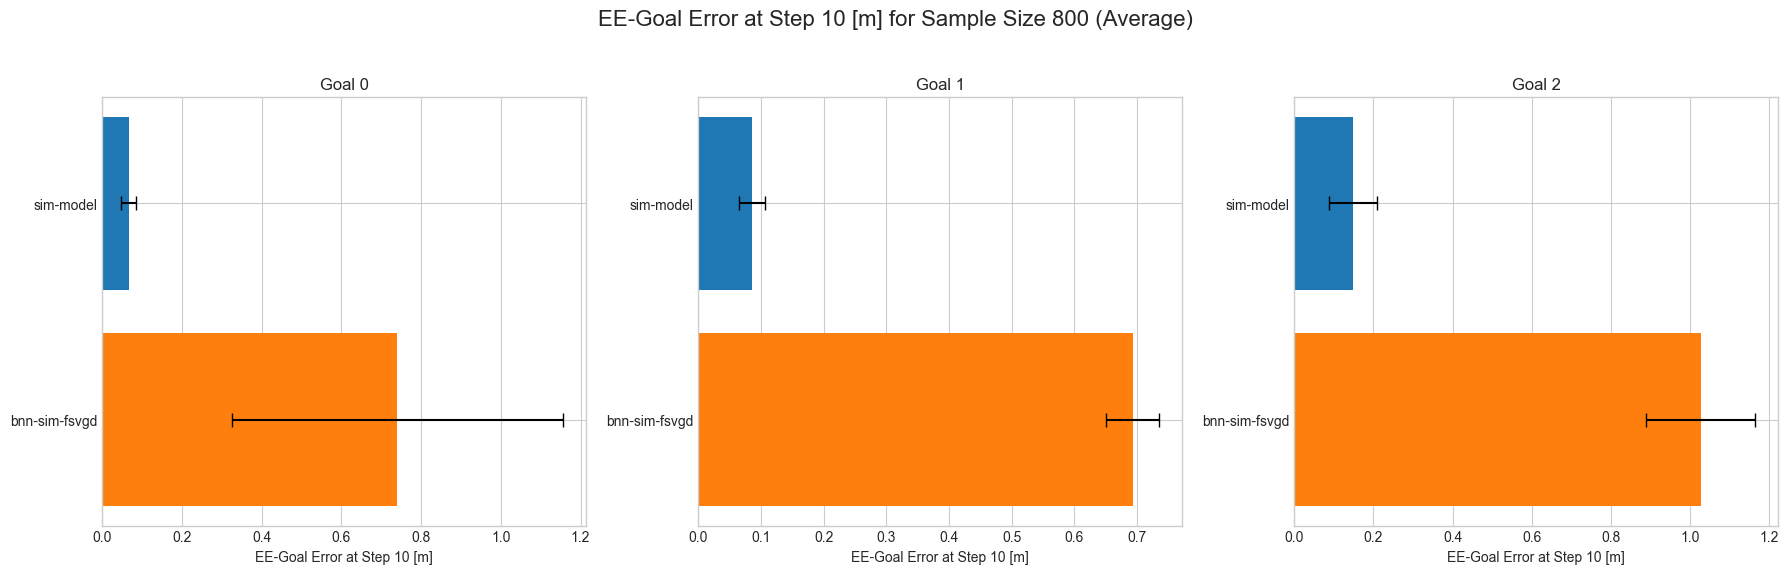

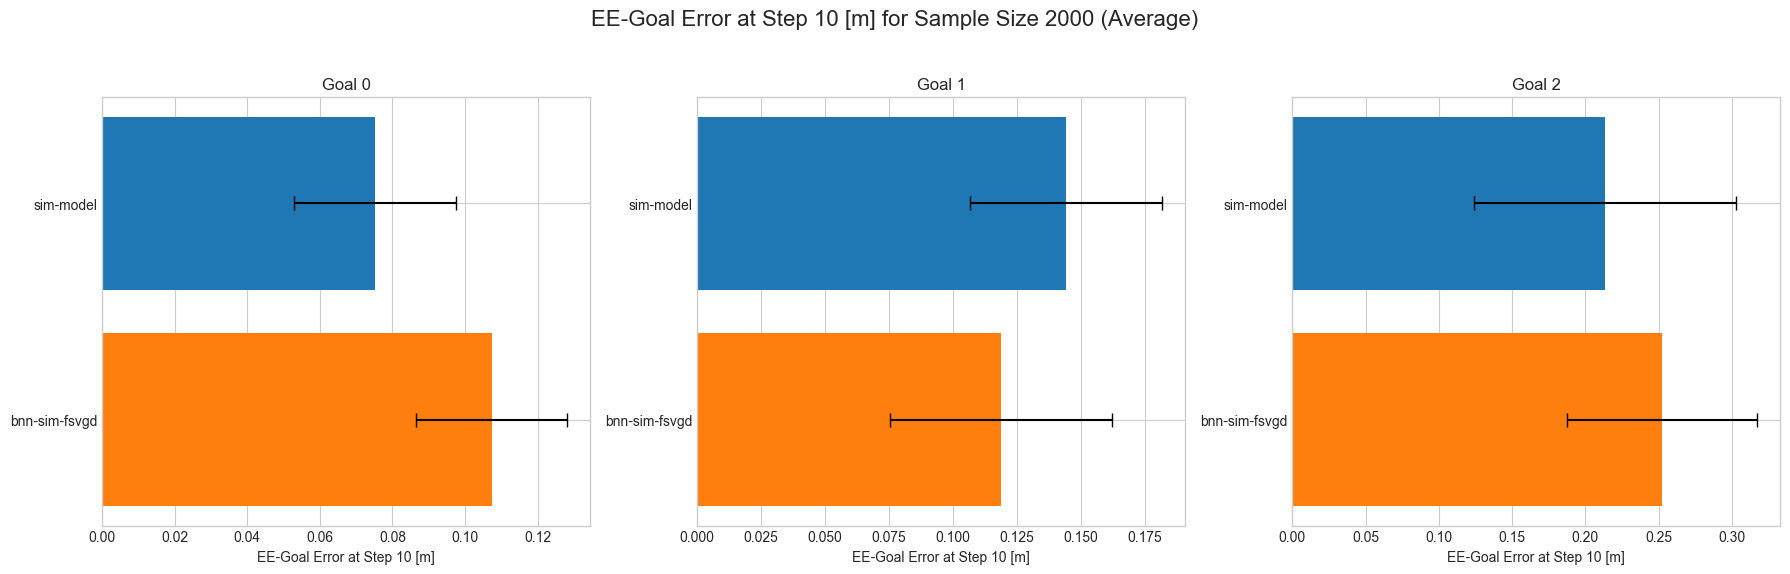

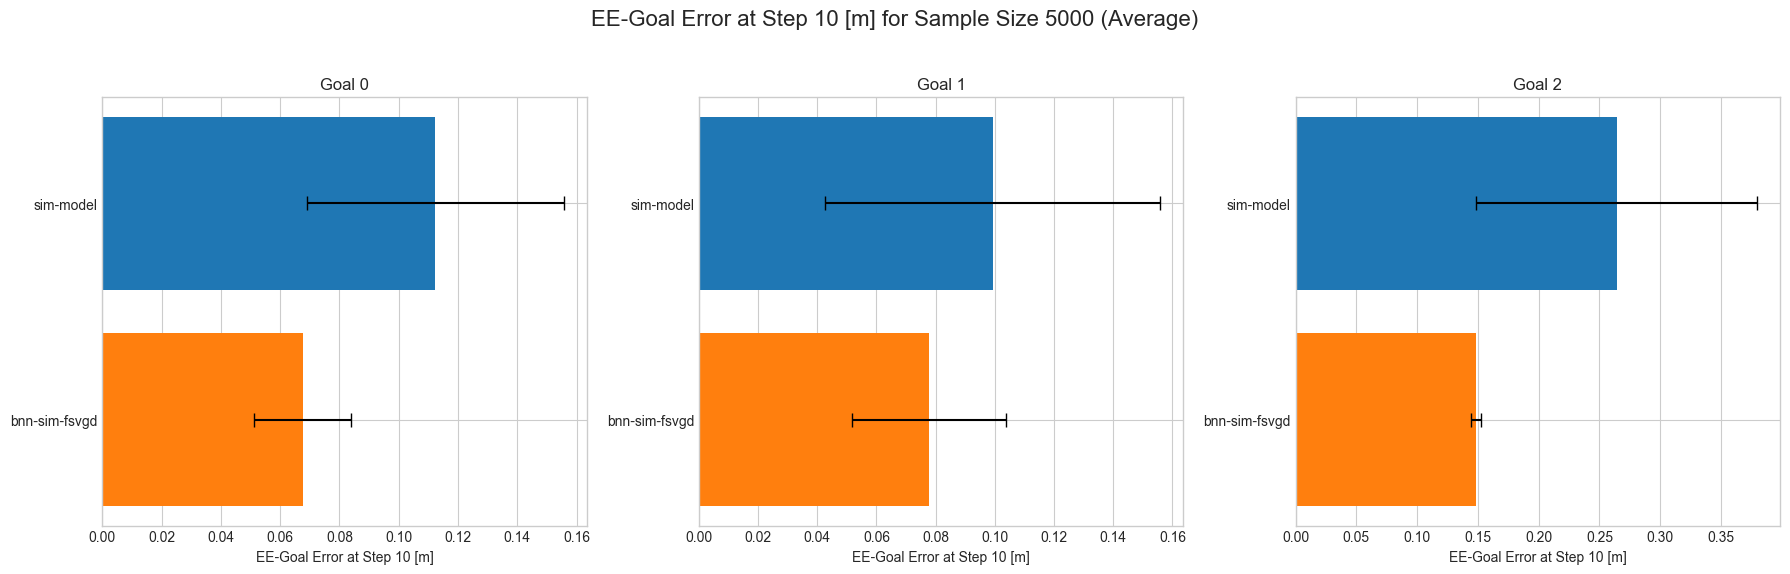

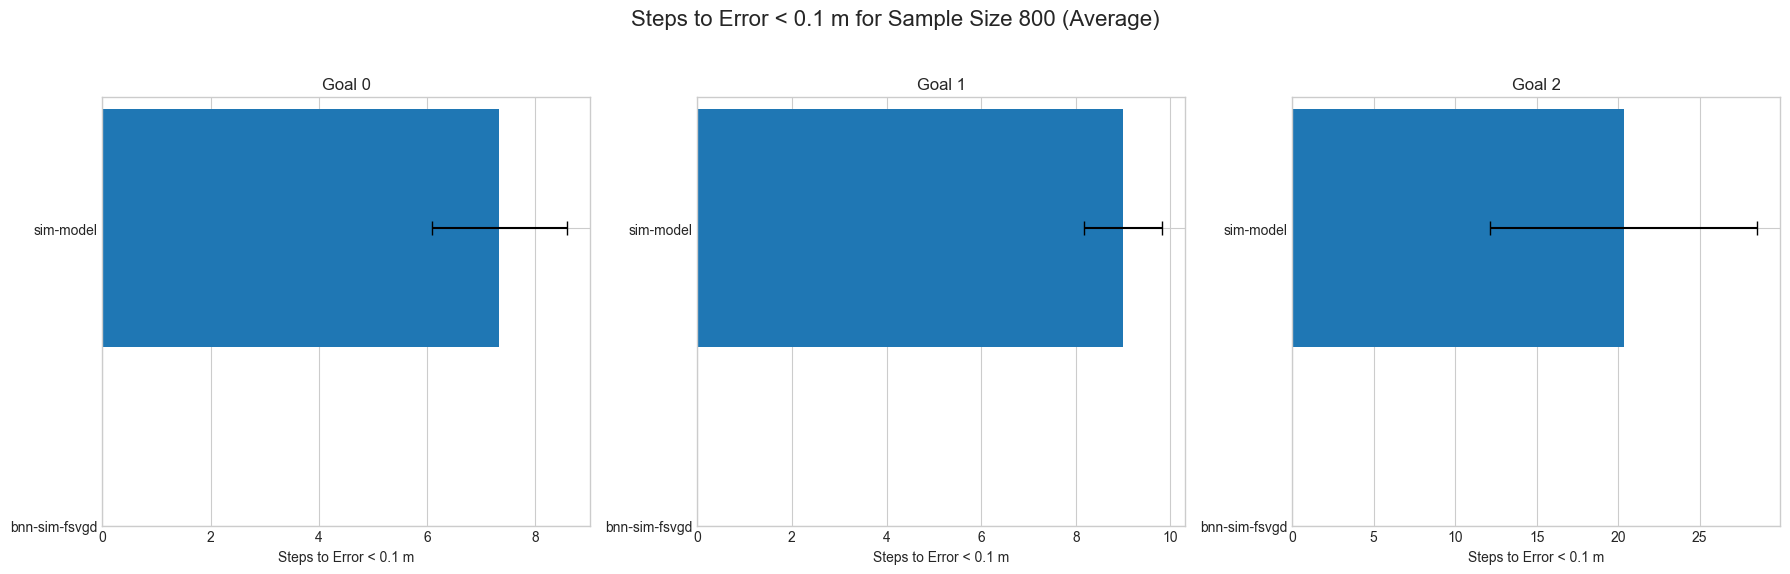

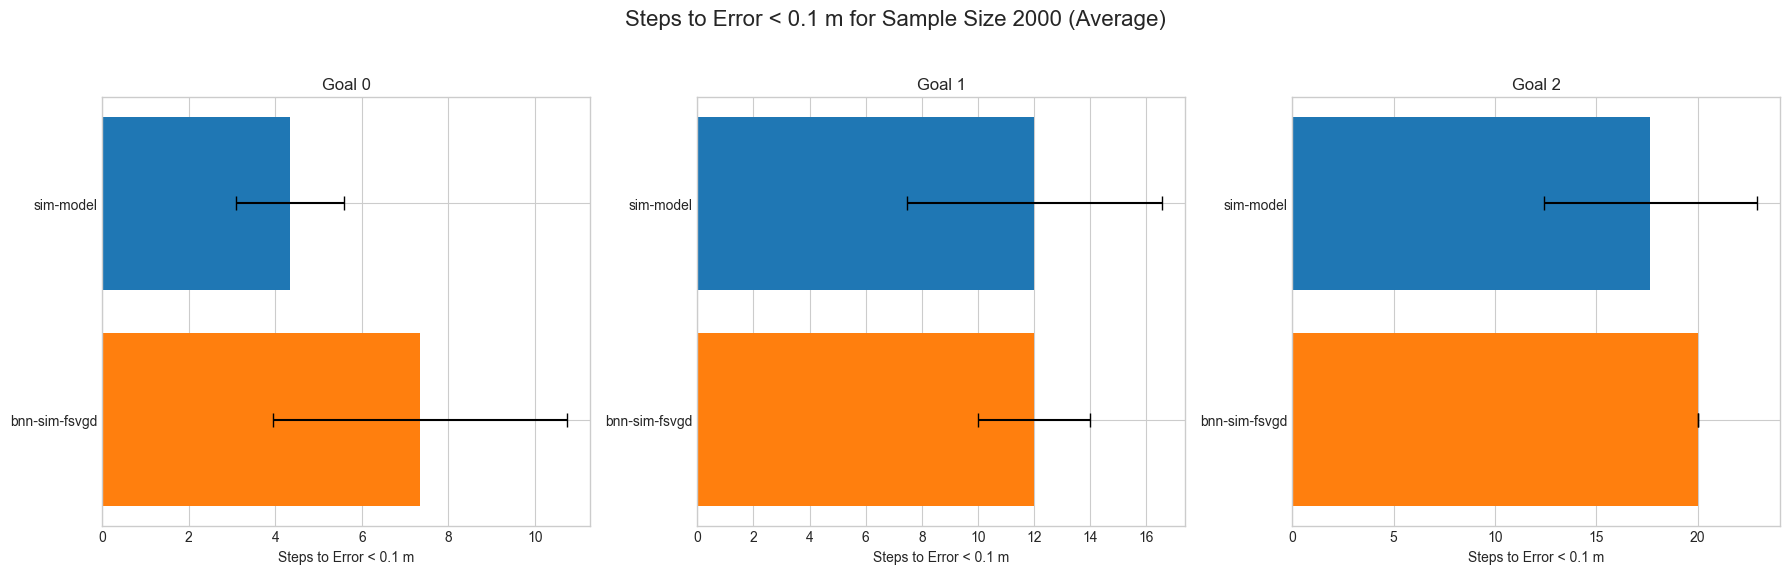

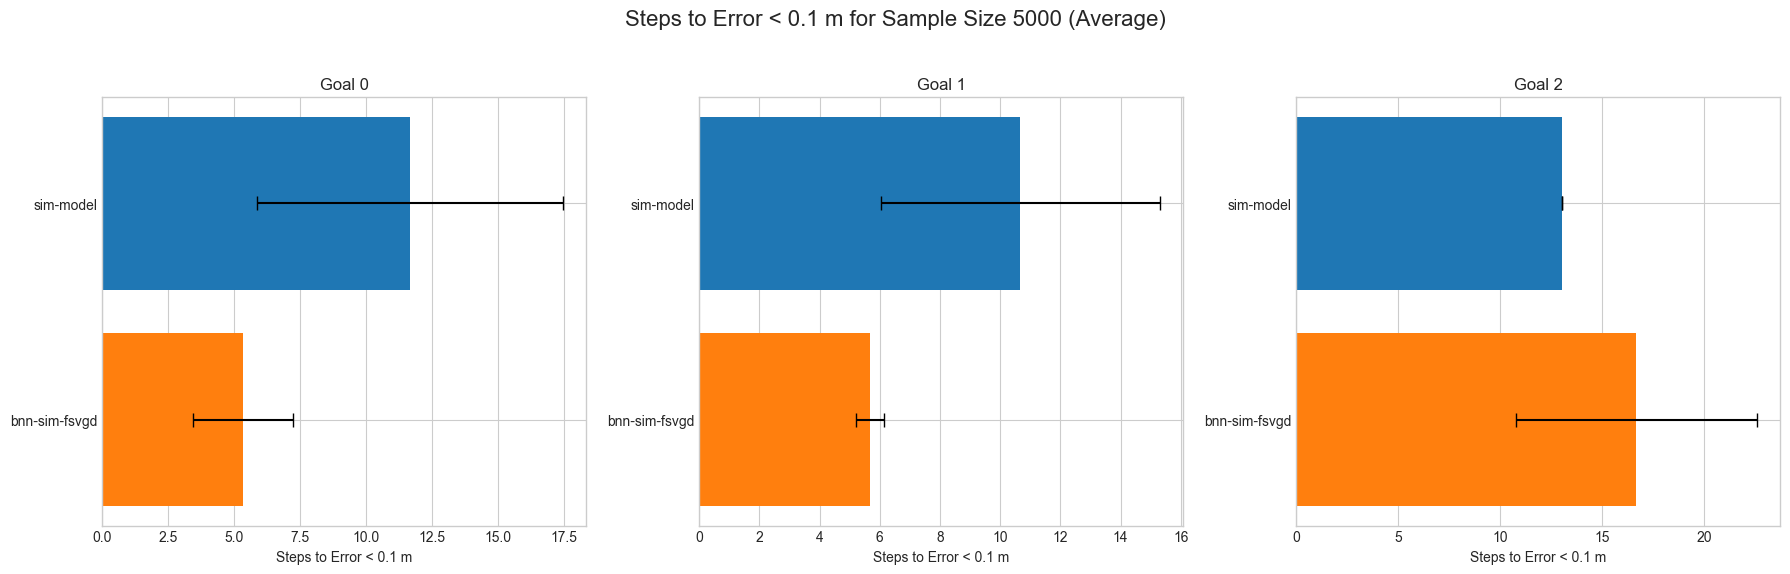

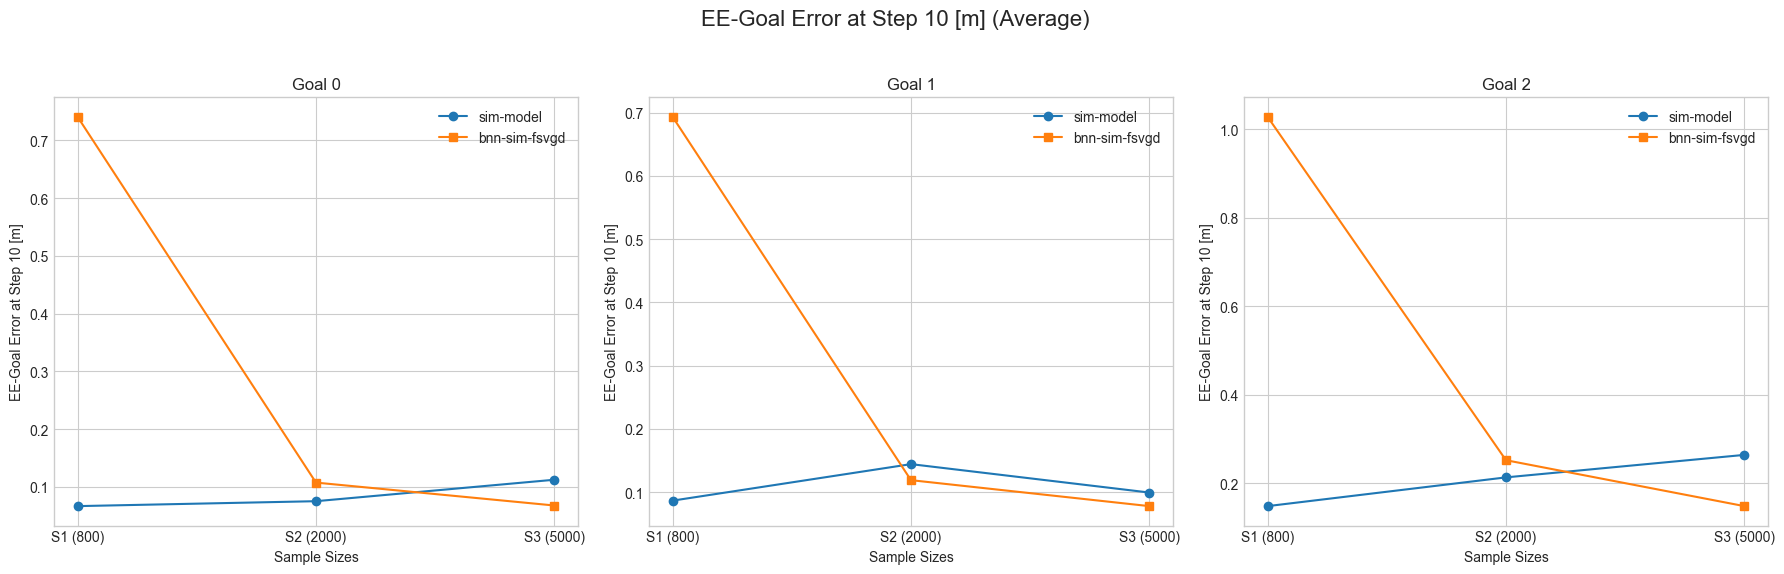

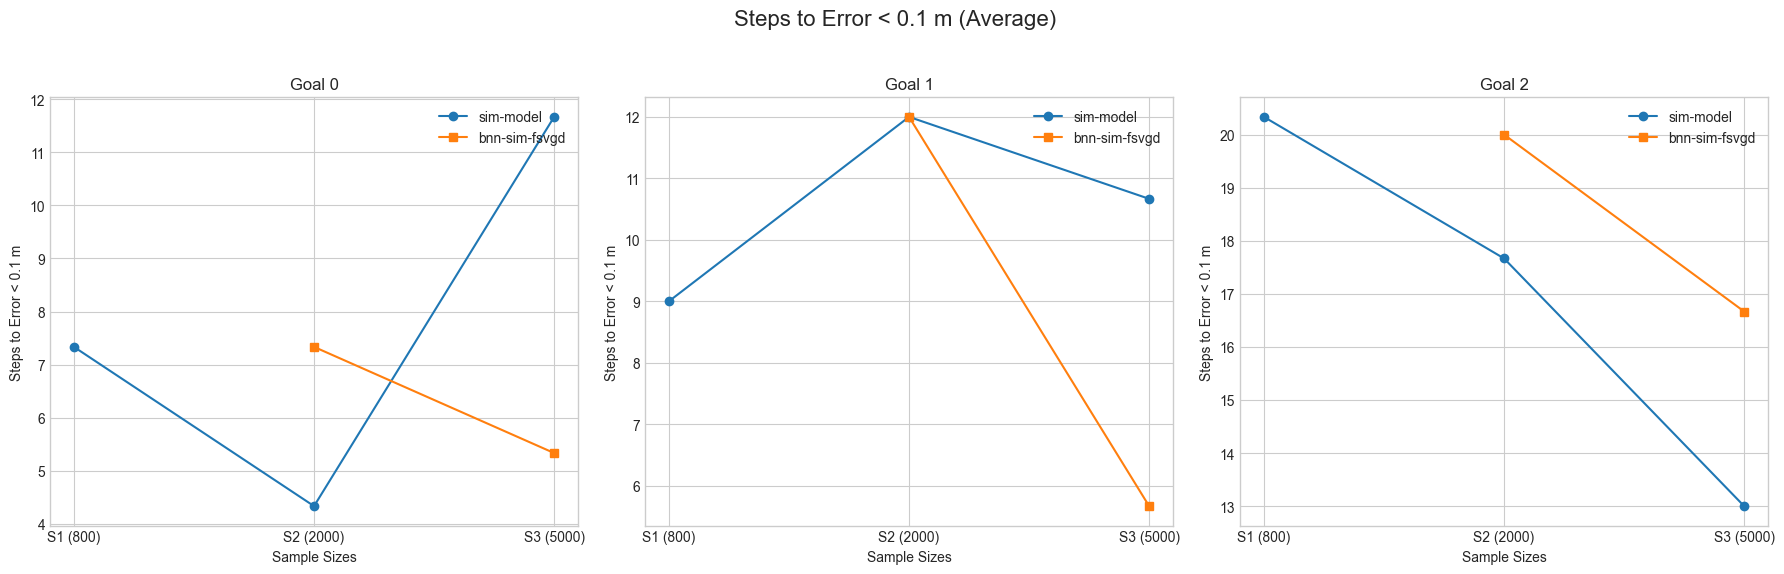

In [6]:
""" Full evaluation of policy performance on real robot """

import pickle
import numpy as np
import matplotlib.pyplot as plt
from sim_transfer.sims.util import decode_angles
from brax.training.types import Transition
import jax.tree_util as jtu
import jax.numpy as jnp
import re
import os

# Use a style for better aesthetics
# plt.style.use("seaborn-v0_8-whitegrid")
plt.style.use("seaborn-v0_8-colorblind")


# Global variables
step_index = 10  # Define the step index for error calculation
error_threshold = 0.1  # Threshold for EE-Goal error
plot_analysis = False  # Set to True to enable 'Analysis for Goal x' plots

plot_variant = 'average'  # Change this to 'best' or 'worst' as needed


# Define the list of trajectory files
file_paths = [
    # # bnn_sim_fsvgd
    # # Seed 1
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134202_policy_testing_full_v9_0q0aqecs_bnn-sim-fsvgd_800_1_0__1.0/brax_transitions.pickle",
    # # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134300_policy_testing_full_v9_0q0aqecs_bnn-sim-fsvgd_800_1_2__1.0/brax_transitions.pickle",
    # # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134355_policy_testing_full_v9_0q0aqecs_bnn-sim-fsvgd_800_1_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134447_policy_testing_full_v9_a95frpg8_bnn-sim-fsvgd_2000_1_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134538_policy_testing_full_v9_a95frpg8_bnn-sim-fsvgd_2000_1_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134630_policy_testing_full_v9_a95frpg8_bnn-sim-fsvgd_2000_1_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134723_policy_testing_full_v9_qmvdd08w_bnn-sim-fsvgd_5000_1_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134822_policy_testing_full_v9_qmvdd08w_bnn-sim-fsvgd_5000_1_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-134908_policy_testing_full_v9_qmvdd08w_bnn-sim-fsvgd_5000_1_2__1.0/brax_transitions.pickle",
    # # Seed 2
    # # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-135020_policy_testing_full_v9_b1lrv5tz_bnn-sim-fsvgd_800_2_0__1.0/brax_transitions.pickle",
    # # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-135058_policy_testing_full_v9_b1lrv5tz_bnn-sim-fsvgd_800_2_1__1.0/brax_transitions.pickle",
    # # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-135138_policy_testing_full_v9_b1lrv5tz_bnn-sim-fsvgd_800_2_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-135423_policy_testing_full_v9_4bmmv080_bnn-sim-fsvgd_2000_2_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-135509_policy_testing_full_v9_4bmmv080_bnn-sim-fsvgd_2000_2_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-135648_policy_testing_full_v9_4bmmv080_bnn-sim-fsvgd_2000_2_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-135750_policy_testing_full_v9_tr3lhgrh_bnn-sim-fsvgd_5000_2_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-135848_policy_testing_full_v9_tr3lhgrh_bnn-sim-fsvgd_5000_2_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-135945_policy_testing_full_v9_tr3lhgrh_bnn-sim-fsvgd_5000_2_2__1.0/brax_transitions.pickle",
    # # Seed 3
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-142040_policy_testing_full_v9_98lebqap_bnn-sim-fsvgd_800_3_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-142126_policy_testing_full_v9_98lebqap_bnn-sim-fsvgd_800_3_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-142210_policy_testing_full_v9_98lebqap_bnn-sim-fsvgd_800_3_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-142327_policy_testing_full_v9_rp7t77og_bnn-sim-fsvgd_2000_3_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-142423_policy_testing_full_v9_rp7t77og_bnn-sim-fsvgd_2000_3_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-142533_policy_testing_full_v9_rp7t77og_bnn-sim-fsvgd_2000_3_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-142627_policy_testing_full_v9_8z265p8u_bnn-sim-fsvgd_5000_3_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-142719_policy_testing_full_v9_8z265p8u_bnn-sim-fsvgd_5000_3_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-142805_policy_testing_full_v9_8z265p8u_bnn-sim-fsvgd_5000_3_2__1.0/brax_transitions.pickle",

    # # sim_model
    # # Seed 1
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-143536_policy_testing_full_v9_7539krvw_sim-model_800_1_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-143644_policy_testing_full_v9_7539krvw_sim-model_800_1_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-143736_policy_testing_full_v9_7539krvw_sim-model_800_1_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-143829_policy_testing_full_v9_9ojnkqii_sim-model_2000_1_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-143926_policy_testing_full_v9_9ojnkqii_sim-model_2000_1_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-144021_policy_testing_full_v9_9ojnkqii_sim-model_2000_1_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-144111_policy_testing_full_v9_pnqivxba_sim-model_5000_1_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-144201_policy_testing_full_v9_pnqivxba_sim-model_5000_1_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145002_policy_testing_full_v9_pnqivxba_sim-model_5000_1_2__1.0/brax_transitions.pickle",

    # # Seed 2
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145111_policy_testing_full_v9_dwb45l5k_sim-model_800_2_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145155_policy_testing_full_v9_dwb45l5k_sim-model_800_2_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145248_policy_testing_full_v9_dwb45l5k_sim-model_800_2_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145340_policy_testing_full_v9_7c7ai1vy_sim-model_2000_2_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145428_policy_testing_full_v9_7c7ai1vy_sim-model_2000_2_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145531_policy_testing_full_v9_7c7ai1vy_sim-model_2000_2_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145630_policy_testing_full_v9_p50dxhru_sim-model_5000_2_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145722_policy_testing_full_v9_p50dxhru_sim-model_5000_2_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145811_policy_testing_full_v9_p50dxhru_sim-model_5000_2_2__1.0/brax_transitions.pickle",

    # # Seed 3
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145910_policy_testing_full_v9_tcq7z9kw_sim-model_800_3_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-145958_policy_testing_full_v9_tcq7z9kw_sim-model_800_3_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-150049_policy_testing_full_v9_tcq7z9kw_sim-model_800_3_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-150135_policy_testing_full_v9_7w0tt85r_sim-model_2000_3_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-150223_policy_testing_full_v9_7w0tt85r_sim-model_2000_3_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-150311_policy_testing_full_v9_7w0tt85r_sim-model_2000_3_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-150400_policy_testing_full_v9_fac8woya_sim-model_5000_3_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-150453_policy_testing_full_v9_fac8woya_sim-model_5000_3_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-150542_policy_testing_full_v9_fac8woya_sim-model_5000_3_2__1.0/brax_transitions.pickle",

    # # bnn_fsvgd
    # # Seed 1
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-165603_policy_testing_full_v9_4j9i5pw9_bnn-fsvgd_800_1_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-165700_policy_testing_full_v9_4j9i5pw9_bnn-fsvgd_800_1_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-165752_policy_testing_full_v9_4j9i5pw9_bnn-fsvgd_800_1_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-165930_policy_testing_full_v9_05blsrcg_bnn-fsvgd_2000_1_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-170035_policy_testing_full_v9_05blsrcg_bnn-fsvgd_2000_1_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-170129_policy_testing_full_v9_05blsrcg_bnn-fsvgd_2000_1_2__1.0/brax_transitions.pickle",
    # # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-170214_policy_testing_full_v9_tx5ohk4g_bnn-fsvgd_5000_1_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-170318_policy_testing_full_v9_tx5ohk4g_bnn-fsvgd_5000_1_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-170412_policy_testing_full_v9_tx5ohk4g_bnn-fsvgd_5000_1_1__1.0/brax_transitions.pickle",

    # # Seed 2
    # # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-170516_policy_testing_full_v9_un61x52u_bnn-fsvgd_800_2_0__1.0/brax_transitions.pickle",
    # # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-170556_policy_testing_full_v9_un61x52u_bnn-fsvgd_800_2_1__1.0/brax_transitions.pickle",
    # # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-170636_policy_testing_full_v9_un61x52u_bnn-fsvgd_800_2_2__1.0/brax_transitions.pickle",
    # # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-170716_policy_testing_full_v9_d266heoe_bnn-fsvgd_2000_2_2__1.0/brax_transitions.pickle",
    # # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-170812_policy_testing_full_v9_d266heoe_bnn-fsvgd_2000_2_0__1.0/brax_transitions.pickle",
    # # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-170857_policy_testing_full_v9_d266heoe_bnn-fsvgd_2000_2_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-170946_policy_testing_full_v9_94smmks2_bnn-fsvgd_5000_2_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-171037_policy_testing_full_v9_94smmks2_bnn-fsvgd_5000_2_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-171140_policy_testing_full_v9_94smmks2_bnn-fsvgd_5000_2_2__1.0/brax_transitions.pickle",

    # # Seed 3
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-171657_policy_testing_full_v9_t1xofuqb_bnn-fsvgd_800_3_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-171747_policy_testing_full_v9_t1xofuqb_bnn-fsvgd_800_3_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-171831_policy_testing_full_v9_t1xofuqb_bnn-fsvgd_800_3_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-171923_policy_testing_full_v9_on1h09oj_bnn-fsvgd_2000_3_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-172010_policy_testing_full_v9_on1h09oj_bnn-fsvgd_2000_3_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-172053_policy_testing_full_v9_on1h09oj_bnn-fsvgd_2000_3_2__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-172144_policy_testing_full_v9_kboo9glz_bnn-fsvgd_5000_3_0__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-172231_policy_testing_full_v9_kboo9glz_bnn-fsvgd_5000_3_1__1.0/brax_transitions.pickle",
    # "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241019-172320_policy_testing_full_v9_kboo9glz_bnn-fsvgd_5000_3_2__1.0/brax_transitions.pickle",

    # policy_testing_full_v9_new
    # bnn_sim_fsvgd
    # seed 1
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-122915_policy_testing_full_v9_0q0aqecs_bnn-sim-fsvgd_800_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123002_policy_testing_full_v9_0q0aqecs_bnn-sim-fsvgd_800_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123059_policy_testing_full_v9_0q0aqecs_bnn-sim-fsvgd_800_1_2__1.0/brax_transitions.pickle",

    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123128_policy_testing_full_v9_a95frpg8_bnn-sim-fsvgd_2000_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123214_policy_testing_full_v9_a95frpg8_bnn-sim-fsvgd_2000_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123304_policy_testing_full_v9_a95frpg8_bnn-sim-fsvgd_2000_1_2__1.0/brax_transitions.pickle",

    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123401_policy_testing_full_v9_qmvdd08w_bnn-sim-fsvgd_5000_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123441_policy_testing_full_v9_qmvdd08w_bnn-sim-fsvgd_5000_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123526_policy_testing_full_v9_qmvdd08w_bnn-sim-fsvgd_5000_1_2__1.0/brax_transitions.pickle",

    # seed 2
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123652_policy_testing_full_v9_b1lrv5tz_bnn-sim-fsvgd_800_2_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123736_policy_testing_full_v9_b1lrv5tz_bnn-sim-fsvgd_800_2_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123812_policy_testing_full_v9_b1lrv5tz_bnn-sim-fsvgd_800_2_2__1.0/brax_transitions.pickle",
    
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123851_policy_testing_full_v9_4bmmv080_bnn-sim-fsvgd_2000_2_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-123942_policy_testing_full_v9_4bmmv080_bnn-sim-fsvgd_2000_2_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124028_policy_testing_full_v9_4bmmv080_bnn-sim-fsvgd_2000_2_2__1.0/brax_transitions.pickle",

    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124113_policy_testing_full_v9_tr3lhgrh_bnn-sim-fsvgd_5000_2_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124157_policy_testing_full_v9_tr3lhgrh_bnn-sim-fsvgd_5000_2_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124301_policy_testing_full_v9_tr3lhgrh_bnn-sim-fsvgd_5000_2_2__1.0/brax_transitions.pickle",

    # seed 3
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124434_policy_testing_full_v9_98lebqap_bnn-sim-fsvgd_800_3_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124513_policy_testing_full_v9_98lebqap_bnn-sim-fsvgd_800_3_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124601_policy_testing_full_v9_98lebqap_bnn-sim-fsvgd_800_3_2__1.0/brax_transitions.pickle",

    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124655_policy_testing_full_v9_rp7t77og_bnn-sim-fsvgd_2000_3_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124742_policy_testing_full_v9_rp7t77og_bnn-sim-fsvgd_2000_3_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124838_policy_testing_full_v9_rp7t77og_bnn-sim-fsvgd_2000_3_2__1.0/brax_transitions.pickle",

    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-124929_policy_testing_full_v9_8z265p8u_bnn-sim-fsvgd_5000_3_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125016_policy_testing_full_v9_8z265p8u_bnn-sim-fsvgd_5000_3_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125105_policy_testing_full_v9_8z265p8u_bnn-sim-fsvgd_5000_3_2__1.0/brax_transitions.pickle",

    # sim_model
    # seed 1
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125223_policy_testing_full_v9_7539krvw_sim-model_800_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125308_policy_testing_full_v9_7539krvw_sim-model_800_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125348_policy_testing_full_v9_7539krvw_sim-model_800_1_2__1.0/brax_transitions.pickle",

    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125446_policy_testing_full_v9_9ojnkqii_sim-model_2000_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125533_policy_testing_full_v9_9ojnkqii_sim-model_2000_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125617_policy_testing_full_v9_9ojnkqii_sim-model_2000_1_2__1.0/brax_transitions.pickle",

    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125702_policy_testing_full_v9_pnqivxba_sim-model_5000_1_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125747_policy_testing_full_v9_pnqivxba_sim-model_5000_1_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-125832_policy_testing_full_v9_pnqivxba_sim-model_5000_1_2__1.0/brax_transitions.pickle",

    # seed 2
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130234_policy_testing_full_v9_dwb45l5k_sim-model_800_2_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130315_policy_testing_full_v9_dwb45l5k_sim-model_800_2_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130359_policy_testing_full_v9_dwb45l5k_sim-model_800_2_2__1.0/brax_transitions.pickle",

    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130445_policy_testing_full_v9_7c7ai1vy_sim-model_2000_2_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130534_policy_testing_full_v9_7c7ai1vy_sim-model_2000_2_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130616_policy_testing_full_v9_7c7ai1vy_sim-model_2000_2_2__1.0/brax_transitions.pickle",

    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130704_policy_testing_full_v9_p50dxhru_sim-model_5000_2_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130744_policy_testing_full_v9_p50dxhru_sim-model_5000_2_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-130828_policy_testing_full_v9_p50dxhru_sim-model_5000_2_2__1.0/brax_transitions.pickle",

    # seed 3
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131057_policy_testing_full_v9_tcq7z9kw_sim-model_800_3_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131139_policy_testing_full_v9_tcq7z9kw_sim-model_800_3_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131233_policy_testing_full_v9_tcq7z9kw_sim-model_800_3_2__1.0/brax_transitions.pickle",

    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131317_policy_testing_full_v9_7w0tt85r_sim-model_2000_3_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131411_policy_testing_full_v9_7w0tt85r_sim-model_2000_3_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131453_policy_testing_full_v9_7w0tt85r_sim-model_2000_3_2__1.0/brax_transitions.pickle",

    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131540_policy_testing_full_v9_fac8woya_sim-model_5000_3_0__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131622_policy_testing_full_v9_fac8woya_sim-model_5000_3_1__1.0/brax_transitions.pickle",
    "/home/bhoffman/Documents/MT FS24/active-learning-dynamics/collected_data/test20241020-131709_policy_testing_full_v9_fac8woya_sim-model_5000_3_2__1.0/brax_transitions.pickle",]

# Define your goals
goal_1 = np.array([1.2, -0.2, 0.8])
goal_2 = np.array([1.4, 0.2, 0.4])
goal_3 = np.array([1.6, 0.5, 0.2])

goals = [goal_1, goal_2, goal_3]

# Initialize dictionaries to store data per goal and per model type
goal_data = {}
model_data = {}
data_per_model_sample_goal = {}  # Data per model, sample size, and goal

def extract_info_from_file_path(file_path):
    """Extract model info from file path."""
    dir_name = os.path.dirname(file_path)
    dir_base_name = os.path.basename(dir_name)
    parts = dir_base_name.split('_')

    # Find index of 8-character unique id
    for i in range(len(parts)):
        if re.match(r'^\w{8}$', parts[i]):
            uniqueid_parts = parts[:i+1]
            uniqueid = '_'.join(uniqueid_parts)
            rest_parts = parts[i+1:]
            break
    else:
        raise ValueError(f"Could not find unique id in file path {file_path}")

    if len(rest_parts) < 4:
        raise ValueError(f"Not enough parts in file path {file_path}")

    modeltype = rest_parts[0]
    samplesize = rest_parts[1]
    variant = rest_parts[2]
    goalindex = rest_parts[3]

    # Handle the double underscore
    params_and_rest = '_'.join(rest_parts[4:])
    params_split = params_and_rest.split('__')
    if len(params_split) == 2:
        params = params_split[1]
    else:
        # Try splitting by '_'
        params_split = params_and_rest.split('_')
        if len(params_split) >= 1:
            params = params_split[-1]
        else:
            params = ''

    return {
        'uniqueid': uniqueid,
        'modeltype': modeltype,
        'samplesize': samplesize,
        'variant': variant,
        'goalindex': goalindex,
        'params': params
    }

# Loop over each trajectory file
for idx, file_path in enumerate(file_paths):
    # Load trajectory from policy simulation
    with open(file_path, "rb") as file:
        traj_raw = pickle.load(file)

    # Extract info from file path
    info = extract_info_from_file_path(file_path)
    label = f"{info['modeltype']}_{info['samplesize']}_{info['variant']}_g{info['goalindex']}"
    model_type = info['modeltype']
    sample_size = info['samplesize']
    goal_index = int(info['goalindex'])
    variant = info['variant']

    # Extract goal index
    if goal_index >= len(goals):
        raise ValueError(f"Goal index {goal_index} is out of bounds")

    goal = goals[goal_index]

    # Initialize data structures for this goal if not already done
    if goal_index not in goal_data:
        goal_data[goal_index] = {
            "file_paths": [],
            "labels": [],
            "observations": [],
            "actions": [],
            "rewards": [],
            "ee_goal_errors_at_step": [],
            "steps_below_threshold": [],
        }

    # Initialize data structures for this model type if not already done
    if model_type not in model_data:
        model_data[model_type] = {
            "labels": [],
            "observations": [],
            "actions": [],
            "rewards": [],
            "ee_goal_errors_at_step": [],
            "steps_below_threshold": [],
            "goals": [],
        }

    # Initialize data structures for data per model, sample size, and goal
    if model_type not in data_per_model_sample_goal:
        data_per_model_sample_goal[model_type] = {}
    if sample_size not in data_per_model_sample_goal[model_type]:
        data_per_model_sample_goal[model_type][sample_size] = {}
    if goal_index not in data_per_model_sample_goal[model_type][sample_size]:
        data_per_model_sample_goal[model_type][sample_size][goal_index] = {
            "ee_goal_errors_at_step": [],
            "steps_below_threshold": [],
            "labels": [],
            "observations": [],  # Store observations for trajectory plotting
            "variants": [],  # Store variants
        }

    # Add goal to observations
    def add_goal_to_obs(obs: jnp.ndarray, goal: jnp.ndarray) -> jnp.ndarray:
        return jnp.concatenate([obs, goal])

    new_traj = []

    # Add goal to each observation in the trajectory
    for i in range(len(traj_raw)):
        obs = traj_raw[i].observation
        next_obs = traj_raw[i].next_observation
        obs = add_goal_to_obs(obs, goal)
        next_obs = add_goal_to_obs(next_obs, goal)
        new_traj.append(
            Transition(
                observation=obs,
                action=traj_raw[i].action,
                reward=jnp.array(0),
                next_observation=next_obs,
                discount=traj_raw[i].discount,
            )
        )

    traj = jtu.tree_map(lambda *xs: jnp.stack(xs, axis=0), *new_traj)

    # Convert transitions to trajectory
    observations = traj.observation
    actions = traj.action
    rewards = traj.reward

    # Decode angles if needed
    if observations.shape[-1] == 16:
        observations = decode_angles(observations, 2)

    # Convert observations to numpy array
    observations_np = np.array(observations)

    # Calculate EE-Goal error over time
    ee_pos = observations_np[:, 6:9]
    goal_pos = observations_np[:, -3:]
    error = np.linalg.norm(ee_pos - goal_pos, axis=1)

    # EE-Goal error at step_index
    if len(error) > step_index:
        ee_goal_error_at_step = error[step_index]
    else:
        ee_goal_error_at_step = np.nan

    # Steps until error drops below threshold
    steps_below_threshold = np.where(error < error_threshold)[0]
    if steps_below_threshold.size > 0:
        steps_to_threshold = steps_below_threshold[0]
    else:
        steps_to_threshold = np.nan  # Did not reach threshold

    # Append data to the corresponding goal
    goal_data[goal_index]["file_paths"].append(file_path)
    goal_data[goal_index]["labels"].append(label)
    goal_data[goal_index]["observations"].append(observations_np)
    goal_data[goal_index]["actions"].append(np.array(actions))
    goal_data[goal_index]["rewards"].append(np.array(rewards))
    goal_data[goal_index]["ee_goal_errors_at_step"].append(ee_goal_error_at_step)
    goal_data[goal_index]["steps_below_threshold"].append(steps_to_threshold)

    # Append data to the corresponding model type
    model_data[model_type]["labels"].append(f"{label}")
    model_data[model_type]["observations"].append(observations_np)
    model_data[model_type]["actions"].append(np.array(actions))
    model_data[model_type]["rewards"].append(np.array(rewards))
    model_data[model_type]["ee_goal_errors_at_step"].append(ee_goal_error_at_step)
    model_data[model_type]["steps_below_threshold"].append(steps_to_threshold)
    model_data[model_type]["goals"].append(goal_index)

    # Append data to data_per_model_sample_goal
    data_per_model_sample_goal[model_type][sample_size][goal_index]["ee_goal_errors_at_step"].append(ee_goal_error_at_step)
    data_per_model_sample_goal[model_type][sample_size][goal_index]["steps_below_threshold"].append(steps_to_threshold)
    data_per_model_sample_goal[model_type][sample_size][goal_index]["labels"].append(label)
    data_per_model_sample_goal[model_type][sample_size][goal_index]["observations"].append(observations_np)  # Store observations
    data_per_model_sample_goal[model_type][sample_size][goal_index]["variants"].append(variant)

# Ensure the model types are in the specified order
# model_types = ["sim-model", "bnn-fsvgd", "bnn-sim-fsvgd"]
model_types = ["sim-model", "bnn-sim-fsvgd"]


# Extract sample sizes
sample_sizes = set()
for model_type in data_per_model_sample_goal:
    for sample_size in data_per_model_sample_goal[model_type]:
        sample_sizes.add(sample_size)

sample_sizes = sorted(sample_sizes, key=lambda x: int(x))  # Sort numerically

# Define colors for consistency
colors = plt.get_cmap('tab10').colors
color_dict = dict(zip(model_types, colors))

# Function to compute statistics based on plot_variant
def compute_statistics(data_per_model_sample_goal, plot_variant):
    """Compute statistics based on the selected plot_variant."""
    stats_ee_goal_error_at_step = {}
    stats_steps_below_threshold = {}
    selected_trajectories = {}

    for model_type in data_per_model_sample_goal:
        stats_ee_goal_error_at_step[model_type] = {}
        stats_steps_below_threshold[model_type] = {}
        selected_trajectories[model_type] = {}
        for sample_size in data_per_model_sample_goal[model_type]:
            stats_ee_goal_error_at_step[model_type][sample_size] = {}
            stats_steps_below_threshold[model_type][sample_size] = {}
            selected_trajectories[model_type][sample_size] = {}
            for goal_index in data_per_model_sample_goal[model_type][sample_size]:
                errors = data_per_model_sample_goal[model_type][sample_size][goal_index]['ee_goal_errors_at_step']
                steps = data_per_model_sample_goal[model_type][sample_size][goal_index]['steps_below_threshold']
                labels = data_per_model_sample_goal[model_type][sample_size][goal_index]['labels']
                observations_list = data_per_model_sample_goal[model_type][sample_size][goal_index]['observations']
                variants = data_per_model_sample_goal[model_type][sample_size][goal_index]['variants']

                # Remove NaN values before computing statistics
                valid_indices = [i for i in range(len(errors)) if not np.isnan(errors[i]) or not np.isnan(steps[i])]

                if plot_variant == 'average':
                    # Compute average and std
                    errors_clean = [errors[i] for i in valid_indices if not np.isnan(errors[i])]
                    steps_clean = [steps[i] for i in valid_indices if not np.isnan(steps[i])]

                    if errors_clean:
                        avg_error = np.mean(errors_clean)
                        std_error = np.std(errors_clean)
                    else:
                        avg_error = std_error = np.nan

                    if steps_clean:
                        avg_step = np.mean(steps_clean)
                        std_step = np.std(steps_clean)
                    else:
                        avg_step = std_step = np.nan

                    stats_ee_goal_error_at_step[model_type][sample_size][goal_index] = (avg_error, std_error)
                    stats_steps_below_threshold[model_type][sample_size][goal_index] = (avg_step, std_step)
                else:
                    # Select best or worst variant
                    if valid_indices:
                        # Prepare lists for available errors and steps
                        error_values = [errors[i] for i in valid_indices if not np.isnan(errors[i])]
                        step_values = [steps[i] for i in valid_indices if not np.isnan(steps[i])]

                        # Compute ranks
                        error_ranks_dict = {}
                        if error_values:
                            error_values_array = np.array(error_values)
                            if plot_variant == 'best':
                                error_ranks = error_values_array.argsort().argsort()
                            elif plot_variant == 'worst':
                                error_ranks = (-error_values_array).argsort().argsort()
                            error_indices = [i for i in valid_indices if not np.isnan(errors[i])]
                            error_ranks_dict = dict(zip(error_indices, error_ranks))

                        step_ranks_dict = {}
                        if step_values:
                            step_values_array = np.array(step_values)
                            if plot_variant == 'best':
                                step_ranks = step_values_array.argsort().argsort()
                            elif plot_variant == 'worst':
                                step_ranks = (-step_values_array).argsort().argsort()
                            step_indices = [i for i in valid_indices if not np.isnan(steps[i])]
                            step_ranks_dict = dict(zip(step_indices, step_ranks))

                        # Compute total ranks
                        total_ranks = {}
                        for idx in valid_indices:
                            ranks = 0
                            if idx in error_ranks_dict and idx in step_ranks_dict:
                                # Both indicators available
                                ranks = error_ranks_dict[idx] + step_ranks_dict[idx]
                            elif idx in error_ranks_dict:
                                # Only error available
                                ranks = 2 * error_ranks_dict[idx]
                            elif idx in step_ranks_dict:
                                # Only step available
                                ranks = 2 * step_ranks_dict[idx]
                            else:
                                continue  # Should not happen
                            total_ranks[idx] = ranks

                        # Find the index with the lowest or highest total rank
                        if plot_variant == 'best':
                            selected_idx = min(total_ranks, key=total_ranks.get)
                        elif plot_variant == 'worst':
                            selected_idx = max(total_ranks, key=total_ranks.get)

                        selected_error = errors[selected_idx]
                        selected_step = steps[selected_idx]
                        selected_label = labels[selected_idx]
                        selected_observation = observations_list[selected_idx]
                        selected_variant = variants[selected_idx]

                        stats_ee_goal_error_at_step[model_type][sample_size][goal_index] = (selected_error, 0)
                        stats_steps_below_threshold[model_type][sample_size][goal_index] = (selected_step, 0)
                        selected_trajectories[model_type][sample_size][goal_index] = {
                            'label': selected_label,
                            'observations': selected_observation,
                            'variant': selected_variant,
                        }

                        # print rank for all labels
                        for idx in valid_indices:
                            print(f"Label: {labels[idx]}, Rank: {total_ranks[idx]}")

                    else:
                        # No valid data
                        stats_ee_goal_error_at_step[model_type][sample_size][goal_index] = (np.nan, 0)
                        stats_steps_below_threshold[model_type][sample_size][goal_index] = (np.nan, 0)
                        selected_trajectories[model_type][sample_size][goal_index] = None
    return stats_ee_goal_error_at_step, stats_steps_below_threshold, selected_trajectories

# Compute statistics based on the selected plot_variant
stats_ee_goal_error_at_step, stats_steps_below_threshold, selected_trajectories = compute_statistics(
    data_per_model_sample_goal, plot_variant
)

# Plotting functions

def plot_per_sample_size_horizontal_bar(stats_data, sample_sizes, model_types, metric_name):
    """Plot horizontal bar charts per sample size per goal."""
    for sample_size in sample_sizes:
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))
        for goal_index in range(3):  # Assuming goals are 0,1,2
            ax = axs[goal_index]
            avg_values = []
            std_values = []
            labels = []
            colors = []
            for idx, model_type in enumerate(model_types):
                if sample_size in stats_data.get(model_type, {}):
                    if goal_index in stats_data[model_type][sample_size]:
                        avg_value, std_value = stats_data[model_type][sample_size][goal_index]
                        avg_values.append(avg_value)
                        std_values.append(std_value)
                        labels.append(model_type)
                        colors.append(color_dict[model_type])
            y_positions = np.arange(len(labels))
            # Convert lists to NumPy arrays
            avg_values = np.array(avg_values)
            std_values = np.array(std_values)
            if plot_variant == 'average':
                # Plot bars with error bars representing std
                ax.barh(y_positions, avg_values, xerr=std_values, align='center', color=colors, ecolor='black', capsize=5)
            else:
                # Plot bars without error bars
                ax.barh(y_positions, avg_values, align='center', color=colors)
            ax.set_yticks(y_positions)
            ax.set_yticklabels(labels)
            ax.set_xlabel(metric_name)
            ax.set_title(f"Goal {goal_index}")
            ax.invert_yaxis()
            ax.grid(True, axis='x')
        plt.suptitle(f"{metric_name} for Sample Size {sample_size} ({plot_variant.capitalize()})", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

def plot_metric_vs_sample_size_line(stats_data, sample_sizes, model_types, metric_name):
    """Plot line charts per plot type with one subplot per goal."""
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    for goal_index in range(3):  # Assuming goals are 0,1,2
        ax = axs[goal_index]
        markers = ['o', 's', 'D']  # Different markers for model types
        for idx, model_type in enumerate(model_types):
            avg_values = []
            sample_size_labels = []
            for sample_size in sample_sizes:
                sample_size_labels.append(f"S{sample_sizes.index(sample_size)+1} ({sample_size})")
                if sample_size in stats_data.get(model_type, {}):
                    if goal_index in stats_data[model_type][sample_size]:
                        avg_value, std_value = stats_data[model_type][sample_size][goal_index]
                        avg_values.append(avg_value)
                    else:
                        avg_values.append(np.nan)
                else:
                    avg_values.append(np.nan)
            # Convert lists to NumPy arrays
            avg_values = np.array(avg_values)
            # Create x positions
            x_positions = np.arange(len(sample_sizes))
            # Plot line
            ax.plot(x_positions, avg_values, label=f"{model_type}", color=color_dict[model_type], marker=markers[idx])
        # Set x-axis labels
        ax.set_xticks(x_positions)
        ax.set_xticklabels([f"S{sample_sizes.index(s)+1} ({s})" for s in sample_sizes])
        ax.set_xlabel("Sample Sizes")
        ax.set_ylabel(metric_name)
        ax.set_title(f"Goal {goal_index}")
        ax.legend(loc='upper right')
        ax.grid(True)
    plt.suptitle(f"{metric_name} ({plot_variant.capitalize()})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_best_2d_trajectories(selected_trajectories, x_limits, y_limits):
    """Plot the best/worst 2D trajectories per sample size and goal."""
    for sample_size in sample_sizes:
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))
        for goal_index in range(3):
            ax = axs[goal_index]
            for model_type in model_types:
                traj_info = selected_trajectories[model_type][sample_size].get(goal_index)
                if traj_info and traj_info['observations'] is not None:
                    obs = traj_info['observations']
                    label = traj_info['label']
                    # Extract variant from label
                    variant = traj_info['variant']
                    label_with_variant = f"{model_type} {variant}"
                    color = color_dict[model_type]
                    # Plot EE trajectory
                    ax.plot(obs[:, 6], obs[:, 7], label=label_with_variant, color=color)
                    # Plot EE start and end points
                    ax.plot(obs[0, 6], obs[0, 7], "o", color=color, markersize=8)
                    ax.plot(obs[-1, 6], obs[-1, 7], "s", color=color, markersize=8)
                    # Plot goal position
                    ax.plot(obs[0, -3], obs[0, -2], "x", color="black", markersize=10)
            ax.set_title(f"Goal {goal_index}")
            ax.set_xlabel("X [m]")
            ax.set_ylabel("Y [m]")
            ax.axis("equal")
            ax.set_xlim(x_limits)
            ax.set_ylim(y_limits)
            ax.legend()
            ax.grid(True)
        plt.suptitle(f"{plot_variant.capitalize()} 2D Trajectories for Sample Size {sample_size}", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Plotting per your specifications

# 1. Per sample size, horizontal bar charts with subplots per goal

# Plot EE-Goal Error at Step 10
plot_per_sample_size_horizontal_bar(stats_ee_goal_error_at_step, sample_sizes, model_types, f"EE-Goal Error at Step {step_index} [m]")

# Plot Steps to Error < threshold
plot_per_sample_size_horizontal_bar(stats_steps_below_threshold, sample_sizes, model_types, f"Steps to Error < {error_threshold} m")

# 2. Line plots grouped into one figure per plot type with subplots per goal, legend in top right

# Plot EE-Goal Error at Step 10 vs. Sample Sizes
plot_metric_vs_sample_size_line(stats_ee_goal_error_at_step, sample_sizes, model_types, f"EE-Goal Error at Step {step_index} [m]")

# Plot Steps to Error < threshold vs. Sample Sizes
plot_metric_vs_sample_size_line(stats_steps_below_threshold, sample_sizes, model_types, f"Steps to Error < {error_threshold} m")

# 3. Plot best/worst 2D trajectories per sample size and goal if plot_variant is 'best' or 'worst'

if plot_variant in ['best', 'worst']:
    # Define x and y limits for the plots
    x_limits = (0.2, 2.0)
    y_limits = (-1.5, 1.5)
    # Plot best/worst 2D trajectories
    plot_best_2d_trajectories(selected_trajectories, x_limits, y_limits)